In [1]:
## Update matplotlib to a version that can label bar graphs.
#!pip install -U matplotlib --user
## Install pydoe2
#!pip install pyDOE2

In [2]:
%matplotlib inline
import sympy as sp
sp.init_printing(use_latex ='mathjax')
import scipy as sc
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns
from lmfit import Model
import lmfit
import matplotlib
import math
from datetime import datetime
from time import time
import pyDOE2
import sys
import warnings
warnings.filterwarnings(action='once')

#from decimal import Decimal
#sys.path.append('..') # myheatmap is in parent directory

#from playsound import playsound

sns.set_context('paper')

savefolder = r'G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files\simulation_export'
saving = True
os.chdir(savefolder)

matplotlib.__version__ ## Need version 3.5 for labeled bargraphs. otherwise please set labelbarchart = False below

'3.6.1'

In [26]:
#os.chdir(r'C:\Users\vhorowit\Documents\outputfigs')

C:\Users\vhorowit\Documents\GitHub\SimulatedResonator\resonator_plotting.py:190: DeprecationWarning: invalid escape sequence \o
  ax.set_xlabel('$\omega$ (rad/s)')
C:\Users\vhorowit\Documents\GitHub\SimulatedResonator\resonator_plotting.py:235: DeprecationWarning: invalid escape sequence \m
  ax.set_xlabel('$\mathrm{Re}(Z)$ (m)')
C:\Users\vhorowit\Documents\GitHub\SimulatedResonator\resonator_plotting.py:320: DeprecationWarning: invalid escape sequence \;
  amplabel = '$A\;$(m)'
C:\Users\vhorowit\Documents\GitHub\SimulatedResonator\resonator_plotting.py:321: DeprecationWarning: invalid escape sequence \p
  phaselabel = '$\phi\;(\pi)$'


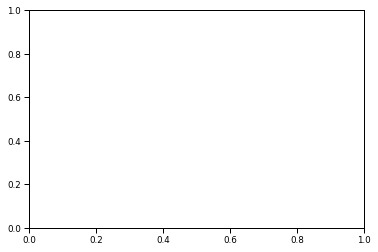

In [4]:
from myheatmap import myheatmap
from helperfunctions import flatten,listlength,printtime,make_real_iff_real, \
    store_params, read_params, savefigure, datestring, beep, calc_error_interval
from resonatorsimulator import curve1, theta1, curve2, theta2, realamp1, imamp1, realamp2, imamp2, \
    curvemono, thetamono, realampmono, imampmono, rsqrdlist, \
    complex_noise, calculate_spectra, noisyR1ampphase, noisyR2ampphase, SNRknown, SNRs
from simulated_experiment import describeresonator, measurementdfcalc, compile_rsqrd, \
    assert_results_length, describe_monomer_results, simulated_experiment
from resonatorstats import syserr, combinedsyserr, rsqrd
from resonatorphysics import complexamp, amp, A_from_Z, res_freq_weak_coupling, \
    approx_Q, approx_width, calcnarrowerW
from resonatorfrequencypicker import freqpoints, find_freq_from_angle, makemorefrequencies,\
    create_drive_arrays, find_special_freq, res_freq_numeric, \
    allmeasfreq_one_res, allmeasfreq_two_res, best_choice_freq_set
from resonatorSVDanalysis import Zmat, \
    normalize_parameters_1d_by_force, quadratic_formula, normalize_parameters_to_res1_and_F_2d, \
    normalize_parameters_to_m1_m2_assuming_2d, normalize_parameters_to_m1_set_k1_set_assuming_2d, \
    normalize_parameters_to_m1_F_set_assuming_2d, normalize_parameters_assuming_3d
from resonator_plotting import set_format, text_color_legend, spectrum_plot, plotcomplex, \
    plot_SVD_results, convert_to_measurementdf

# When this runs, an empty graph will appear below (because plotcomplex calls canvas.draw).

In [5]:
"""import matplotlib.font_manager # See list of fonts
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')"""

"import matplotlib.font_manager # See list of fonts\nmatplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')"

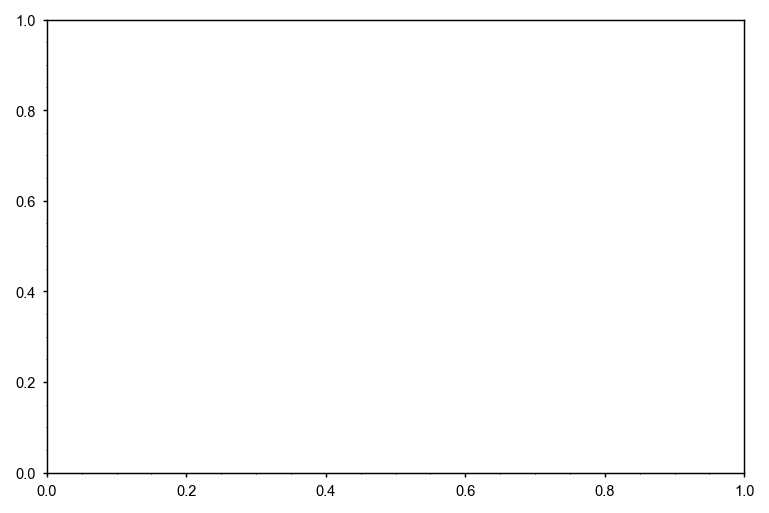

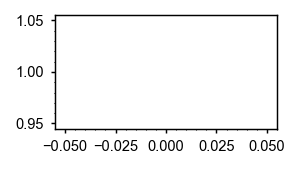

In [14]:
# global variables that I promise not to vary
from simulated_experiment import complexamplitudenoisefactor, use_complexnoise
from resonator_plotting import co1,co2,co3, figwidth # color scheme

# Nature says: (https://www.nature.com/npp/authors-and-referees/artwork-figures-tables)
#Figure width - single image	86 mm (3.38 in) (should be able to fit into a single column of the printed journal)
#Figure width - multi-part	178 mm (7 in) (should be able to fit into a double column of the printed journal)
#Text size	8 point (should be readable after reduction - avoid large type or thick lines)
#Line width	Between 0.5 and 1 point


set_format()

plt.figure(figsize = (3.82/2,1))
plt.plot(1)

In [7]:
verbose = False
#MONOMER = False
#forceboth = False

#define number of samples (over which to vary the drive frequency); 30 to test, 200 is very nice.
n = 100

m2_set = np.nan
k2_set = np.nan
k12_set = np.nan
b2_set = np.nan
forceboth = False

"""#Use functions to make matrices of amplitude and phase for each resonator (with noise)
#define set values (sandbox version.)
resonatorsystem = 1
m1_set = 5
m2_set = 3
b1_set = 1
b2_set = 0.5
k1_set = 12
k2_set = 27
k12_set = 1
F_set = 1
minfreq = .1
maxfreq = 5
noiselevel = .01
forceboth= False
MONOMER = False"""


"""
### lightly damped monomer ## this is my official lightly damped monomer for Fig 2.
MONOMER = True
resonatorsystem = 2
m1_set = 4
b1_set = 0.01
k1_set = 16
F_set = 1
minfreq = 1.99
maxfreq = 2.01
noiselevel= 10
forceboth = False
"""

"""
### medium damped monomer -- use for demo
resonatorsystem = 3
m1_set = 4
b1_set = .4
k1_set = 10
F_set = 1
MONOMER = True
minfreq = 1.4
maxfreq = 1.8
noiselevel = 200 # increased 2022-11-16 for demo Fig 1.
"""
"""
### medium damped monomer -- use for Fig 4, picking frequencies
resonatorsystem = -3
m1_set = 4
b1_set = .4
k1_set = 10
F_set = 1
MONOMER = True
minfreq = 1.4
maxfreq = 1.8
noiselevel = 1
"""
"""
## somewhat heavily damped monomer
MONOMER = True
resonatorsystem = 4
m1_set = 1
b1_set = 1
k1_set = 1
F_set = 1
minfreq = .01
maxfreq = 5
"""

"""### heavily damped monomer
MONOMER = True
resonatorsystem = 5
m1_set = 4
b1_set = 8
k1_set = 9
F_set = 1
noiselevel = 10"""


"""
# FORCEBOTH true or false?
# doe8 experiment that minimizes 1d syserr
# weakly coupled dimer #1
m2_set = 10
F_set=10
k12_set = 1
m1_set = 1
k2_set = 10
b1_set = .1
b2_set = .1
k1_set = 1
MONOMER = False
noiselevel = 10

#forceboth=True
#resonatorsystem = 6

forceboth = False
resonatorsystem = 7
minfreq = .3
maxfreq = 2.2
"""

"""
### Weakly coupled dimer #2
resonatorsystem = 8
m1_set = 11
m2_set = 5
b1_set = 0.5
b2_set = 0.1
k1_set = 9
k2_set = 20
k12_set = 1
F_set = 1
MONOMER = False
forceboth= False
"""
"""
## well-separated dimer, 1D then 2D, then 3D. Weakly coupled dimer #3
## But not very accurate.
resonatorsystem = 9
m1_set = 5
m2_set = 3
b1_set = 1
b2_set = 0.5
k1_set = 12
k2_set = 27
k12_set = 1
F_set = 1
minfreq = .1
maxfreq = 5
noiselevel = .1
forceboth= False
MONOMER = False
"""

"""### 1D better # weakly coupled dimer #4
#define set values
## This is the weakly coupled dimer I am using
## 2022-11-15 switched back to what I had before.
resonatorsystem = 10
m1_set = 1
m2_set = 10
b1_set = 0.1
b2_set = 0.1
k1_set = 1
k2_set = 10
k12_set = 1
F_set = 10
noiselevel =10
MONOMER = False
forceboth= False
minfreq = .1
maxfreq = 2.2
"""


## Well-separated dimer / Medium coupled dimer #1 / Used for Figure 5.
MONOMER = False
resonatorsystem = 11
m1_set = 8
m2_set = 1
b1_set = 0.5
b2_set = 0.1
k1_set = 2
k2_set = 7
k12_set = 5
F_set = 1
noiselevel = .1
forceboth= False
minfreq = 0.1
maxfreq = 5
#(but this is 3D for forceboth)


"""
### Medium coupled dimer #2
# This is my official medium coupled dimer.
resonatorsystem = 12
m1_set = 11
m2_set = 5
b1_set = 0.5
b2_set = 0.1
k1_set = 9
k2_set = 20
k12_set = 4
F_set = 1
MONOMER = False
noiselevel = 1 # reduced from 10, 2023-01-07 because the results were so poor
forceboth= False
minfreq = .1
maxfreq = 3
"""

"""## strongly coupled dimer
MONOMER = False
resonatorsystem = 13
m1_set = 8
m2_set = 1
b1_set = 0.5
b2_set = 0.1
k1_set = 2
k2_set = 4
k12_set = 11
F_set = 1
noiselevel = 5
forceboth= False"""

"""
### Can I scale Brittany's experimental data this way? Or do I need to incorporate the x10^-17 bits?
resonatorsystem = 14
k1_set = 1
k2_set = 1.7
k12_set = 0.066
m1_set = 5.248
m2_set = 8.581
b1_set = 2.502
b2_set = 5.864
F_set = 1.861
noiselevel = 1
forceboth = False"""

"""
### Does this make sense for Brittany's experimental data?
resonatorsystem = 15
k1_set = 1
k2_set = 1.7
k12_set = 0.066
m1_set = 5.248e-17
m2_set = 8.581e-17
b1_set = 2.502e-11
b2_set = 5.864e-11
F_set = 1.861e-6
noiselevel = 1e-6
forceboth = False
#minfreq = 4000
minfreq = 131946891 # 21 MHz * (2 * pi) 
maxfreq = 150796447 # 21 MHz * (2 * pi) 
"""

res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)


if MONOMER:
    res2 = res1
else:
    res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
    
vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

#Choose points for SVD

reslist = [res1,res2] # initialize

## reset resonances
for i in range(3):
    reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, includefreqs = reslist, 
                               minfreq = minfreq, maxfreq = maxfreq,
                               verboseplot = False, verbose=False, iterations = 3)

#define driving frequency range
#drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), [res1, res2]))
drive, morefrequencies = create_drive_arrays(vals_set = vals_set, callmakemore = True, includefreqs=reslist,
                                             minfreq=minfreq, maxfreq=maxfreq,
                                               MONOMER = MONOMER, forceboth=forceboth,
                                               n=n)

print('resonatorsystem:', resonatorsystem)
describeresonator(vals_set, MONOMER, forceboth, noiselevel)
print('Drive length:', len(drive), '(for calculating R^2)')

# choose 2
if resonatorsystem == 15: # 22.1208 MHz and 23.3554 MHz
    desiredfreqs = [22.1208*2 * np.pi * 1e6, 23.3554*2 * np.pi * 1e6]
else:
    desiredfreqs = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, includefreqs = reslist,
                                minfreq=minfreq, maxfreq = maxfreq,
                               verboseplot = False, verbose=False, iterations = 3, numtoreturn=2)

drive = np.sort(np.unique(np.append(drive, desiredfreqs)))
print('Desired freqs:', desiredfreqs)
p = freqpoints(desiredfreqs, drive)

#p = [1,8,17]

#p = [14,15,16,29,30,31] #indices of frequencies to use
#p=[14,16]
#p = range(len(drive))
print('Index of freqs:', p)

beep()

resonatorsystem: 11
DIMER
Applying oscillating force to m1.
Approximate Q1: 8.00 width: 0.06
Approximate Q2: 26.46 width: 0.10
Q ~ sqrt(m*k)/b
Set values:
m1: 8, b1: 0.5, k1: 2, F1: 1
m2: 1, b2: 0.1, k2: 7, k12: 5
noiselevel: 0.1
stdev sigma: 5e-05
Drive length: 100 (for calculating R^2)
Desired freqs: [0.773987235127223, 3.5328457422902457]
Index of freqs: [27, 81]


In [8]:
# redo in case it was updated
vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)

R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth=forceboth)
R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)
R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth)

usenoise = True

## actually calculate the spectra
noisyspectra = calculate_spectra(drive, vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth)
R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp, _  = noisyspectra



'''def vh_from_vals_set(drive, vals_set, MONOMER, forceboth):
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)
    
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth = forceboth)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth = forceboth)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',MONOMER=MONOMER)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)
        return u,s,vh''';


In [9]:
stophere # finish initialization. Next: try 1D, 2D, and 3D SVD

NameError: name 'stophere' is not defined

In [ ]:
if resonatorsystem == 15: # 22.1208 MHz and 23.3554 MHz
    desiredfreqs = [22.1208*2 * np.pi * 1e6, 23.3554*2 * np.pi * 1e6]
else:
    desiredfreqs = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, includefreqs = reslist,
                                minfreq=minfreq, maxfreq=maxfreq,
                                numtoreturn = 2, iterations = 3, verbose=False)
drive = np.unique(np.sort(np.append(drive, desiredfreqs)))
p = freqpoints(desiredfreqs = desiredfreqs, drive = drive)
print("p:",p)
assert len(np.unique(p)) == 2
print(len(drive))



In [ ]:
datacolor = 'C4'

# calculate noisy and noiseless measurements
R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth =forceboth)
R1_amp_noiseless, R1_phase_noiseless, R2_amp_noiseless, R2_phase_noiseless, \
    R1_real_amp_noiseless, R1_im_amp_noiseless, R2_real_amp_noiseless, R2_im_amp_noiseless, _ = calculate_spectra( \
            drive, vals_set, noiselevel = 0, MONOMER=MONOMER, forceboth =forceboth)




df = measurementdfcalc(drive, p,
                      R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless,
                      vals_set=vals_set, noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth)
display(df)

#Plots of simulated spectra

Q1 = approx_Q(k = k1_set, m = m1_set, b=b1_set)
W1 = approx_width(k = k1_set, m = m1_set, b=b1_set)

print('Simulated spectra data, as if from experiment')
print('Approximate Q1: ' + "{:.2f}".format(Q1) + ' width: ' + "{:.2f}".format(W1))
if MONOMER:
    print('Resonant frequency expected at ' 
          + str(res1))
    label_markers = drive[p]
else:
    Q2 = approx_Q(k = k2_set, m = m2_set, b=b2_set)
    W2 = approx_width(k = k2_set, m = m2_set, b=b2_set)
    print('Approximate Q2: ' + "{:.2f}".format(Q2) +
      ' width: ' + "{:.2f}".format(W2))
    print('Resonant frequencies expected at approximately ' 
          + str(res1) + ' and ' 
          + str(res2))
    label_markers = [res1, res2]

morefrequencies = np.sort(np.unique(np.append(morefrequencies, np.linspace(res1-W1, res1+W1, num = n))))
if not MONOMER:
    morefrequencies = np.sort(np.unique(np.append(morefrequencies, np.linspace(res2-W2, res2+W2, num = n))))
    
fig, ((ax1, ax3),(ax2,ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (10,10))

ax1.plot(morefrequencies, curve1(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                                 MONOMER=MONOMER, forceboth=forceboth), # true curve
         color = 'gray', alpha = 0.2)
ax1.plot(drive, R1_amp, '.', color = datacolor) # noisy simulated data
ax1.set_ylabel('Amplitude $A$ (m)\n')
ax1.set_title('Simulated R1 Amp')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax1.plot(df.drive[i], df.R1Amp[i], 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
ax2.plot(morefrequencies, theta1(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set,  0, 
                                 MONOMER=MONOMER, forceboth=forceboth)/np.pi, # true curve
         color = 'gray', alpha = 0.2)        
ax2.plot(drive, R1_phase/np.pi, '.', color = datacolor) # noisy simulated data
ax2.set_ylabel('Phase $\phi$ ($\pi$)')
ax2.set_title('Simulated R1 Phase')

#For loop to plot chosen values from table
for i in range(df.shape[0]):
    ax2.plot(df.drive[i], df.R1Phase[i]/np.pi, 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
ax3.plot(morefrequencies, curve2(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                                 forceboth=forceboth), # true curve
         color = 'gray', alpha = 0.2)    
ax3.plot(drive, R2_amp, '.', color = datacolor)
ax3.set_ylabel('Amplitude $A_2$ (m)\n')
ax3.set_title('Simulated R2 Amp')

#For loop to plot chosen values from table
for i in range(df.shape[0]):
    ax3.plot(df.drive[i], df.R2Amp[i], 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
    
ax4.plot(morefrequencies, theta2(morefrequencies, 
                                 k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set,  0, 
                                 forceboth=forceboth)/np.pi, # true curve
         color = 'gray', alpha = 0.2)
ax4.plot(drive, R2_phase/np.pi, '.', color = datacolor)
ax4.set_ylabel('Phase $\phi_2$ ($\pi$)')
ax4.set_title('Simulated R2 Phase')

#For loop to plot R1 amplitude values from table
for i in range(df.shape[0]):
    ax4.plot(df.drive[i], df.R2Phase[i]/np.pi, 'ko', fillstyle='none', markeredgewidth = 3, alpha = .8)
        
for ax in [ax1,ax2,ax3,ax4]:
    plt.sca(ax)
    #plt.xticks([res1, res2])
    ax.set_xlabel('Freq (rad/s)')

    
plt.tight_layout()



#Calculate complex amplitudes of spectra

Z1 = complexamp(R1_amp, R1_phase)
Z2 = complexamp(R2_amp, R2_phase)

#fig, (ax5, ax6) = plt.subplots(1, 2, figsize = (10,5))

# true curves
ax5.plot(realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                  MONOMER, forceboth=forceboth), 
         imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, 
                MONOMER, forceboth=forceboth), 
         color='gray', alpha = .5)
ax6.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth), 
         imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth), 
         color='gray', alpha = .5)

plotcomplex(Z1, drive, 'Complex Amplitude $Z_1$', ax=ax5, label_markers=label_markers)
ax5.scatter(np.real(df.R1AmpCom), np.imag(df.R1AmpCom), s=150, facecolors='none', edgecolors='k', label="data for SVD") 

plotcomplex(Z2, drive, 'Complex Amplitude $Z_2$', ax=ax6, label_markers=label_markers)
ax6.scatter(np.real(df.R2AmpCom), np.imag(df.R2AmpCom), s=150, facecolors='none', edgecolors='k', label="data for SVD") 
plt.legend()      
    
plt.tight_layout()

print('maxamp at:        ', res_freq_numeric(mode = 'maxamp', vals_set=vals_set, MONOMER=MONOMER,forceboth=forceboth, includefreqs = reslist,minfreq=minfreq, maxfreq=maxfreq))
print('resonant phase at:',res_freq_numeric(mode = 'phase',vals_set=vals_set, MONOMER=MONOMER,forceboth=forceboth, includefreqs=reslist,minfreq=minfreq, maxfreq=maxfreq))

In [ ]:
#Singular Value Decomposition

verbose = True

if MONOMER:
    parameternames = ['m1',  'b1',  'k1',  'Driving Force']
else:
    parameternames = ['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']

Zmatrix = Zmat(df, forceboth=forceboth,
               frequencycolumn = 'drive', 
               complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom', MONOMER=MONOMER)



if verbose:
    print("Z matrix:") 
    display(pd.DataFrame(np.array(Zmatrix, dtype = np.double), columns = parameternames))

#SVD
try:
    u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
except:
    print('Could not solve')
    
#u, s, vh = sc.linalg.svd(Zmatrix, full_matrices = False, lapack_driver = 'gesvd')
#vh = make_real_iff_real(vh)

# the smallest singular value is always the last one, index -1
print('Singular values:')
print(s)

plt.semilogy(s, '.')
plt.axhline(10**-2, color='gray')
plt.title('singular values');

In [ ]:
Z = make_real_iff_real(Zmatrix)
sns.heatmap(data =Z, cmap = 'bwr', center = 0 )
plt.xticks([])
plt.yticks([]);

In [ ]:
# singular vectors. # M1, M2, B1, B2, K1, K2, K12, FD
#display(vh)
vh = make_real_iff_real(vh)
display(vh)

In [ ]:
print('What does res_freq_weak_coupling look like for each singular vector?')
for vect in vh:
    ##unnormalized values
    M1, M2, B1, B2, K1, K2, K12, FD = read_params(vect, MONOMER)
    
    w = res_freq_weak_coupling(K1, M1, B1)
    if np.isnan(w):
        w = res_freq_weak_coupling(-K1, -M1, -B1)
    if not np.isnan(w):
        print(w)

print('Privilege weak-coupling resonant frequency: ' + str(res_freq_weak_coupling(k1_set, m1_set, b1_set)) )
print('Experimental view of resonant frequency:', res_freq_numeric(
    vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth,mode = 'amp', iterations = 1, includefreqs = reslist,
    minfreq=minfreq, maxfreq=maxfreq,
    unique = True, veryunique = True, numtoreturn = 1, verboseplot = False, verbose=verbose)[0])

In [ ]:
print("Checking the python-normalization")

vect =vh[-1]
sq = [el**2 for el in vect]
sum(sq)

In [ ]:
M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER)

measweakres1 = res_freq_weak_coupling(K1, M1, B1)
privweakres1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
maxampfreq = res_freq_numeric(numtoreturn = 1, vals_set =vals_set, MONOMER=MONOMER, forceboth=forceboth, 
                              minfreq=minfreq,maxfreq=maxfreq,
                              mode='amp', includefreqs = reslist)[0]
print('1D solution resonance frequency (weak coupling)')
print(measweakres1)
print('Weak-coupling resonance frequency as set (privilege)')
print(privweakres1)
print('Syserr:')
print(str(syserr(measweakres1,privweakres1)) + '%')

print('Max amplitude (no noise mini-privilege):')
print(maxampfreq)
print('Syserr (no noise mini-privilege):')
print(str(syserr(measweakres1,maxampfreq)) + '%')


if not MONOMER:
    measweakres2 = res_freq_weak_coupling(K2, M2, B2)
    privweakres2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
    print('\n1D solution resonance frequency (weak coupling)')
    print(measweakres2)
    print('\nWeak-coupling resonance frequency as set (privilege)')
    print(privweakres2)
    print('Syserr:')
    print(str(syserr(measweakres2,privweakres2)) + '%')

vals = [['Norm m1', 'Norm m2', 'Norm b1', 'Norm b2', 'Norm k1', 'Norm k2','Norm c12', 'Norm Driving Force']]
vals.append((M1, M2, B1, B2, K1, K2, K12, FD))

#print("Python-Normalized singular vector corresponding to parameters vector")
#print(tabulate(vals, headers = 'firstrow', tablefmt = 'fancy_grid'))

In [ ]:
#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')
print("The python normalization loses one degree of freedom, \
so we must be able to independently determine one parameter; say it's the driving force")

M1, M2, B1, B2, K1, K2, K12, FD = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
parameters = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(parameters[i], vals_set[i]) for i in range(len(parameters))]
avg1d, rms1d, max1d, Lavg1d = combinedsyserr(syserrs, 1)

if MONOMER:
    parameterlist = [['m1','b1', 'k1', 'Driving Force']]
    #M1, B1, K1,  FD = parameters
else:
    parameterlist = [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']]
    #M1, M2, B1, B2, K1, K2, K12, FD = parameters
vals2 = parameterlist.copy() # initialize parametersdf
vals2.append(parameters)
vals2.append(vals_set)
vals2.append(syserrs)

#print(tabulate(vals2, headers = 'firstrow', tablefmt = 'fancy_grid'))
parametersdf = pd.DataFrame(vals2, index = ['labels', 'from_svd', 'set', "syserr (%)"])
parametersdf.columns = parametersdf.iloc[0] 
print("How good are the 1D nullspace results?")
display(parametersdf)
parametersdf1d = parametersdf.copy()

#Calculate Rsqrd compared to 1D nullspace to test the 1D nullspace model

plotting = False
amp1_rsqrd = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER, forceboth=forceboth), 
                   data=R1_amp, plot=plotting, x=drive)
print('amp1_rsqrd', amp1_rsqrd)
phase1_rsqrd = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER, forceboth=forceboth), 
                     plot=plotting, x=drive)
print('phase1_rsqrd', phase1_rsqrd)
if not MONOMER:
    amp2_rsqrd = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                       plot=plotting, x=drive)
    print('amp2_rsqrd',amp2_rsqrd)
    phase2_rsqrd = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                         plot=plotting, x=drive)
    print('phase2_rsqrd',phase2_rsqrd)

## Calculate systematic err to test the 1D nullspace results

print('Noise level: ' + str(noiselevel))
try:
    print('R1 amp SNR: ' , df.SNR_R1.min(),  ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),  ' to ', df.SNR_R2.max())
    print('Average systematic err: ',avg1d, '%')
    print('RMS systematic err: ',rms1d, '%')
    print('Max systematic err: ',max1d, '%')
except TypeError:
    print("There was a TypeError.")



labelbarchart = False

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf.columns,parametersdf.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('err (%)\n')
plt.gca().set_xlabel('');
plt.title('1D nullspace')
plt.show()

print("Number of frequencies: ", len(p))
print("1D:")
print("R1 Amp Rsqrd = ", amp1_rsqrd,  '= 1 - ', 1-amp1_rsqrd,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd,'= 1 - ', 1-phase1_rsqrd)
if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd,'= 1 - ', 1-amp2_rsqrd,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd,'= 1 - ', 1-phase2_rsqrd)

plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth, labelfreqs=drive[p], overlay = False,
                saving=saving) 

In [ ]:
print('Avg syserr 1D: ', avg1d, '%')

In [ ]:
len(drive)

In [ ]:
## what if the null-space is 2D?

#View vh array and assign variables to proper row vector

print('Results of analysis versus set values:')

print("If the null-space is 2D, we must be able to independently determine two parameters; say we know resonating frequencies and force")

parameters, coefa, coefb = normalize_parameters_to_m1_F_set_assuming_2d(
    vh,MONOMER=MONOMER,verbose = verbose, m1_set =m1_set, F_set=F_set)
print('2d coefficients are:')
print(coefa, coefb)
print('2d parameters are:')
print(parameters)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(parameters[i], vals_set[i]) for i in range(len(parameters))]
avg2d, rms2d, max2d, Lavg2d = combinedsyserr(syserrs, 2)

vals3 = parameterlist.copy() # initialize to [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']] or shorter if monomer
vals3.append(parameters)
vals3.append(vals_set)
vals3.append(syserrs)

parametersdf3 = pd.DataFrame(vals3, index = ['labels', 'from_svd', 'set', 'syserr (%)'])
new_header3 = parametersdf3.iloc[0] 
parametersdf3.columns = new_header3
print('1D nullspace results:')
display(parametersdf1d)
print("How good are the 2D nullspace results?")
display(parametersdf3)

#Calculate Rsqrd compared to 2D nullspace to test the 2D nullspace model

plotting = False

amp1_rsqrd2D = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                     data=R1_amp, plot=plotting, x=drive)
phase1_rsqrd2D = rsqrd(data=R1_phase, 
                       model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                       plot=plotting, x=drive)
if not MONOMER:
    amp2_rsqrd2D = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                         plot=plotting, x=drive)
    phase2_rsqrd2D = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                           plot=plotting, x=drive)

try:
    print('Noise level: ' + str(noiselevel))
    print('R1 amp SNR: ', df.SNR_R1.min() , ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),' to ' ,df.SNR_R2.max())
    print('Average systematic err: ',avg2d, '%,'
          'whereas for 1D it was: ', avg1d, '%')
    print('RMS systematic err:   ', rms2d, '%',
          ' whereas for 1D it was: ', rms1d, '%')
    print('Max systematic err:   ',max2d, '%', 
          ' whereas for 1D it was: ',max1d, '%')
except TypeError:
    print('There was a TypeError.')

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf3.columns,parametersdf3.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf3.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('systematic err (%)\n')
plt.gca().set_xlabel('');
plt.title("2D nullspace")
plt.show()

print("Number of frequencies: ", len(p))
print('2D: ')
print("R1 Amp Rsqrd = ", amp1_rsqrd2D, '= 1 - ', 1-amp1_rsqrd2D,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd2D, '= 1 - ', 1-phase1_rsqrd2D
     )

if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd2D,'= 1 - ', 1-amp2_rsqrd2D,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd2D,'= 1 - ', 1-phase2_rsqrd2D)

In [ ]:
print("2D nullspace")
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth,saving=saving)

In [ ]:
## What if it's 3D nullspace?

if MONOMER:
    el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, vals_set,MONOMER )
else:
    el_3D, coefa, coefb, coefc = normalize_parameters_assuming_3d(vh, vals_set, MONOMER)
M1, M2, B1, B2, K1, K2, K12, FD = read_params(el_3D, MONOMER)
parameters = [parameter.real for parameter in parameters if parameter.imag == 0 ]
syserrs = [syserr(el_3D[i], vals_set[i]) for i in range(len(el_3D))]
avg3d, rms3d, max3d, Lavg3d = combinedsyserr(syserrs, 3)

vals3d = parameterlist.copy() # initialize to [['m1', 'm2', 'b1', 'b2', 'k1', 'k2','c12', 'Driving Force']]
vals3d.append(el_3D)
vals3d.append(vals_set)
vals3d.append(syserrs)

parametersdf3d = pd.DataFrame(vals3d, index = ['labels', 'from_svd', 'set', 'syserr (%)'])
new_header3d = parametersdf3d.iloc[0] 
parametersdf3d.columns = new_header3d
print('1D nullspace results:')
display(parametersdf1d)
print("2D nullspace results:")
display(parametersdf3)
print("3D nullspace results:")
display(parametersdf3d)

#Calculate Rsqrd compared to 3D nullspace to test the 3D nullspace model

plotting = False

amp1_rsqrd3D = rsqrd(model=curve1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth), 
                     data=R1_amp, plot=plotting, x=drive)
print('amp1_rsqrd3D',amp1_rsqrd3D)
phase1_rsqrd3D = rsqrd(data=R1_phase, model=theta1(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, MONOMER=MONOMER, forceboth=forceboth),
                       plot=plotting, x=drive)
print('phase1_rsqrd3D',phase1_rsqrd3D)
if not MONOMER:
    amp2_rsqrd3D = rsqrd(data=R2_amp, model=curve2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth),
                         plot=plotting, x=drive)
    print('amp2_rsqrd3D',amp2_rsqrd3D)
    phase2_rsqrd3D = rsqrd(data = R2_phase, model= theta2(drive, K1, K2, K12, B1, B2, FD, M1, M2, 0, forceboth=forceboth), 
                           plot=plotting, x=drive)
    print('phase2_rsqrd3D',phase2_rsqrd3D)

print('Noise level: ' + str(noiselevel))
try:
    print('R1 amp SNR: ' , df.SNR_R1.min(),  ' to ', df.SNR_R1.max())
    if not MONOMER:
        print('R2 amp SNR: ' , df.SNR_R2.min(),  ' to ' , df.SNR_R2.max())
    print('Average 3D systematic err: ', avg3d, '%',
          'whereas for 1D it was: ', avg1d, '%')
    print('RMS 3D systematic err:   ', rms3d, '%',
          ' whereas for 1D it was: ', rms1d, '%')
    print('Max 3D systematic err:   ', max3d, '%',
          ' whereas for 1D it was: ', max1d, '%')
except TypeError:
    print('There was a TypeError')

fig,ax = plt.subplots()
if labelbarchart:
    bargraph = ax.bar(parametersdf3.columns,parametersdf3d.transpose()['syserr (%)'])
    plt.gca().bar_label(bargraph)
else:
    (parametersdf3d.transpose()['syserr (%)']).plot(kind='bar')
plt.gca().set_ylabel('systematic err (%)\n')
plt.gca().set_xlabel('');
plt.title("3D nullspace")
plt.show()

print("Number of frequencies: ", len(p))
print("R1 Amp Rsqrd = ", amp1_rsqrd3D,
     "\nR1 Phase Rsqrd = ", phase1_rsqrd3D)
if not MONOMER:
      print("R2 Amp Rsqrd = ", amp2_rsqrd3D,
          "\nR2 Phase Rsqrd = ", phase2_rsqrd3D)
        
print("3D nullspace")
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,df,  K1, K2, K12, B1, B2, FD, M1, M2, 
                 vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth,saving=saving)

beep()

In [ ]:
stophere # next: do 1D, 2D, 3D with Repeats. simulated_experiment()

In [ ]:
reslist

In [ ]:
## settings for demo
if resonatorsystem == 3:
    demo = True
    n = 20
else:
    demo = False
    
try:
    measurementfreqs
except NameError:
    measurementfreqs = reslist
    

if resonatorsystem == 15:
    measurementfreqs = desiredfreqs # Brittany's expermental setup
else:
    for i in range(5):
        measurementfreqs, category = res_freq_numeric(vals_set, MONOMER, forceboth,
                                     mode = 'amp', includefreqs = reslist + measurementfreqs,
                                     minfreq=minfreq, maxfreq=maxfreq, morefrequencies=None,
                                     unique = True, veryunique = True, numtoreturn = 2, 
                                     verboseplot = False, plottitle = None, verbose=False, 
                                     iterations = 3,
                                     returnoptions = True)

print(measurementfreqs)

drive, morefrequencies = create_drive_arrays(vals_set, MONOMER, forceboth, n=n,
                                             includefreqs=measurementfreqs,
                                             callmakemore=True,
                                             minfreq = minfreq, maxfreq = maxfreq,
                                             verbose = verbose)

choose_random_freqs = False
num_random_freqs = 3
if choose_random_freqs:
    import random
    print('Choosing random frequencies')
    measurementfreqs = random.choices(drive, k=num_random_freqs)

    print(measurementfreqs)
plt.plot(drive) # Want this to be nonlinear to emphasize special frequencies
for w in measurementfreqs:
    plt.axhline(w, color='gray')

In [ ]:
try:
    del repeatedexptsres
except NameError:
    pass

In [ ]:
set_format()

In [ ]:
plt.rcParams
# display settings

In [ ]:
resonatorsystem

In [ ]:
overlay = False
figsizeoverride1 = None
figsizeoverride2 = None

if resonatorsystem == 2: # Monomer: set width, height
    # spectra amplitude & phase
    figsizeoverride1 = (2.1258, 1.3)
    # complex plot
    figsizeoverride2 = (figwidth/2, 1.3)
elif resonatorsystem == 10: # dimer
    # spectra amplitude & phase
    figsizeoverride1 = (figwidth, 1.45) #1.864736842105263)
    # complex plot
    figsizeoverride2 = (figwidth, 1.48)

# Ran 1000 times in 20.438 sec
# Ran 1000 times in 16.996 sec on desktop with verbose = True
repeats = 1
#repeats = 999
if demo:
    repeats = 1
    overlay = True
if MONOMER:
    overlay = True
verbose = True
before = time()
if True: # repeats are incorporated in the function instead of at this level, but we can run this cell again.
    set_format()
    thisres = simulated_experiment(measurementfreqs, drive=drive,vals_set = vals_set, 
                                   noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth,
                                   overlay=overlay, demo = demo, 
                                   figsizeoverride1 = figsizeoverride1, figsizeoverride2 = figsizeoverride2,
                                   resonatorsystem=resonatorsystem, show_set=True,
                                   repeats=repeats , verbose = verbose,  context = 'paper', saving = saving)
    try: # repeated experiments results
        repeatedexptsres = repeatedexptsres.append(thisres, ignore_index=True)
    except:
        repeatedexptsres = thisres
after = time()
printtime(repeats, before, after)   
display(repeatedexptsres.transpose()) 

repeatedexptsresmean = repeatedexptsres.mean() 

In [ ]:
list(repeatedexptsres.columns)

In [ ]:
repeatedexptsres['avgsyserr%_1D']

In [ ]:
repeatedexptsres['sqrtk1m1_set'] = np.sqrt(repeatedexptsres['k1_set']/repeatedexptsres['m1_set'])
if not MONOMER:
    repeatedexptsres['sqrtk2m2_set'] = np.sqrt(repeatedexptsres['k2_set']/repeatedexptsres['m2_set'])
for D in ['1D', '2D', '3D']:
    repeatedexptsres['SQRTK1M1_' + D] = np.sqrt(repeatedexptsres['K1_' + D]/repeatedexptsres['M1_' + D])
    if not MONOMER:
        repeatedexptsres['SQRTK2M2_' + D] = np.sqrt(repeatedexptsres['K2_' + D]/repeatedexptsres['M2_' + D])


repeatedexptsresmean = repeatedexptsres.mean(numeric_only=True) 

In [ ]:
#sns.set_context('paper')
saving = True

describeresonator(vals_set, MONOMER, forceboth, noiselevel)
figheight = 1.3

if MONOMER:
    shortkeysummary = ['m1','k1','b1', 'sqrtk1m1']
else:
    shortkeysummary = ['m1', 'k1',  'sqrtk1m1', 'b1', 'm2', 'k2', 'sqrtk2m2', 'b2', 'k12']
    

if resonatorsystem == 12:
    list_to_show = ['1D', '3D']
    colors = [co1, co3]
elif resonatorsystem == 2:
    list_to_show = ['1D', '2D']
    colors = [co1, co2]
else:
    list_to_show = ['1D', '2D', '3D']
    colors = [co1, co2, co3]
    
shortkeylist = list([])
shortkeylistset = list([])
for key in shortkeysummary:
    for D in list_to_show:
        shortkeylist.append(key.upper()+ '_' + D)
        shortkeylistset.append(key.lower() + '_set')

    
#paper-style box and whisker figure about the error.
set_format()

# create dataframe of signed systematic errors
signederr = syserr(x_found = (repeatedexptsres[shortkeylist]), 
       x_set = np.array(repeatedexptsres[shortkeylistset]), 
       absval = False)


signederr.rename(columns={'M1_1D': '$m_{1,\mathrm{1D}}$', 'M2_1D': '$m_{2,\mathrm{1D}}$',
                            'B1_1D': '$b_{1,\mathrm{1D}}$', 'B2_1D': '$b_{2,\mathrm{1D}}$',
                            'K1_1D': '$k_{1,\mathrm{1D}}$', 'K2_1D': '$k_{2,\mathrm{1D}}$',
                            'M1_2D': '$m_{1,\mathrm{2D}}$', 'M2_2D': '$m_{2,\mathrm{2D}}$',
                            'B1_2D': '$b_{1,\mathrm{2D}}$', 'B2_2D': '$b_{2,\mathrm{2D}}$',
                            'K1_2D': '$k_{1,\mathrm{2D}}$', 'K2_2D': '$k_{2,\mathrm{2D}}$',
                            'M1_3D': '$m_{1,\mathrm{3D}}$', 'M2_3D': '$m_{2,\mathrm{3D}}$',
                            'B1_3D': '$b_{1,\mathrm{3D}}$', 'B2_3D': '$b_{2,\mathrm{3D}}$',
                            'K1_3D': '$k_{1,\mathrm{3D}}$', 'K2_3D': '$k_{2,\mathrm{3D}}$',       
                            'K12_3D': '$k_{12,\mathrm{3D}}$', 'K12_1D': '$k_{12,\mathrm{1D}}$', 
                            'K12_2D': '$k_{12,\mathrm{2D}}$', 
                            'SQRTK1M1_1D': '$\sqrt{k_1/m_1}_\mathrm{,1D}$',
                            'SQRTK1M1_2D': '$\sqrt{k_1/m_1}_\mathrm{,2D}$',
                            'SQRTK1M1_3D': '$\sqrt{k_1/m_1}_\mathrm{,3D}$',
                          'SQRTK2M2_1D': '$\sqrt{k_2/m_2}_\mathrm{,1D}$',
                          'SQRTK2M2_2D': '$\sqrt{k_2/m_2}_\mathrm{,2D}$',
                          'SQRTK2M2_3D': '$\sqrt{k_2/m_2}_\mathrm{,3D}$',
    },
    inplace=True)

#display(signederr)
#fig, (ax1,ax2) = plt.subplots(2,1, figsize = (3.5,3.5))

if MONOMER:
    boxwhiskerfigsize = (figwidth/2,figheight)
else:
    boxwhiskerfigsize = (figwidth*1,figheight)
print('Box and Whisker figsize:', boxwhiskerfigsize)

with sns.axes_style(rc={'xtick.bottom': False,})
    fig, ax1 = plt.subplots(1,1, figsize = boxwhiskerfigsize, dpi=150)
    # notch shows 95% confidence interval of the median
    ax = ax1
    plt.sca(ax1)
    ax.boxplot((signederr), notch=True, 
                vert=None, patch_artist=None, widths=None, meanline = True,
                flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'k', 'alpha': .1},
                labels=signederr.columns); 
    lims = plt.ylim()
    if list_to_show[1] == '2D' or '3D':
        ax1.annotate('fixed', xy = (2,lims[0] + .1 *(lims[1]-lims[0])), rotation = 90, ha='center')#, loc='center left')
    plt.xticks(rotation=60, ha='right');
    ax1.tick_params(axis = "x", left=True, bottom=False, pad = -2)
    ax1.tick_params(axis='y',length=3)
    plt.ylabel('$({p_i}-{p_{i,set}})/{p_{i,set}}$ (%)');
    #plt.ylabel(r'$\frac{{p_i}-{p_{i,set}}}{p_{i,set}} \cdot 100\%$');
    sns.despine(ax = ax1, bottom = True)
    plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "box-whisker," + datestr
    savefigure(savename)
plt.show()

with sns.axes_style(rc={'xtick.bottom': True,}):
    fig, ax2 = plt.subplots(1,1, figsize = (figwidth/2,figheight), dpi=150)
    plt.sca(ax2)
    description = 'avgsyserr%'
    for i in range(len(list_to_show)):
        D = list_to_show[i]
        key = description + '_' + D
        #sns.histplot(repeatedexptsres[key],kde=False, stat="density", linewidth=0, label=key, )
        plt.hist(repeatedexptsres[key], bins=20,histtype = 'step', label = D, color = colors[i]);
    text_color_legend()
    plt.xlabel('Average err (%)')
    plt.ylabel('Occurrences')
    ax2.set_yticks([])
    sns.despine(ax=ax2, left = True)
plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "probdist," + datestr
    savefigure(savename)
plt.show()

#sns.set_context('talk')

In [ ]:
print('noiselevel:', noiselevel)
print('meanSNR_R1:', repeatedexptsres.meanSNR_R1[0])
if not MONOMER:
    print('meanSNR_R2:', repeatedexptsres.meanSNR_R2[0])


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (figwidth,figwidth))#, gridspec_kw={'hspace': 0}, sharex = 'all')

if MONOMER:
    Xkey = '1-expt_A1_rsqrd_'
else:
    Xkey = '1-expt_ampavg_rsqrd_'
    
symb = '.'

plt.sca(ax1)
plt.loglog(repeatedexptsres[Xkey + '1D'], repeatedexptsres['avgsyserr%_1D'], symb, alpha = .08, label='1D')
#plt.title('1D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');
plt.legend()
    
plt.sca(ax2)
plt.loglog(repeatedexptsres[Xkey + '2D'], repeatedexptsres['avgsyserr%_2D'], symb, alpha = .08, label='2D')
#plt.title(' 2D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');
plt.legend()

plt.sca(ax3)
plt.loglog(repeatedexptsres[Xkey + '3D'], repeatedexptsres['avgsyserr%_3D'], symb, alpha = .08, label='3D')
#plt.title('3D');
plt.xlabel('$1-R^2$')
plt.ylabel('syserr (%)');

plt.suptitle('$R^2$ is useful for predicting syserr\nbut not dimension')
plt.legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1, figsize = (figwidth/2,figheight), gridspec_kw={'hspace': 0}, sharex = 'all', dpi=150)
for D in list_to_show:
    plt.loglog(repeatedexptsres[Xkey +D], repeatedexptsres['avgsyserr%_'+ D], symb, markersize=1, alpha = .08, label=D)
    #plt.loglog(repeatedexptsres[Xkey +D][::5], repeatedexptsres['avgsyserr%_'+ D][::5], symb, alpha = .08, label=D)
    #plt.loglog(repeatedexptsresmean[Xkey +D], repeatedexptsresmean['avgsyserr%_'+ D] )
#plt.title('1D');
plt.xlabel('$1-R^2$')
#plt.xlim(xmax = 10**-6)
#plt.legend()
plt.ylabel('err (%)');
if resonatorsystem == 2:
    plt.xticks([1e-6,1e-7])
if False:
    locmaj = mpl.ticker.LogLocator(numticks=2)
    #ax.yaxis.set_major_locator(locmaj)
    ax.xaxis.set_major_locator(locmaj)
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
#plt.axis('equal');
plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "Rsqd,manypts," + datestr
    savefigure(savename)
    

    
display('Number of items measured:', len(repeatedexptsres.columns)) # 200 -> 142 distributions

In [ ]:
keylist = [] # list of keys for things that vary
count = 0 # count number of plots
countconst = 0
for key in repeatedexptsres.columns:
    try:
        if np.isnan(repeatedexptsres[key]).all():
            countconst = countconst + 1
            continue
        if 'any neg' in key: # don't plot the distribution of this boolean
            print(key + ':' )
            print(repeatedexptsres[key].value_counts())
            continue
        if repeatedexptsres[key][0].size > 1: # frequencies is a list rather than a number
            print(key, ': ', repeatedexptsres[key][0])
            countconst = countconst + 1
            continue            
        if abs(repeatedexptsres[key].std()) < .000000001 or 'SNR' in key: 
            if 'rsqrd' in key:
                if 'num_freq_used_for_rsqrd' in key:
                    print(key, ': ', repeatedexptsresmean[key])
                    countconst = countconst + 1
                    continue
                # else do plot it
            else:    
                print(key, ': ', repeatedexptsresmean[key])
                countconst = countconst + 1
                continue
    except:
        print("Error from key:" , key)
        countconst = countconst + 1
        continue

    count = count+1
    keylist.append(key)


In [ ]:
plotgrid = ((int(math.ceil((len(keylist)+1)/5))),5)
slowplot = False

assert len(keylist) <= plotgrid[0] * plotgrid[1]

if MONOMER:
    figsize = (20,45)
else:
    figsize = (20,70)
figsizefull = figsize

if slowplot:
    fig, axs = plt.subplots(plotgrid[0], plotgrid[1], figsize = figsize)

    assert len(keylist) <=  len(axs.flat)
    print(len(keylist), 'graphs will be plotted in ', len(axs.flat), 'axes.')

    #init:
    count = 0
    distribution = 'norm'
    for key in keylist:
        try:
            if verbose:
                print(count, ':' , key)
            if len(repeatedexptsres)>400:
                bins = 25
            else:
                bins = 10
            plt.sca(axs.flat[count])
            stats.probplot(repeatedexptsres[key], dist=distribution, plot = plt )
            plt.xlabel('')
            plt.ylabel('')
            #plt.hist(repeatedexptsres[key], bins=bins);
            plt.title(key + '\n')
            #plt.show()
            count = count+1
        except TypeError:
            print('Cannot make hist for ', key)
    print('Showing ', count, ' plots to judge if these are', distribution, 'curves')
    print('If our data comes from a', distribution, 'distribution, we should see all the points sitting on the straight line.')
    # https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
    plt.tight_layout()



In [ ]:
""" a Half normal distribution and a log normal distribution are kind of close. """

if MONOMER:
    numplots = 22 # was 26 before I removed Lavg
    figsize = (15,12)
else:
    numplots = 35
    figsize=(15,18)

if slowplot:
    fig, axs = plt.subplots(int(math.ceil(numplots/5)), 5, figsize = figsize)

    count = 0 # count number of plots
    for key in keylist:
        try:
            if 'syserr' not in key or ('log ' in key and '-' not in key):
                continue
            if len(repeatedexptsres)>400:
                bins = 25
            else:
                bins = 10
            plt.sca(axs.flat[count])
            stats.probplot(repeatedexptsres[key], dist='halfnorm', plot = plt )
            distribution = 'halfnormal'
            #plt.hist(repeatedexptsres[key], bins=bins);
            plt.xlabel('')
            plt.ylabel('')
            plt.title(key)
            #plt.show()
            count = count+1
        except TypeError:
            print('Cannot make hist for ', key)
    print('Showing ', count, ' plots to judge if these are', distribution, 'curves')
    print('If our data comes from a', distribution, 'distribution, we should see all the points sitting on the straight line.')
    # https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
    plt.tight_layout()



In [ ]:
"""syserrlist = [key for key in keylist if 'syserr' in key]

syserrresults = repeatedexptsres[syserrlist] # Do I want violin plots?

sns.violinplot(x=syserrlist,y=syserrresults ,
    fontsize=7, rot=90)
    """;

In [ ]:
plt.plot(repeatedexptsres['M1_1D']/repeatedexptsres['m1_set'],repeatedexptsres['K1_1D']/repeatedexptsres['k1_set'], '.' )

In [ ]:
list(repeatedexptsres.columns)

In [ ]:
#aiming to make a publishable histogram figure about the error.

if MONOMER:
    shortkeysummary = ['M1','K1','B1']
else:
    shortkeysummary = ['m1', 'k1', 'b1', 'm2', 'k2', 'b2', 'k12']


show_3D = False
if show_3D:
    shortkeylist = flatten([[key.upper() + '_1D', key.upper() + '_2D', key+'_3D'] for key in shortkeysummary])
    shortkeylistset = flatten([[key.lower() + '_set']*3 for key in shortkeysummary])
else:
    shortkeylist = flatten([[key.upper() + '_1D', key.upper() + '_2D'] for key in shortkeysummary])
    shortkeylistset = flatten([[key.lower() + '_set']*2 for key in shortkeysummary])
    
# box and whisker figure about the error.

# create dataframe of signed systematic errors
signederr = syserr(x_found = (repeatedexptsres[shortkeylist]), 
       x_set = np.array(repeatedexptsres[shortkeylistset]), 
       absval = False)

#display(signederr)


fig, ax = plt.subplots(1,1, figsize = (4,2))
# notch shows 95% confidence interval of the median
ax.boxplot((signederr), notch=True, 
            vert=None, patch_artist=None, widths=None, meanline = True,
            labels=signederr.columns); 
lims = plt.ylim()

ax.annotate('fixed', xy = (2,lims[0] + .2 *(lims[1]-lims[0])), rotation = 90, ha='center')#, loc='center left')
plt.xticks(rotation=90);
plt.ylabel('$(({p_i}-{p_{i,set}})/{p_{i,set}}) \cdot 100\%$');

fig, ax = plt.subplots(1,1, figsize = (4,2))
# notch shows 95% confidence interval of the median
ax.boxplot(abs(signederr), notch=True, 
            vert=None, patch_artist=None, widths=None, meanline = True,
            labels=signederr.columns); 
plt.ylabel('abs$(({p_i}-{p_{i,set}})/{p_{i,set}}) \cdot 100\%$');


## histogram
fig, ax = plt.subplots(1,1, figsize = (4,2))
for i in range(len(shortkeylist)):
    key = shortkeylist[i]
    keydivisor = shortkeylistset[i]
    try:
        #sns.histplot(repeatedexptsres[key],kde=False, stat="density", linewidth=0)
        plt.hist((repeatedexptsres[key]/repeatedexptsres[keydivisor])-1, bins=30,
                 histtype = 'step',
                 label=key + '/' + keydivisor);
    except TypeError or ValueError:
        print('Cannot make hist for ', key)
        
plt.xlabel('${p_i}/{p_{i,set}}-1$')
plt.ylabel('Occurences')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
plt.tight_layout()

print('Measurement standard deviation:', repeatedexptsres['stdev'][0], 'm')

describeresonator(vals_set, MONOMER, forceboth, noiselevel)



In [ ]:
lims

In [ ]:
fig, axs = plt.subplots(plotgrid[0], plotgrid[1], figsize = figsizefull)

count = 0 # count number of plots
before = time()
for key in keylist:
    try:
        #print(count)
        plt.sca(axs.flat[count])
        #sns.histplot(repeatedexptsres[key],kde=False, stat="density", linewidth=0)
        plt.hist(repeatedexptsres[key], bins=10);
        plt.xlabel('\n' + key)
        plt.ylabel('')
        #plt.show()
        count = count+1
    except TypeError or ValueError:
        print('Cannot make hist for ', key)
after = time()
print('Showing ', count, ' plots')
printtime(count, before, after)
print('Some of these are the folded normal (half normal) distribution')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(50,50))
sns.heatmap(repeatedexptsres[keylist].corr(), cmap='PiYG' );

In [ ]:
len(drive)

In [ ]:
count/5

In [ ]:
if MONOMER:
    numlines = 8
    figsize = (50,60)
else:
    numlines = 12
    figsize = (20,35)
    
fig, axs = plt.subplots(numlines,5, figsize = figsize)

count = 0
for key in keylist:
    if 'log' in key or np.isnan(repeatedexptsres[key][0]):
        #print('skipping '  + key)
        continue
    #print(key)
    try:
        if 'syserr%_1D' in key and 'log' not in key and '-' not in key:
            #print('Graphing ' + key)
            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres[Xkey + '1D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                #plt.title('1D'); 
                plt.xlabel('amplitude $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass
            except:
                print("error with " + Xkey + '1D' + 'versus' + key)
                pass
            #print(count)

            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres['1-avg_expt_cartes_rsqrd_1D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                #plt.title('1D'); 
                plt.xlabel('cartes $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass
                #plt.legend()
            except:
                print("error with " + '1-avg_expt_cartes_rsqrd_1D' + 
                     'versus ' + key)
                pass
            #print(count)
            
        if 'syserr%_2D' in key and 'log' not in key and '-' not in key:
            #print('graphing ' + key)
            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres[Xkey + '2D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                plt.xlabel('amplitude $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass       
                #plt.legend()
            except:
                print('Error graphing ' + Xkey + '2D' + ' versus ' + key)
            #print(count)

            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres[Xkey + '2D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                plt.xlabel('cartes $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass
                #plt.legend()
            except:
                print('Error graphing '+ Xkey + '2D' + ' versus ' + key)
            #print(count)

        if 'syserr%_3D' in key and 'log' not in key and '-' not in key:
            #print('Plotting ' + key)
            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres[Xkey + '3D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                plt.xlabel('amplitude $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass       
                #plt.legend()
            except:
                print ('error graphing ' + Xkey + '3D' + ' versus ' + key)
                pass
            #print(count)

            try:
                plt.sca(axs.flat[count])
                count = count + 1
                plt.plot(repeatedexptsres['1-avg_expt_cartes_rsqrd_3D'], repeatedexptsres[key], symb, alpha = .08, label=key)
                plt.xlabel('cartes $1-R^2$')
                plt.ylabel(key);
                try:
                    plt.gca().set_xscale('log')
                    plt.gca().set_yscale('log')        
                except:
                    pass
                #plt.legend()
            except:
                print('error graphing ' + '1-avg_expt_cartes_rsqrd_3D' +  ' versus ' + key)
            #print(count)
        #print(key)
    except:
        print('ERROR')
        pass

plt.tight_layout()

In [ ]:
plt.loglog(repeatedexptsres['1-expt_A1_rsqrd_1D'], repeatedexptsres['M1syserr%_1D'], symb, alpha = .1, label='$A_1$')
if not MONOMER:
    plt.loglog(repeatedexptsres['1-expt_A2_rsqrd_1D'], repeatedexptsres['M1syserr%_1D'], symb, alpha = .1, label='$A_2$')
plt.legend();
plt.xlabel('$1-R^2$')
plt.ylabel('M1syserr%_1D');

In [ ]:
if not MONOMER:
    repeatedexptsres[['1-expt_A1_rsqrd_1D','1-expt_A2_rsqrd_1D','M1syserr%_1D' ]].corr()

In [ ]:
stophere # next: vary_num_p_with_fixed_freqdiff() gradually increases number of measurement points

In [ ]:
try:
    del resultsvarynump
except NameError:
    pass

In [ ]:
""" Vary the number of measurement frequencies / vary num p / vary nump """
from sim_series_of_experiments import vary_num_p_with_fixed_freqdiff
    
W1 = approx_width(k = k1_set, m = m1_set, b=b1_set)
if MONOMER:
    W = W1
    # choose an odd max_num_p for MONOMER
    max_num_p = 25
else:
    W2 = approx_width(k = k2_set, m = m2_set, b=b2_set)
    W = W2
    # choose an even max_num_p for dimer
    max_num_p = 50

# Ran 100 times in 7.121 sec
# Ran 100 times in 78.661 sec with verbose = True (only counts the first repeat).
# Ran 100 times in 786.946 sec with verbose = False
#repeats = 80*2
repeats = 1
verbose = False   # if False, still shows one graph for each dimension
freqdiff = round(W/10,4)
print('freqdiff:', freqdiff)

if MONOMER:
    overlay = True
else:
    overlay = False
    
figsizeoverride1 = None # default
figsizeoverride2 = None # default
if resonatorsystem == -3: # Monomer: set width, height
    # spectra amplitude & phase
    figsizeoverride1 = (2.1258, 1.4)
    # complex plot
    figsizeoverride2 = (figwidth/2, 1.4)
elif resonatorsystem == 2: # Monomer: set width, height
    # spectra amplitude & phase
    figsizeoverride1 = (2.1258, 1.3)
    # complex plot
    figsizeoverride2 = (figwidth/2, 1.3)
elif resonatorsystem == 10: # dimer
    # spectra amplitude & phase
    figsizeoverride1 = (figwidth, 1.45) #1.864736842105263)
    # complex plot
    figsizeoverride2 = (figwidth, 1.48)

before = time()
for i in range(1): # don't do repeats at this level.
    thisres, plot_info_1D = vary_num_p_with_fixed_freqdiff( vals_set, noiselevel, 
                    MONOMER, forceboth,reslist = reslist,
                    minfreq=minfreq, maxfreq = maxfreq,
                    verbose = verbose, just_res1 = False, 
                    max_num_p=max_num_p, 
                    freqdiff = freqdiff,
                    n=n, # number of frequencies for R^2
                    repeats = repeats,
                    overlay = overlay, saving = saving,
                    context = 'paper', resonatorsystem = resonatorsystem,
                    figsizeoverride1 = figsizeoverride1, figsizeoverride2 = figsizeoverride2,
                    recalculate_randomness = False)
    verbose = False
    try:
        resultsvarynump = resultsvarynump.append(thisres, ignore_index=True)
    except:
        resultsvarynump = thisres
        
datestr = datestring()
resultsvarynump.to_csv(os.path.join(savefolder,
                    datestr + "resultsvarynump.csv"));
resultsvarynump.to_pickle(os.path.join(savefolder,
                       datestr + 'resultsvarynump.pkl'))
print('Saved: ' + os.path.join(savefolder,
                       datestr + 'resultsvarynump.csv'))
        
after = time()
printtime(repeats, before, after)   
display(resultsvarynump.transpose())

[plot_info_1D_drive,R1_amp,R1_phase,R2_amp,R2_phase, plot_info_1D_df,  K1, K2, K12, B1, B2, FD, M1, M2, plot_info_1D_vals_set, 
     plot_info_1D_MONOMER, plot_info_1D_forceboth, plot_info_1D_labelcounts, plot_info_1D_overlay,
     _, _, _, plot_info_1D_demo,
     _, show_set,
     figsizeoverride1, figsizeoverride2] = plot_info_1D

resultsvarynumpmean = resultsvarynump.groupby(by=['num frequency points'],as_index=False).mean()
datestr = datestring()

verbose = False


"""
sim_series_of_experiments.py

def vary_num_p_with_fixed_freqdiff(vals_set, noiselevel, 
                                   MONOMER, forceboth,reslist,
                                   minfreq = .1, maxfreq = 5,
                                   max_num_p = 10,  
                                   n = 100, # number of frequencies for R^2
                                   freqdiff = .1,just_res1 = False, repeats = 100,
                                   verbose = False,recalculate_randomness=True ):
""";

In [ ]:
plt.scatter?

In [ ]:
#plotcomplex(Z2, plot_info_1D_drive)
saving = False
show_set = True
if not MONOMER:
    figsize = (2.1, 1.7715)

    plt.figure(figsize = figsize, dpi=600)
    
    if show_set:
        plt.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                          0,MONOMER=MONOMER, forceboth=forceboth,), 
                 imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                        0,MONOMER=MONOMER, forceboth=forceboth,), 
                 color='gray', alpha = .5, lw = 0.5, zorder = 1)

    plt.axvline(0,  color = 'k', linestyle='solid',  linewidth = .5, zorder = 3)
    plt.axhline(0, color = 'k', linestyle='solid',  linewidth = .5, zorder = 4)
    sc = plt.scatter(np.real(Z2), np.imag(Z2), c = plot_info_1D_drive, s=10, 
                     cmap = 'rainbow', zorder = 2) # option 3: s=4.
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    ax = plt.gca()

    ax.set_xlabel('$\mathrm{Re}(Z)$ (m)')
    ax.set_ylabel('$\mathrm{Im}(Z)$ (m)')
    ax.axis('equal');
    """    plt.gcf().canvas.draw() # draw so I can get xlim and ylim.
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()"""
    ax6 = plt.gca()
    
    

    
    ax6.scatter(np.real(measurementdf.R2AmpCom), np.imag(measurementdf.R2AmpCom), 
                marker = '+', color = 'w', lw = 0.5, s = 5,
                #s=5, facecolors='none', edgecolors='k', lw = 0.5, # option 3
                #s=1, facecolors='w', edgecolors='k', lw = 0.5, 
                label="points for analysis", zorder = 6) 
    
    ax6.plot(realamp2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0,forceboth=forceboth,), 
                 imamp2(morefrequencies, K1, K2, K12, B1, B2, FD, M1, M2, 0,forceboth=forceboth,), 
                 '--', color='black', alpha = 1, lw = 0.7, zorder = 5)
    if labelcounts:
        for i in range(len(measurementdf)):
            plt.annotate(text=str(i+1), 
                         xy=(np.real(measurementdf.R2AmpCom), 
                             np.imag(measurementdf.R2AmpCom)) )
    plt.xlabel('Re($Z_2$) (m)')
    plt.ylabel('Im($Z_2$) (m)')


    #plt.xlim((-0.11, 0.10))
    #plt.ylim((-.02, .18))
    
    plt.tight_layout()
    if saving:
        filename = datestr + 'spectrumZ_1D_zoomin' 
        savefigure(filename)
    plt.show()

In [ ]:
resultsvarynumpmean.SNR_R1_f1[0]

In [ ]:
describeresonator(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, noiselevel=noiselevel)

In [ ]:
resultsvarynump, resultsvarynumpmean = calc_error_interval(resultsvarynump, resultsvarynumpmean, groupby='num frequency points', fractionofdata = .95)

In [ ]:
print('Noiselevel: ' + str(noiselevel))
symb = '.'  # plotting style
lw = 0.5
co1 = 'C0'
co2 = 'C1'
co3 = 'C2'
#saving = False

set_format()
reps = int(len(resultsvarynump) / len(resultsvarynumpmean))

figsize = (figwidth, 1.48)
if resonatorsystem == -3: # Monomer:
    figsize = (2.8, 1.4)

plt.figure(figsize=figsize)
#plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_3D'], symb, alpha = .1, color = co3 )
#plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_2D'], symb, alpha = .1, color = co2)
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .1, color = co1)
#plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_3D'],  label='3D', color = co3)
#plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_2D'],  label='2D', color = co2)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_1D'], label='1D', color = co1)
text_color_legend()
#plt.gca().set_yscale('log')
plt.xlabel('num frequency points');
plt.ylabel('Avg err (%)')
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "numpvsE,1D," + datestr + ', noise'+ str(noiselevel)
    savefigure(savename)
plt.show()

plt.figure(figsize=figsize)
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_3D'], symb, alpha = .1, color = co3 )
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_2D'], symb, alpha = .1, color = co2)
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .1, color = co1)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_3D'],  label='3D', color = co3)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_2D'],  label='2D', color = co2)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_1D'], label='1D', color = co1)
text_color_legend()
plt.xlim(xmin=0)
plt.gca().set_yscale('log')
#plt.xlabel('num frequency points')
plt.xlabel('number of frequency points');
plt.ylabel('Avg err (%)')
plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "numpvsE,log," + datestr + ', noise'+ str(noiselevel)
    savefigure(savename)
    resultsvarynump[['num frequency points','avgsyserr%_1D','avgsyserr%_2D','avgsyserr%_3D']].to_csv(savename + '.csv')
plt.show()

# ***
plt.figure(figsize=figsize)
axa = plt.gca()
dimensions = ['3D', '2D', '1D']
colors = [co3, co2, co1]
X = resultsvarynumpmean['num frequency points']
for i in range(3):
        Yhigh = resultsvarynumpmean['E_upper_' + dimensions[i]]
        Ylow = resultsvarynumpmean['E_lower_' + dimensions[i]]                            
        plt.plot(X, Yhigh, color = colors[i], alpha = .3, linewidth=.3)
        plt.plot(X, Ylow, color = colors[i], alpha = .3, linewidth=.3)
        axa.fill_between(X, Ylow, Yhigh, color = colors[i], alpha=.2)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_3D'],  label='3D', color = co3)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_2D'],  label='2D', color = co2)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['avgsyserr%_1D'], label='1D', color = co1)
#text_color_legend()
plt.xlim(xmin=0)
plt.yscale('log')
#plt.xlabel('num frequency points')
plt.xlabel('number of frequency points');
plt.ylabel('Avg err (%)')
plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "numpvsE,log,cleaned," + datestr + ', noise'+ str(noiselevel)
    savefigure(savename)
plt.show()

plt.figure(figsize = figsize)
x = resultsvarynump['num frequency points']
sns.violinplot(x=x, y=resultsvarynump['log avgsyserr%_3D'], 
               positions=x.unique(), 
               color = co3,
               saturation = .5,
               lw = 2,
               inner = None,
               label='2D', fontsize=7, rot=0 )
sns.violinplot(x=x, y=resultsvarynump['log avgsyserr%_2D'], 
               positions=x.unique(), 
               color = co2,
               saturation = .5,
               lw = 0.1,
               inner = None,
               label='2D', fontsize=7, rot=0 )
sns.violinplot(x=x, y=resultsvarynump['log avgsyserr%_1D'], 
               positions=x.unique(), 
               color = co1,
               saturation = .5,
               lw = 0.3,
               inner = None,
               label='1D', fontsize=7, rot=0)
ax = plt.gca()
plt.setp(ax.collections, alpha=.7)
for i in range(max_num_p*3-3):
    ax.collections[i].set_linewidth(.1)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_3D'], lw = lw, color = co3)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_2D'], lw = lw, color = co2)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_1D'], lw = lw, color = co1)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_3D'], '.', ms = 2, color = co3)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_2D'], '.', ms = 2, color = co2)
plt.plot(resultsvarynumpmean['num frequency points']-2,resultsvarynumpmean['log avgsyserr%_1D'], '.', ms = 2, color = co1)
plt.ylabel('Avg err (%)')
plt.xlim(xmin=-2)
xt = list(range(-2,max_num_p-1,5))
xt = xt + [2-2]
plt.xticks(xt);
yt,_ = plt.yticks()
if MONOMER:
    yt = yt[1:-1]
elif resonatorsystem == 11:
    yt = range(-3,5,1)
    #ytminor = np.arange(-3,4,.1)
    #plt.yticks(ytminor, [10**y for y in ytminor], axis = 'minor',)
print(yt)
#plt.gca().Axes.set_ylabels([10**y for y in yt]) # undo the log.
plt.yticks(yt,[10**y for y in yt] );
plt.yticks([], minor=True)

#plt.ticklabel_format(axis='y', style='sci', ) # AttributeError: This method only works with the ScalarFormatter
#plt.legend()
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "numpvsE,log,violin," + datestr + ', noise'+ str(noiselevel)
    savefigure(savename)
plt.show()

"""plt.figure(figsize = figsize)
resultsvarynump.boxplot(column = 'log avgsyserr%_1D', by = 'num frequency points', grid=False, fontsize=7, 
                                 #positions =resultsvarynoiselevel['log meanSNR_R1.unique(),widths=widths, 
                                 #color = 'k',
                                flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'k', 'alpha': .1},
                                 showmeans = True,
                        manage_ticks = True,
                                figsize=figsize);
plt.xticks(list(range(-1,max_num_p,5)), rotation= 0)
#plt.yscale('log')

resultsvarynump.boxplot(column = 'log avgsyserr%_2D', by = 'num frequency points', grid=False, fontsize=7, 
                                 #positions =resultsvarynoiselevel['log meanSNR_R1.unique(),widths=widths, 
                                 #color = 'k',
                                flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'k', 'alpha': .1},
                                 showmeans = True,
                        manage_ticks = True,
                                figsize=figsize);
plt.xticks(list(range(-1,max_num_p,5)), rotation= 0)
#plt.yscale('log')"""


plt.figure()
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_3D'], symb, alpha = .3 ,  color = co3)
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 ,  color = co2)
plt.plot(resultsvarynump['num frequency points'],resultsvarynump['K1syserr%_1D'], symb, alpha = .3,  color = co1)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_3D'],  label='3D', color = co3)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_2D'],  label='2D', color = co2)
plt.plot(resultsvarynumpmean['num frequency points'],resultsvarynumpmean['K1syserr%_1D'],  label='1D', color = co1)
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('num frequency points')
plt.ylabel('k1 syserr (%)')

plt.figure()
#plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_1D'] , symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 Amp syserr mean (priv) (%)')
plt.ylabel('k1 syserr (%)')

plt.figure()
#plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_1D'], symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 phase diff mean (privileged)');
plt.ylabel('k1 syserr (%)')

plt.figure()
#plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 phase diff mean (privileged)');
plt.ylabel('avgsyserr (%)')

plt.figure()
plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['avgsyserr%_3D'], symb, color = co3, alpha = .5)# , label = '3D')
plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['avgsyserr%_2D'], symb,color = co2,  alpha = .5)# , label = '2D')
plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['avgsyserr%_1D'], symb,color = co1,  alpha = .5)#, label = '1D' )
plt.plot(resultsvarynumpmean['meanSNR_R1'],resultsvarynumpmean['avgsyserr%_3D'],color = co3,  label = '3D')
plt.plot(resultsvarynumpmean['meanSNR_R1'],resultsvarynumpmean['avgsyserr%_2D'], color = co2, label = '2D')
plt.plot(resultsvarynumpmean['meanSNR_R1'],resultsvarynumpmean['avgsyserr%_1D'],color = co1,   label = '1D' )
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('meanSNR_R1')
plt.ylabel('Avg err (%)')
text_color_legend()

if not MONOMER:
    plt.figure()
    plt.plot(resultsvarynump['meanSNR_R1'],resultsvarynump['meanSNR_R2'], symb, alpha = .5 )
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    plt.xlabel('meanSNR_R1')
    plt.ylabel('meanSNR_R2')

plt.figure()
plt.plot(resultsvarynump['minSNR_R1'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .5 )
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('minSNR_R1');
plt.ylabel('Avg err (%)');

In [ ]:
figsize = (2,2)
plt.figure(figsize = figsize)
#plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['avgsyserr%_1D'] , symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 Amp syserr mean (priv) (%)')
plt.ylabel('avgsyserr (%)')

plt.figure(figsize = figsize)
#plt.plot(resultsvarynump['R1Ampsyserr%mean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R2Ampsyserr%mean(priv)'],resultsvarynump['avgsyserr%_1D'] , symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R2 Amp syserr mean (priv) (%)')
plt.ylabel('avgsyserr (%)')

plt.figure(figsize = figsize)
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['avgsyserr%_3D'], symb, color=co3, alpha = .3 , label='3D')
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['avgsyserr%_2D'], symb, color=co2, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['avgsyserr%_1D'], symb, color = co1, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R1 phase diff mean (privileged)');
plt.ylabel('avgsyserr (%)')

plt.figure(figsize = figsize)
#plt.plot(resultsvarynump['R1phasediffmean(priv)'],resultsvarynump['K1syserr%_2D'], symb, alpha = .3 , label='2D')
plt.plot(resultsvarynump['R2phasediffmean(priv)'],resultsvarynump['avgsyserr%_1D'], symb, alpha = .3, label='1D')
text_color_legend()
plt.gca().set_yscale('log')
plt.xlabel('R2 phase diff mean (privileged)');
plt.ylabel('avgsyserr (%)')

In [ ]:
#np.logspace(-3,-2,10)

In [ ]:
"""
#with rc.Params()
ytminor = np.logspace(start=np.log10(1),stop = np.log10(2),num = 10)
print(yt)
print(ytminor)
print([np.log10(y) for y in ytminor])
print([10**y for y in ytminor])
plt.figure()
#plt.yticks(yt,[10**y for y in yt] );
plt.yticks(yt)

plt.yticks( ytminor, minor = True)
"""

In [ ]:
stophere # Next: varynoiselevel()

In [ ]:
try:
    del resultsvarynoiselevel
except NameError:
    pass

In [ ]:
## vary noiselevel

"""  vary  the noiselevel """
def varynoiselevel(noises, vals_set,  MONOMER, forceboth, repeats = 5, verbose = False, reslist = None):
    if verbose:
        print('Running varynoiselevel()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    if resonatorsystem == 15:
        measfreq = desiredfreqs
    else:
        reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth,
                     mode = 'amp', iterations = 3, includefreqs = reslist,
                     unique = True, veryunique = True, numtoreturn = 2, verboseplot = False, verbose=verbose)
        res1,res2 = reslist
    

        #freqdiff = round(W1/8,3)
        # option to measure 2 or 6 frequencies
        #measfreq = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff] ## this makes an interesting chart
        measfreq = [res1,res2] # measure the top two resonant frequencies
    drive = np.sort(measfreq) 
    p = freqpoints(desiredfreqs = measfreq, drive = drive)
    
    print("measured frequencies:", measfreq)
    
    ### Calculate noiseless quantities before entering the loop
    noiseless_spectra = calculate_spectra(drive, vals_set, noiselevel = 0, MONOMER = MONOMER, forceboth = forceboth,)
    
    for noiselevel in noises:
        if verbose:
            print('noiselevel: ' + str(noiselevel))
        thisres = simulated_experiment(measfreq,  vals_set, noiselevel,
                                       MONOMER, forceboth,
                                       drive=drive, # won't be so helpful for rsqrd 
                                       verbose = verbose, repeats=repeats, 
                                       noiseless_spectra = noiseless_spectra)
        
        try: # repeated experiments results
            resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
        except:
            resultsdf = thisres
    return resultsdf

noises = np.logspace(-5,3,100)
if resonatorsystem == 15:
    noises = np.logspace(-9,3,100)

# Ran 50 times in 33.037 sec
# Ran 80 times in 90.253 sec on desktop 21214
repeats = 80 # 80 or a multiple of 40 is a good choice for calculating the 95% confidence interval.
describeresonator(vals_set, MONOMER, forceboth)
before = time()
for i in range(1):
    thisres = varynoiselevel(noises = noises, vals_set = vals_set, MONOMER=MONOMER, forceboth=forceboth, 
                             verbose = False, repeats = repeats, reslist = reslist)
    try:
        resultsvarynoiselevel = resultsvarynoiselevel.append(thisres, ignore_index=True)
    except:
        resultsvarynoiselevel = thisres
after = time()
printtime(repeats, before, after)  
display(resultsvarynoiselevel.transpose())

resultsvarynoiselevelmean = resultsvarynoiselevel.groupby(by=['noiselevel'],as_index=False ).mean()

# initialize 95% of data columns
for column in ['E_lower_1D', 'E_upper_1D','E_lower_2D', 'E_upper_2D','E_lower_3D', 'E_upper_3D']:
    resultsvarynoiselevelmean[column] = np.nan

dimensions =  ['1D', '2D', '3D']
    
for noise in noises:
    for D in dimensions: # ASE stands for average systematic err
        #plt.hist(resultsvarynoiselevel[resultsvarynoiselevel['noiselevel']== noise]['avgsyserr%_1D'])
        ASE = resultsvarynoiselevel[resultsvarynoiselevel['noiselevel']== noise]['avgsyserr%_' + D]
        ASE = np.sort(ASE)
        halfalpha = (1 - .95)/2
        ## literally select interval for the 95% of the data by tossing out the top 2.5% and the bottom 2.5% 
        ## I could do a weighted average to work better with selecting the top 2.5% and bottom 2.5%
        ## But perhaps this is good enough for an estimate. It's ideal if I do 80 measurements.
        lowerbound = np.mean([ASE[int(np.floor(halfalpha*len(ASE)))], ASE[int(np.ceil(halfalpha*len(ASE)))]])
        upperbound = np.mean([ASE[-int(np.floor(halfalpha*len(ASE))+1)],ASE[-int(np.ceil(halfalpha*len(ASE))+1)]])
        resultsvarynoiselevelmean.loc[resultsvarynoiselevelmean['noiselevel']== noise,'E_lower_'+ D] = lowerbound
        resultsvarynoiselevelmean.loc[resultsvarynoiselevelmean['noiselevel']== noise,'E_upper_' + D] = upperbound

In [ ]:
# signal is same for any of these experiments
if MONOMER:
    signal = resultsvarynoiselevel.A1[0]
else:
    signal = (resultsvarynoiselevel.A2[0] + resultsvarynoiselevel.A1[0])/2 
print('Average (between R1 and R2) amplitude signal:', signal)
print('Stdev:', resultsvarynoiselevel.stdev.min(), ' to ', resultsvarynoiselevel.stdev.max())
print('Avg SNR:', signal/resultsvarynoiselevel.stdev.max(), ' to ', signal/resultsvarynoiselevel.stdev.min() )

def stdev_to_SNR(stdev, signal=signal):
    return signal/stdev # signal is average peak amplitude for R1 and R2 (if it exists)

def SNR_to_stdev(SNR, signal=signal):
    return signal/SNR

"""print('SNR R1:', resultsvarynoiselevel.A1[10] / resultsvarynoiselevel.stdev[10])
print('SNR R1:',resultsvarynoiselevel.meanSNR_R1[10] ) # same

if not MONOMER:
    print('SNR R2:', resultsvarynoiselevel.A2[10] / resultsvarynoiselevel.stdev[10])
    print('SNR R2:',resultsvarynoiselevel.meanSNR_R2[10] ) # same""";

In [ ]:
if not MONOMER:
    resultsvarynoiselevel[['log meanSNR_R2','log meanSNR_R1' ]]

In [ ]:
import matplotlib as mpl 

alpha = .01
plotlog = True
size = 1 # markersize
describeresonator(vals_set, MONOMER, forceboth, noiselevel = noiselevel)
datestr = datestring()
saving=True

# list resonators of system
if MONOMER:
    Rs = ['R1']
else:
    Rs = ['R1', 'R2']

set_format()

for R in Rs:
    plt.figure()
    plt.plot(resultsvarynoiselevel['log meanSNR_' + R], resultsvarynoiselevel['log avgsyserr%_3D'], '.', alpha=alpha, color = co3,)# label='1D SVD')
    plt.plot(resultsvarynoiselevel['log meanSNR_' + R], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, color = co2)# label='2D SVD')
    plt.plot(resultsvarynoiselevel['log meanSNR_' + R], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha, color = co1,)# label='1D SVD')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_' + R], resultsvarynoiselevelmean['log avgsyserr%_3D'], color = co3, label='3D')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_' + R], resultsvarynoiselevelmean['log avgsyserr%_2D'], color = co2, label='2D')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_' + R], resultsvarynoiselevelmean['log avgsyserr%_1D'], color = co1, label='1D')
    plt.xlabel('log10 Mean SNR for ' + R)
    plt.legend()
    plt.ylabel('log10 Avg err (%)');
    logmeanSNRticks = plt.gca().get_xticks()
    #logmeanSNRticks = preventDivisionByZero(logmeanSNRticks)
    plt.axis('equal');
    plt.tight_layout()
    
    ## reduce number of ticks (vary as needed)
    logmeanSNRticks=logmeanSNRticks[::5] #Set so that the number of ticks looks good.
    
    plt.figure()
    #plt.plot(1/resultsvarynoiselevel['meanSNR_' + R], resultsvarynoiselevel['avgsyserr%_3D'], '.', alpha=alpha, color = co3,)# label='1D SVD')
    #plt.plot(1/resultsvarynoiselevel['meanSNR_' + R], resultsvarynoiselevel['avgsyserr%_2D'], '.', alpha=alpha, color = co2)# label='2D SVD')
    #plt.plot(1/resultsvarynoiselevel['meanSNR_' + R], resultsvarynoiselevel['avgsyserr%_1D'], '.', alpha=alpha, color = co1,)# label='1D SVD')
    plt.plot(1/resultsvarynoiselevelmean['meanSNR_' + R], 10**resultsvarynoiselevelmean['log avgsyserr%_3D'], color = co3, label='3D')
    plt.plot(1/resultsvarynoiselevelmean['meanSNR_' + R], 10**resultsvarynoiselevelmean['log avgsyserr%_2D'], color = co2, label='2D')
    plt.plot(1/resultsvarynoiselevelmean['meanSNR_' + R], 10**resultsvarynoiselevelmean['log avgsyserr%_1D'], color = co1, label='1D')
    plt.xlabel('1/ Mean SNR for ' + R)
    plt.legend()
    plt.ylabel('Avg err (%)');
    #plt.axis('equal');
    plt.tight_layout()
    plt.show()
    
    #sns.set_context('paper')
    ## Many points figures
    figsize = (figwidth/2,figwidth/2)
    if resonatorsystem == 9:
        figsize = (2.7,2.8)
    #elif resonatorsystem == 2:
    #    figsize = (1.4,figheight) 
    plt.figure(figsize = figsize, dpi=150)
    #signal / resultsvarynoiselevelmean['stdev']
    axa = plt.gca()
    # I added a line to show where the histogram is calculated
    axa.axvline(noiselevel * complexamplitudenoisefactor, color = 'gray', linewidth = .3) 
    plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_3D'], '.', markersize = size, color = co3,alpha=alpha)#, label='2D SVD')
    plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_2D'], '.', markersize = size, color = co2,alpha=alpha)#, label='2D SVD')
    plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_1D'], '.', markersize = size, color=co1, alpha=alpha)#, label='1D SVD')
    plt.plot(resultsvarynoiselevelmean['stdev'], 10**resultsvarynoiselevelmean['log avgsyserr%_3D'], color = co3, label='3D')
    plt.plot(resultsvarynoiselevelmean['stdev'], 10**resultsvarynoiselevelmean['log avgsyserr%_2D'], color = co2, label='2D')
    plt.plot(resultsvarynoiselevelmean['stdev'], 10**resultsvarynoiselevelmean['log avgsyserr%_1D'], color = co1,label='1D')
    plt.xlabel('$\sigma$ (m)')
    plt.ylabel('Avg err (%)')
    text_color_legend()
    if plotlog:
        axa.set_xscale('log')
        axa.set_yscale('log')
        plt.axis('equal');
        locmaj = mpl.ticker.LogLocator(numticks=3)
        axa.yaxis.set_major_locator(locmaj)
        axa.xaxis.set_major_locator(locmaj)
        

    stdevticks = axa.get_xticks()
    # stdevticks= stdevticks[::1]
    # https://stackoverflow.com/questions/68715304/dual-x-axis-in-python-same-data-different-scale
    axb = axa.secondary_xaxis('top', functions=(SNR_to_stdev, stdev_to_SNR))
    if plotlog:
        axb.set_xticks(10**logmeanSNRticks)
    axb.set_xlabel('Mean SNR for ' + R)
    plt.tight_layout()
    if saving:
        savename = 'sys' + str(resonatorsystem) + 'err_vs_SNR_' + R + ',manypoints,'+ \
            'sigma=' + str(noiselevel * complexamplitudenoisefactor) + \
            'm,SNR=' + str(round(stdev_to_SNR(noiselevel * complexamplitudenoisefactor),2)) + \
            ',' + datestr;
        savefigure(savename)
    plt.show()
    #sns.set_context('talk')
    
    #sns.set_context('paper')
    ## cleaned figures
    if resonatorsystem == 9:
        figsize = (2.7,2.8)
    elif resonatorsystem == 2:
        figsize = (1.4,figwidth/2) # width, height 
    elif resonatorsystem == 15:
        figsize = (4,4)
    else:
        figsize = (figwidth/2,figwidth/2)
    plt.figure(figsize = figsize, dpi=150)
    #signal / resultsvarynoiselevelmean['stdev']
    axa = plt.gca()
    # I added a line to show where the histogram is calculated
    axa.axvline(noiselevel * complexamplitudenoisefactor, color = 'gray', linewidth = .3) 
    ## Remove all the many many points.
    #plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_3D'], '.', markersize = size, color = co3,alpha=alpha)#, label='2D SVD')
    #plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_2D'], '.', markersize = size, color = co2,alpha=alpha)#, label='2D SVD')
    #plt.plot(resultsvarynoiselevel['stdev'], resultsvarynoiselevel['avgsyserr%_1D'], '.', markersize = size, color=co1, alpha=alpha)#, label='1D SVD')
    ## Plot instead the bounds
    colors = [co1, co2, co3]
    X = resultsvarynoiselevelmean['stdev'] 
    for i in range(3):
        Yhigh = resultsvarynoiselevelmean['E_upper_' + dimensions[i]]
        Ylow = resultsvarynoiselevelmean['E_lower_' + dimensions[i]]                            
        plt.plot(X, Yhigh, color = colors[i], alpha = .3, linewidth=.3)
        plt.plot(X, Ylow, color = colors[i], alpha = .3, linewidth=.3)
        axa.fill_between(X, Ylow, Yhigh, color = colors[i], alpha=.2)
    plt.plot(X, 10**resultsvarynoiselevelmean['log avgsyserr%_3D'], color = co3, label='3D')
    plt.plot(X, 10**resultsvarynoiselevelmean['log avgsyserr%_2D'], color = co2, label='2D')
    plt.plot(X, 10**resultsvarynoiselevelmean['log avgsyserr%_1D'], color = co1,label='1D')
    plt.xlabel('Input noise $\sigma$ (m)')
    plt.ylabel('Avg err (%)')
    #text_color_legend()
    if plotlog:
        axa.set_xscale('log')
        axa.set_yscale('log')
        plt.axis('equal');
        locmaj = mpl.ticker.LogLocator(numticks=3)
        axa.yaxis.set_major_locator(locmaj)
        axa.xaxis.set_major_locator(locmaj)
    stdevticks = axa.get_xticks()
    # https://stackoverflow.com/questions/68715304/dual-x-axis-in-python-same-data-different-scale
    axb = axa.secondary_xaxis('top', functions=(SNR_to_stdev, stdev_to_SNR))
    if plotlog:
        axb.set_xticks(10**logmeanSNRticks)
    axb.set_xlabel('Mean SNR for ' + R)
    if resonatorsystem == 11 or resonatorsystem == 110:
        plt.ylim(ymax=100, ymin=1e-8)
    plt.tight_layout()
    if saving:
        savename = 'sys' + str(resonatorsystem) + 'err_vs_SNR_' + R + ',cleaned,'+ \
            'sigma=' + str(noiselevel * complexamplitudenoisefactor) + \
            'm,SNR=' + str(round(stdev_to_SNR(noiselevel * complexamplitudenoisefactor),2)) \
            + ',' +  datestr;
        savefigure(savename)
    plt.show()
    #sns.set_context('talk')
    
    plt.figure()
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.plot(resultsvarynoiselevelmean['log meanSNR_' + R], 
             resultsvarynoiselevelmean['log avgsyserr%_2D']-resultsvarynoiselevelmean['log avgsyserr%_1D'],  
             label='2D mean - 1D mean')
    plt.legend()
    plt.ylabel('log10 Avg syserr difference (%)');
    plt.xlabel('log10 Mean SNR for ' + R);
    plt.tight_layout()
    
    
    #ax2 = ax1.secondary_xaxis('top', functions=(EtoWL, WLtoE))
    """widths = 5
    figsize = (15,5)

    resultsvarynoiselevel['log boxplot(column = 'log avgsyserr%_2D', by = 'meanSNR_R1', grid=False, fontsize=7, rot=90,
                                 positions =resultsvarynoiselevel['log meanSNR_R1.unique(),widths=widths, 
                                 #color = 'k',
                                 showmeans = True,
                                figsize=figsize);
    plt.ylabel('log avgsyserr 2D (%)');
    plt.title('');
    plt.show()"""


    plt.figure()
    plt.plot(resultsvarynoiselevel['log maxSNR_' + R], resultsvarynoiselevel['log avgsyserr%_1D'], '.', alpha=alpha,color = co1)#, label='1D SVD')
    plt.plot(resultsvarynoiselevel['log maxSNR_' + R], resultsvarynoiselevel['log avgsyserr%_2D'], '.', alpha=alpha, color = co2)
    plt.plot(resultsvarynoiselevelmean['log maxSNR_' + R], resultsvarynoiselevelmean['log avgsyserr%_1D'],color = co1,  label='1D')
    plt.plot(resultsvarynoiselevelmean['log maxSNR_' + R], resultsvarynoiselevelmean['log avgsyserr%_2D'], color = co2, label='2D')
    plt.xlabel('log10 Max SNR for ' + R)
    plt.legend()
    plt.ylabel('log10 Avg err (%)');

    plt.figure()
    plt.loglog((resultsvarynoiselevel['noiselevel']), resultsvarynoiselevel['meanSNR_' + R], '.')
    plt.xlabel('Noiselevel')
    plt.ylabel('mean SNR ' + R);

In [ ]:
beep()
stophere # Next: vary any param

In [ ]:
try:
    del resultsdfvaryparam
except NameError:
    pass

In [ ]:
# varying param  / varyparam / vary param vary / vary one param / vary 1 param

def vary_param(paramname = 'm2', param_list = np.linspace(0.1, 60, num = 100),  move_peaks = True, 
               verboseall = False, repeats = 1, vals_set = vals_set, 
               verboselist = [], freqnoise = False, n=n, more_than_two_p = True):
    if verboseall:
        print('Running vary_param() and varying ' + paramname)

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)
        measurementfreqs = drive[p]

    num_variations = len(param_list)
    first = True
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)

    print('param_list:', param_list)
    
    for param_set in param_list:

        if param_set in verboselist:
            verbose = True
            print('Verbose for '+ paramname + '=', param_set)
        else:
            verbose = verboseall
            
        if paramname == 'm1':
            m1_set = param_set
        elif paramname == 'm2':
            m2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'b1':
            b1_set = param_set
        elif paramname == 'b2':
            b2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'k1':
            k1_set = param_set
        elif paramname == 'k2':
            k2_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'k12':
            k12_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        elif paramname == 'F':
            F_set = param_set
            if MONOMER:
                print('Warning: changing '+ paramname + ' is not meaningful for MONOMER')
        else:
            print('Warning: no parameters are varying when you set paramname', paramname)
        
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)
        
        if verbose:
            describeresonator(vals_set, MONOMER, forceboth, noiselevel)
        res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
        if np.isnan(res1):
            res1 = 0.1
        res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
        reslist = [res1,res2]

        if MONOMER:
            res2 = res1
            reslist = [res1]

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            for i in range(3): # this is actually not redundant, even with iterations.
                morefrequencies = makemorefrequencies(minfreq= minfreq,maxfreq= maxfreq,
                                                      res1 = res1, res2 = res2, # use last res1,2
                                                      vals_set = vals_set, MONOMER=MONOMER, 
                                                      forceboth=forceboth,n=n) 
                """try:
                    prevfreqcategory = freqcategory
                except NameError:
                    pass"""
                for i in range(3):
                    reslist, freqcategory = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                                               forceboth=forceboth, includefreqs = reslist,
                                               morefrequencies=morefrequencies,
                                               unique = True, veryunique = True, iterations = 3, numtoreturn = 2, 
                                               verboseplot = False, verbose=False,returnoptions=True ) 
                reslist - np.sort(reslist)
                # I turned off verbose for res_freq_numeric
                drive = np.sort(np.unique(np.append(drive1,reslist)))
                morefrequencies = np.sort(np.unique(np.append(morefrequencies, drive)))
                ## measure the top two resonant frequencies
                res1 = reslist[0]
                res2 = reslist[1]
            
            if more_than_two_p:
                measurementfreqs = best_choice_freq_set(
                    vals_set, MONOMER, forceboth, reslist, num_p = 10)
            else:
                measurementfreqs = reslist
            
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(measurementfreqs))))
            #p = freqpoints(measurementfreqs, drive)

        if verbose:
            print('measurement frequencies:', measurementfreqs)
        thisres = simulated_experiment(measurementfreqs, drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth, 
                                       freqnoise = freqnoise )
        if move_peaks: # put frequency category in dataframe
            thisres.loc[:,'Freq Method'] = freqcategory
            if verbose:
                print(round(param_set,4), reslist,  round(thisres['avgsyserr%_1D'].max(),4),freqcategory,)
        try:
            resultsdfvaryparam=pd.concat([resultsdfvaryparam,thisres], ignore_index=True)
        except:   
            resultsdfvaryparam=thisres
    
    normalizationpair = 'F and m1'
    
    return resultsdfvaryparam, normalizationpair

if True:
    # num_variations: 10 is small, 100 is large
    # Ran 125 times in 2.287 sec on desktop
    # Ran 125 times in 7.99 sec on laptop
    # Ran 250 times in 9.627 sec on laptop
    # Ran 1000 times in 66.84 sec on laptop
    # Ran 25*100= 2500 times in 341.961 sec
    # Ran 10*25 = 250 times in 84.978 sec
    # Ran 25*20 = 500 times in 87.478 sec
    num_variations = 25
    repeats = 20
    minparamvalue = .1
    maxparamvalue = 10
    paramname = 'F'
    #noiselevel = .1
    
    param_list = np.linspace(minparamvalue, maxparamvalue, num = num_variations)
    #param_list = np.linspace(maxparamvalue+.5, maxparamvalue * 2, num = num_variations)
    numberverbose = 2

    verboseindex = [int(x) for x in np.linspace(0, num_variations-1, numberverbose)]
    verboselist = param_list[verboseindex]
    
    #print('param_list:', param_list)
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_param(param_list = param_list, paramname = paramname, move_peaks = True, 
                                             verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfvaryparam=pd.concat([resultsdfvaryparam,thisres], ignore_index=True)
        except:   
            resultsdfvaryparam=thisres
    after = time()
    printtime(num_variations*repeats, before, after)
    
    variedkey = paramname + '_set'
    
    resultsdfvaryparammean = resultsdfvaryparam.groupby(by=[variedkey],as_index=False).mean()

In [ ]:
variedkey = paramname + '_set'
datestr = datestring()
saving = True

def variedkeylabel(paramname):
    if paramname == 'k1':
        return '$k_{1,\mathrm{set}}$ (N/m)'
    if paramname == 'k2':
        return '$k_{2,\mathrm{set}}$ (N/m)'
    if paramname == 'k12':
        return '$k_{12,\mathrm{set}}$ (N/m)'
    if paramname == 'm2':
        return '$m_{2,\mathrm{set}}$ (N/m)'
    if paramname == 'F' and not forceboth:
        return '$F_{1,\mathrm{set}}$ (N)'
    else:
        return  paramname + '$_\mathrm{set}}$'


try:
    plt.figure(figsize=(2,2))
    plt.plot(resultsdfvaryparam['Freq Method'], resultsdfvaryparam['avgsyserr%_1D'], '.', alpha = .3)
    plt.xlabel('Freq Method')
    plt.ylabel('Avg err (%), 1D')
    plt.figure(figsize = (2,2))
    plt.scatter(x=resultsdfvaryparam[variedkey], y=resultsdfvaryparam['Freq1'], marker='.', c = resultsdfvaryparam['Freq Method'], cmap='tab10' )
    sc=plt.scatter(x=resultsdfvaryparam[variedkey], y=resultsdfvaryparam['Freq2'], marker='.', c = resultsdfvaryparam['Freq Method'], cmap = 'tab10')
    plt.xlabel(variedkey)
    plt.ylabel('Freq')
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('Freq Method')
except ValueError as e:
    print(e)
plt.show()

log_SNR = False
if True: #***
    fig, axs = plt.subplots(2,1, figsize=(figwidth/2, figwidth/2), sharex = 'all',
                            gridspec_kw={'hspace': 0,  
                                            'height_ratios': [1, 3]})
    plt.sca(axs[0])
    if log_SNR:
        vmin = np.log10(min(resultsdfvaryparam['SNR_R2_f1'].min(), resultsdfvaryparam['SNR_R2_f2'].min()))
        vmax = np.log10(max(resultsdfvaryparam['SNR_R2_f1'].max(), resultsdfvaryparam['SNR_R2_f2'].max()))
        c1 = np.log10(resultsdfvaryparam['SNR_R2_f1'])
        c2 = np.log10(resultsdfvaryparam['SNR_R2_f2'])
    else:
        vmin = 0 #min(resultsdfvaryparam['SNR_R2_f1'].min(), resultsdfvaryparam['SNR_R2_f2'].min())/1000
        vmax = max(resultsdfvaryparam['SNR_R2_f1'].max(), resultsdfvaryparam['SNR_R2_f2'].max())/1000
        c1 = resultsdfvaryparam['SNR_R2_f1']/1000
        c2 = resultsdfvaryparam['SNR_R2_f2']/1000
    plt.scatter(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq1'] , c=c1 , 
                vmin=vmin,vmax=vmax,
             marker='o', s=3, cmap = 'copper')
    sc = plt.scatter(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq2'] , c= c2, #****
                vmin=vmin,vmax=vmax,
             marker='o', s=3, cmap = 'copper')
    """plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq1'] , 
             symb, ms=1, color='k', label='$\omega_a$', alpha=alpha)
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq2'] , 
             symb, ms=1, color = 'k', label='$\omega_b$',  alpha=alpha)"""
    #plt.legend()
    #plt.title('Resonance frequencies')
    plt.ylabel('$\omega_\mathrm{res}$ (rad/s)');
    plt.xlabel(variedkeylabel(paramname));
    
    plt.sca(axs[1])
    if paramname == 'm2':
        plt.axvline(m1_set, color='k', lw= 0.5, alpha = .5 )
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_3D'], symb, ms = 1, color=co3, alpha=alpha)#, label='3D')
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_2D'], symb, ms=1, color=co2,alpha=alpha)#, label='2D')
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_1D'], symb, ms=1, color=co1,alpha=alpha)#, label='1D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_3D'], color=co3, label='3D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_2D'], color=co2, label='2D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_1D'], color=co1, label='1D')

    #plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam['rmssyserr%_2D'])
    #plt.title('2D nullspace normalized by ' + normalizationpair)
    plt.xlabel(variedkeylabel(paramname))
    plt.ylabel('Avg err (%)');
    plt.gca().set_yscale('log')
    text_color_legend()
    #plt.ylim(0,ymax=maxsyserr_to_plot)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.outline.set_visible(False)
    if log_SNR:
        cbar.set_label('log SNR R2')
    else:
        cbar.set_label('SNR R2 (x1000)')

    if saving:
        savename =  "sys" + str(resonatorsystem) + ','+ "vary " + paramname + ',' + datestr
        savefigure(savename)
        resultsdfvaryparam[[variedkey,'avgsyserr%_1D','avgsyserr%_2D','avgsyserr%_3D',
                            'log avgsyserr%_1D','log avgsyserr%_2D','log avgsyserr%_3D',
                           'SNR_R2_f1', 'SNR_R2_f2',
                           'SNR_R1_f1', 'SNR_R1_f2'
                           ]].to_csv(savename + '.csv')
    plt.show()
    
print(len(resultsdfvaryparam), 'simulated experiments')
print(len(resultsdfvaryparammean), 'different ', paramname)
print(len(resultsdfvaryparam)/len(resultsdfvaryparammean), 'simulated experiments per each', paramname)


In [ ]:
describeresonator(vals_set, MONOMER,forceboth=forceboth, noiselevel=noiselevel)

try:
    maxsyserr_to_plot = 10
    symb = '.'
    if len(resultsdfvaryparam) > 100:
        alpha = .1
    else:
        alpha = .4
    
    try:
        plt.figure()
        sc = plt.scatter(abs(resultsdfvaryparam.Difference), resultsdfvaryparam['avgsyserr%_1D'], s=10,
                    c = resultsdfvaryparam[variedkey] , cmap = 'rainbow', alpha=alpha);
        plt.xlabel('Freq separation (rad/s)');
        plt.ylabel('Avg Syserr 1D (%)');
        #plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')
        try:
            cbar = plt.colorbar(sc, ax = plt.gca())
            cbar.outline.set_visible(False)
            cbar.set_label(variedkeylabel(paramname))
        except AttributeError:
            pass
    except:
        pass

    try:
        plt.figure()
        sc = plt.scatter(abs(resultsdfvaryparam.Difference), resultsdfvaryparam['avgsyserr%_2D'], s=10,
                    c = resultsdfvaryparam[variedkey] , cmap = 'rainbow', alpha=alpha);
        plt.xlabel('Freq separation (rad/s)');
        plt.ylabel('Avg Syserr 2D (%)');
        #plt.gca().set_xscale('log')
        plt.gca().set_yscale('log')
        try:
            cbar = plt.colorbar(sc,ax = plt.gca())
            cbar.outline.set_visible(False)
            cbar.set_label(variedkeylabel(paramname))
        except AttributeError:
            pass
    except:
        pass

    plt.figure()
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq1'] , symb, color='k', label='$\omega_a$', alpha=alpha)
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['Freq2'] , symb, color = 'k', label='$\omega_b$',  alpha=alpha)
    #plt.legend()
    plt.title('Resonance frequencies')
    plt.ylabel('Frequency (rad/s)');
    plt.xlabel(variedkeylabel(paramname));

    plt.figure()
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R1_phase_noiseless2']/np.pi, symb, label='$\phi_1(\omega_b)$',  )
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R1_phase_noiseless1']/np.pi, symb, label='$\phi_1(\omega_a)$',  )
    if not MONOMER:
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R2_phase_noiseless1']/np.pi, symb, label='$\phi_2(\omega_a)$',  )
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R2_phase_noiseless2']/np.pi, symb, label='$\phi_2(\omega_b)$',  )
    plt.axhline(-1/4)
    plt.legend()
    plt.ylabel('$\phi$ ($\pi$)');
    plt.xlabel(variedkeylabel(paramname));
    
    plt.figure()
    sc = plt.scatter(x=resultsdfvaryparam['1-avg_expt_cartes_rsqrd_1D'],y=resultsdfvaryparam['avgsyserr%_1D'], 
                c = resultsdfvaryparam[variedkey],
                marker = symb , alpha = alpha, cmap = 'rainbow')
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(variedkey)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel('1-avg_expt_cartes_rsqrd_1D')
    plt.ylabel('avgsyserr%_1D')
    plt.axis('equal');
    plt.title('$1-R^2$ predicts syserr')


    plt.figure()
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R1_amp_noiseless2'], symb, label='$A_1(\omega_b)$',  )
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R1_amp_noiseless1'], symb, label='$A_1(\omega_a)$',  )
    if not MONOMER:
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R2_amp_noiseless2'], symb, label='$A_2(\omega_b)$',  )
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['R2_amp_noiseless1'], symb, label='$A_2(\omega_a)$',  )
    plt.ylabel('$A$ (arb. units)');
    plt.xlabel(variedkeylabel(paramname));
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)


    """ count how many times each of the following         'K1syserr%_2D',
            'K2syserr%_2D',
            'K12syserr%_2D',
            'B1syserr%_2D',
            'B2syserr%_2D',
            'FDsyserr%_2D',
            'M1syserr%_2D',
            'M2syserr%_2D', is the worst """
    plt.figure()
    if not MONOMER:
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['B2syserr%_2D'] ,symb, label='B2',  alpha=alpha)
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['M2syserr%_2D'] ,symb, label='M2',  alpha=alpha)

        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['K2syserr%_2D'] ,symb, label='K2',  alpha=alpha)
        plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['K12syserr%_2D'] ,symb, label='K12',  alpha=alpha)
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['B1syserr%_2D'] ,symb, label='B1',  alpha=alpha)
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['K1syserr%_2D'] ,symb, label='K1',  alpha=alpha)
    #plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['M1syserr%_2D'] ,symb, label='M1',  alpha=alpha)
    #plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['FDsyserr%_2D'] ,symb, label='F',  alpha=alpha)
    plt.title('2D nullspace normalized by ' + normalizationpair)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
    #plt.ylim(0,25)
    plt.gca().set_yscale('log')
    plt.ylabel('Syserr (%)');
    plt.xlabel(variedkeylabel(paramname));

    plt.figure()
    if paramname == 'm2':
        plt.axvline(m1_set, color='gray', alpha = 0.2 )
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_3D'], symb, color=co3, alpha=alpha)#, label='3D')
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_2D'], symb, color=co2,alpha=alpha)#, label='2D')
    plt.plot(resultsdfvaryparam[variedkey], resultsdfvaryparam['avgsyserr%_1D'], symb, color=co1,alpha=alpha)#, label='1D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_3D'], color=co3, label='3D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_2D'], color=co2, label='2D')
    plt.plot(resultsdfvaryparammean[variedkey], 10**resultsdfvaryparammean['log avgsyserr%_1D'], color=co1, label='1D')

    #plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam['rmssyserr%_2D'])
    #plt.title('2D nullspace normalized by ' + normalizationpair)
    plt.xlabel(variedkeylabel(paramname))
    plt.ylabel('Average syserr (%)');
    plt.gca().set_yscale('log')
    plt.legend()
    #plt.ylim(0,ymax=maxsyserr_to_plot)


    plt.figure();
    plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.SNR_R1_f1, symb, label="R1, f1" , alpha=1)
    plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.SNR_R1_f2, symb,label="R1, f2" ,  alpha=1)
    if not MONOMER:
        plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.SNR_R2_f1, symb,label="R2, f1" , alpha=1)
        plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.SNR_R2_f2, symb,label="R2, f2" ,  alpha=1)
    #plt.ylim(ymin=0)
    plt.gca().set_yscale('log')
    plt.legend()
    plt.xlabel(variedkeylabel(paramname))
    plt.ylabel('SNR');

    plt.figure();
    plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.R1_amp_meas1, symb,label="R1, f1" ,  alpha=alpha)
    plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.R1_amp_meas2, symb, label="R1, f2", alpha=alpha)
    if not MONOMER:
        plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.R2_amp_meas1, symb, label="R2, f1",  alpha=alpha)
        plt.plot(resultsdfvaryparam[variedkey],resultsdfvaryparam.R2_amp_meas2, symb, label="R2, f2",  alpha=alpha)
    plt.legend()
    plt.xlabel(variedkeylabel(paramname))
    plt.ylabel('amplitude (arb. units)');



    plt.figure();
    if len(resultsdfvaryparam) >400:
        alpha = .4
    else:
        alpha = .8
    if MONOMER:
        sc = plt.scatter(resultsdfvaryparam.SNR_R1_f2, resultsdfvaryparam.SNR_R1_f1, s=10, c = np.log10(resultsdfvaryparam['rmssyserr%_2D']) , 
                         cmap = 'magma_r',  alpha = alpha) 
        plt.xlabel('SNR_R1_f2')
        plt.ylabel('SNR_R1_f1')
    else:
        sc = plt.scatter(resultsdfvaryparam.SNR_R2_f2, resultsdfvaryparam.SNR_R2_f1, s=10, c = np.log10(resultsdfvaryparam['rmssyserr%_2D']) , 
                         cmap = 'magma_r',  alpha = alpha) 
        plt.xlabel('SNR_R2_f2')
        plt.ylabel('SNR_R2_f1')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    try:
        cbar = plt.colorbar(sc)
        cbar.outline.set_visible(False)
        cbar.set_label('log rmssyserr%_2D')
    except AttributeError:
        pass
    plt.gca().axis('equal');

    plt.figure()
    if MONOMER:
        sc = plt.scatter(resultsdfvaryparam.SNR_R1_f2, resultsdfvaryparam.SNR_R1_f1, s=10, c = resultsdfvaryparam[variedkey] , cmap = 'rainbow', alpha = alpha) 
        plt.xlabel('SNR_R1_f2')
        plt.ylabel('SNR_R1_f1')
    else:
        sc = plt.scatter(resultsdfvaryparam.SNR_R2_f2, resultsdfvaryparam.SNR_R2_f1, s=10, c = resultsdfvaryparam[variedkey] , cmap = 'rainbow', alpha = alpha) 
        plt.xlabel('SNR_R2_f2')
        plt.ylabel('SNR_R2_f1')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log');
    try:
        cbar = plt.colorbar(sc);
        cbar.outline.set_visible(False);
        cbar.set_label(variedkeylabel(paramname));
    except AttributeError:
        pass
    plt.gca().axis('equal');
except ValueError as e: 
    if MONOMER and paramname == 'F':
        print('Varying the force has no effect on MONOMER.')
    print('ValueError:', e);

In [ ]:
if paramname == 'k2':
    morefrequencies = np.sort(np.unique(np.append(np.append(
        morefrequencies,resultsdfvaryparam['Freq1']), resultsdfvaryparam['Freq2'])))
    k2heatmap1 = np.zeros((len(morefrequencies), len(param_list)))
    k2heatmap2 = np.zeros((len(morefrequencies), len(param_list)))
    i = 0
    for k2_set in param_list:
        k2heatmap1[:,i] = curve1(w=morefrequencies, 
            k_1=k1_set, k_2=k2_set, k_12=k12_set, b1_=b1_set, b2_=b2_set, F_=F_set, m_1=m1_set, m_2=m2_set, 
            e=0, MONOMER=MONOMER, forceboth=forceboth)
        k2heatmap2[:,i] = curve2(w=morefrequencies, 
            k_1=k1_set, k_2=k2_set, k_12=k12_set, b1_=b1_set, b2_=b2_set, F_=F_set, m_1=m1_set, m_2=m2_set, 
            e=0, MONOMER=MONOMER, forceboth=forceboth)        
        i = i+1
        

    plt.figure()
    myheatmap(pd.DataFrame(np.log10(k2heatmap1), columns = param_list, index = morefrequencies))
    plt.ylabel('Freq')
    plt.xlabel('$k_{2, \mathrm{set}}$');
    plt.title('log Amplitude A1')

    plt.figure()
    myheatmap(pd.DataFrame(np.log10(k2heatmap2), columns = param_list, index = morefrequencies))
    plt.ylabel('Freq')
    plt.xlabel('$k_{2, \mathrm{set}}$');
    plt.title('log Amplitude A2');

In [ ]:
figsize = (figwidth/2,1.3)
plt.figure(figsize = figsize)
#plt.loglog(resultsdfvaryparam['1-avg_expt_cartes_rsqrd_3D'],
#           resultsdfvaryparam['avgsyserr%_3D'], symb , color=co3, alpha = alpha/2)
#plt.loglog(resultsdfvaryparam['1-avg_expt_cartes_rsqrd_2D'],
#           resultsdfvaryparam['avgsyserr%_2D'], symb , color=co2, alpha = alpha/2)
##plt.loglog(resultsdfvaryparam['1-avg_expt_cartes_rsqrd_1D'],
##           resultsdfvaryparam['avgsyserr%_1D'], symb , color=co1, alpha = alpha/2)
# use scatter to set c to match param_set

sc = plt.scatter(x=resultsdfvaryparam['1-avg_expt_cartes_rsqrd_1D'],y=resultsdfvaryparam['avgsyserr%_1D'], 
            c = resultsdfvaryparam[variedkey],
            marker = symb , s=1, alpha = alpha, cmap = 'rainbow')
cbar = plt.colorbar(sc)
cbar.outline.set_visible(False)
cbar.set_label(variedkey)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

#plt.xlabel('1-avg_expt_cartes_rsqrd_1D')
plt.xlabel('$1-R^2_\mathrm{avg}$')
plt.ylabel('avgsyserr%_1D')
plt.axis('equal');
plt.title('$1-R^2$ predicts syserr')


print('Num freq used for $R^2$:', resultsdfvaryparam.num_freq_used_for_rsqrd[0])

def powlaw(x, C, m):
    return C * x**(m)

# perhaps a power law with slope 1 is better called a 
# "linear fit" or a "proportional fit"
def powlawslopeone(x, C):
    return C * x**(1)

# truncated power law from  https://www.nature.com/articles/srep08898
def truncpow(t,C,m,tau):
    return(C * np.exp(t/(-tau)) * t**(m))

xdata = resultsdfvaryparam['1-avg_expt_cartes_rsqrd_1D']
ydata = resultsdfvaryparam['avgsyserr%_1D']


"""fitparampowone, covpowone = curve_fit(powlawslopeone, xdata = xdata, ydata = ydata, 
                                      p0 = 1)#(fitparampow[0]))
powonefit = powlawslopeone(xdata,fitparampowone[0])
plt.plot(xdata,powonefit, label='power law slope 1', color='grey');
print ('\nPower law with slope fixed at 1:')
print ( 'C = ' + str(fitparampowone[0]) + ' ± ' + str(np.sqrt(covpowone[0,0])))
print ('logarithmic slope m = 1')"""

fitparampow, covpow = curve_fit(powlaw, xdata = xdata, ydata = ydata, p0 = (1, 1))
print('fitparampow:', fitparampow)
powlawfit = powlaw(xdata,fitparampow[0],fitparampow[1])
plt.plot(xdata,powlawfit, label='power law fit', color='k');

fitparamtrunc, covtrunc = curve_fit(truncpow, xdata = xdata, ydata = ydata, 
                                    p0 = (fitparampow[0], fitparampow[1],1))
trucpowfit = truncpow(xdata,fitparamtrunc[0],fitparamtrunc[1], fitparamtrunc[2])
#plt.plot(xdata,trucpowfit, label='truncated power law fit', color='r');
print('fitparamtrunc:', fitparamtrunc)



plt.legend()

plt.figure(figsize=(1,6))
plt.imshow(abs(covpow), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, power law fit, absolute values')

plt.figure(figsize=(1,6))
plt.imshow(abs(covtrunc), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, truncated powlaw fit, absolute values')

print("\nIt's ok to use the uncertainties below as long as there aren't strong off-diagonal values.")
print('But there are, unfortunately.')
print ('\nPower law, y=C*x^m:')
print ( 'C = ' + str(fitparampow[0]) + ' ± ' + str(np.sqrt(covpow[0,0])))
print ('logarithmic slope m = ' + str(fitparampow[1]) + ' ± ' + str(np.sqrt(covpow[1,1])))

print ('\nTruncated Power law:')
print ( 'C = ' + str(fitparamtrunc[0]) + ' ± ' + str(np.sqrt(covtrunc[0,0])))
print ('logarithmic slope m = ' + str(fitparamtrunc[1]) + ' ± ' + str(np.sqrt(covtrunc[1,1])))
print ('constant tau = ' + str(fitparamtrunc[2]) + ' ± ' + str(np.sqrt(covtrunc[2,2])))




In [ ]:
stophere  # Next: vary stiffness k1

In [ ]:
try:
    del resultsdfk1
except NameError:
    pass

In [ ]:
# varying k1  / varyk1 / varystiffness / vary k1 vary

def vary_k1(k1_list = np.linspace(0.1, 60, num = 100), move_peaks = True, verboseall = False, repeats = 1,
                          verboselist = [], freqnoise = False):
    if verboseall:
        print('Running vary_k1()')

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    numk1 = len(k1_list)

    first = True

    for k1_set in k1_list:

        if k1_set in verboselist:
            verbose = True
            print('Verbose for k1=', k1_set)
        else:
            verbose = verboseall
        
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER) 
        
        ## find peaks and choose frequency locations that match
        if move_peaks: 
            reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp',
                                       minfreq=minfreq, maxfreq=maxfreq, iterations = 3,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       forceboth=forceboth,
                                       verboseplot = False, verbose=verboseall)
            ## measure the top two resonant frequencies
            res1 = reslist[0]
            res2 = reslist[1]
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
            #p = freqpoints(measurementfreqs, drive)

        thisres = simulated_experiment(reslist, drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth, 
                                       freqnoise = freqnoise )
        try:
            resultsdfk1=pd.concat([resultsdfk1,thisres], ignore_index=True)
        except:   
            resultsdfk1=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsdfk1, normalizationpair

if True:
    # numk1: 10 is small, 100 is large
    # Ran 1000 times in 9.905 sec on laptop
    # Ran 2000 times in 17.34 sec on laptop
    # Ran 2000 times in 65.505 sec on laptop
    numk1 = 100
    repeats = 20
    
    k1_list = np.linspace(0.1, 60, num = numk1)
    numberverbose = 0

    verboseindex = [int(x) for x in np.linspace(0, numk1-1, numberverbose)]
    verboselist = k1_list[verboseindex]
    
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_k1(k1_list = k1_list, move_peaks = True, 
                                                            verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfk1=pd.concat([resultsdfk1,thisres], ignore_index=True)
        except:   
            resultsdfk1=thisres
    after = time()
    printtime(numk1*repeats, before, after)
    
    resultsdfk1mean = resultsdfk1.groupby(by=['k1_set'],as_index=False).mean()

In [ ]:
maxsyserr_to_plot = 10
symb = '.'
if len(resultsdfk1) > 100:
    alpha = .1
else:
    alpha = .4
    
variedkey = 'k1_set'
variedkeylabel = '$k_{1, \mathrm{set}}$ (N/m)'

plt.figure()
plt.scatter(abs(resultsdfk1.Difference), resultsdfk1['avgsyserr%_1D'], s=10,c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 1D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc, ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass

plt.figure()
plt.plot(resultsdfk1.meanSNR_R1, resultsdfk1['avgsyserr%_3D'], symb, alpha = alpha, color = co3)
plt.plot(resultsdfk1.meanSNR_R1, resultsdfk1['avgsyserr%_2D'], symb, alpha = alpha, color = co2)
plt.plot(resultsdfk1.meanSNR_R1, resultsdfk1['avgsyserr%_1D'], symb, alpha = alpha, color = co1)
plt.plot(resultsdfk1mean.meanSNR_R1, resultsdfk1mean['avgsyserr%_3D'],color = co3, label='3D')
plt.plot(resultsdfk1mean.meanSNR_R1, resultsdfk1mean['avgsyserr%_2D'],color = co2, label='2D')
plt.plot(resultsdfk1mean.meanSNR_R1, resultsdfk1mean['avgsyserr%_1D'],color = co1, label='1D')
plt.xlabel('meanSNR_R1')
plt.ylabel('Avg err (%)')
plt.legend()
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.figure()
plt.scatter(abs(resultsdfk1.Difference), resultsdfk1['avgsyserr%_2D'], s=10,c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 2D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc,ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['Freq1'] , symb, label='$\omega_1$', alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['Freq2'] , symb, label='$\omega_2$',  alpha=alpha)
plt.legend()
plt.ylabel('Frequency (rad/s)');
plt.xlabel(variedkeylabel);

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_phase_noiseless2']/np.pi, symb, label='$\phi_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_phase_noiseless1']/np.pi, symb, label='$\phi_1(\omega_1)$',  alpha=alpha)
if not MONOMER:
    plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_phase_noiseless1']/np.pi, symb, label='$\phi_2(\omega_1)$',  alpha=alpha)
    plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_phase_noiseless2']/np.pi, symb, label='$\phi_2(\omega_2)$',  alpha=alpha)
plt.axhline(-1/4)
plt.legend()
plt.ylabel('$\phi$ ($\pi$)');
plt.xlabel(variedkeylabel);


plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_amp_noiseless2'], symb, label='$A_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['R1_amp_noiseless1'], symb, label='$A_1(\omega_1)$',  alpha=alpha)
if not MONOMER:
    plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_amp_noiseless2'], symb, label='$A_2(\omega_2)$',  alpha=alpha)
    plt.plot(resultsdfk1[variedkey], resultsdfk1['R2_amp_noiseless1'], symb, label='$A_2(\omega_1)$',  alpha=alpha)
plt.ylabel('$A$ (arb. units)');
plt.xlabel(variedkeylabel);
plt.legend()


""" count how many times each of the following         'K1syserr%_2D',
        'K2syserr%_2D',
        'K12syserr%_2D',
        'B1syserr%_2D',
        'B2syserr%_2D',
        'FDsyserr%_2D',
        'M1syserr%_2D',
        'M2syserr%_2D', is the worst """
plt.figure()
if not MONOMER:
    plt.plot(resultsdfk1[variedkey], resultsdfk1['B2syserr%_2D'] ,symb, label='B2',  alpha=alpha)
    plt.plot(resultsdfk1[variedkey], resultsdfk1['M2syserr%_2D'] ,symb, label='M2',  alpha=alpha)
    plt.plot(resultsdfk1[variedkey], resultsdfk1['K2syserr%_2D'] ,symb, label='K2',  alpha=alpha)
    plt.plot(resultsdfk1[variedkey], resultsdfk1['K12syserr%_2D'] ,symb, label='K12',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['B1syserr%_2D'] ,symb, label='B1',  alpha=alpha)
plt.plot(resultsdfk1[variedkey], resultsdfk1['K1syserr%_2D'] ,symb, label='K1',  alpha=alpha)
#plt.plot(resultsdfk1[variedkey], resultsdfk1['M1syserr%_2D'] ,symb, label='M1',  alpha=alpha)
#plt.plot(resultsdfk1[variedkey], resultsdfk1['FDsyserr%_2D'] ,symb, label='F',  alpha=alpha)
plt.title('2D nullspace normalized by ' + normalizationpair)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
#plt.ylim(0,25)
plt.gca().set_yscale('log')
plt.ylabel('Syserr (%)');
plt.xlabel(variedkeylabel);

plt.figure()
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_3D'], symb, color=co3, alpha=alpha)#, label='3D')
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_2D'], symb, color=co2,alpha=alpha)#, label='2D')
plt.plot(resultsdfk1[variedkey], resultsdfk1['avgsyserr%_1D'], symb, color=co1,alpha=alpha)#, label='1D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_3D'], color=co3, label='3D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_2D'], color=co2, label='2D')
plt.plot(resultsdfk1mean[variedkey], resultsdfk1mean['avgsyserr%_1D'], color=co1, label='1D')

#plt.plot(resultsdfk1[variedkey],resultsdfk1['rmssyserr%_2D'])
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.xlabel(variedkeylabel)
plt.ylabel('Average syserr (%)');
plt.gca().set_yscale('log')
plt.legend()
#plt.ylim(0,ymax=maxsyserr_to_plot)

plt.figure()
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R1_f1, symb, label="R1, f1" , alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R1_f2, symb,label="R1, f2" ,  alpha=alpha)
if not MONOMER:
    plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R2_f1, symb,label="R2, f1" , alpha=alpha)
    plt.plot(resultsdfk1[variedkey],resultsdfk1.SNR_R2_f2, symb,label="R2, f2" ,  alpha=alpha)
#plt.ylim(ymin=0)
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel(variedkeylabel)
plt.ylabel('SNR');

plt.figure()
plt.plot(resultsdfk1[variedkey],resultsdfk1.R1_amp_meas1, symb,label="R1, f1" ,  alpha=alpha)
plt.plot(resultsdfk1[variedkey],resultsdfk1.R1_amp_meas2, symb, label="R1, f2", alpha=alpha)
if not MONOMER:
    plt.plot(resultsdfk1[variedkey],resultsdfk1.R2_amp_meas1, symb, label="R2, f1",  alpha=alpha)
    plt.plot(resultsdfk1[variedkey],resultsdfk1.R2_amp_meas2, symb, label="R2, f2",  alpha=alpha)
plt.legend()
plt.xlabel(variedkeylabel)
plt.ylabel('amplitude (arb. units)');


plt.figure()
if len(resultsdfk1) >400:
    alpha = .4
else:
    alpha = .8
if MONOMER:
    sc = plt.scatter(resultsdfk1.SNR_R1_f2, resultsdfk1.SNR_R1_f1, s=10, c = np.log10(resultsdfk1['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk1.SNR_R2_f2, resultsdfk1.SNR_R2_f1, s=10, c = np.log10(resultsdfk1['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log rmssyserr%_2D')
except AttributeError:
    pass
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    sc = plt.scatter(resultsdfk1.SNR_R1_f2, resultsdfk1.SNR_R1_f1, s=10, c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk1.SNR_R2_f2, resultsdfk1.SNR_R2_f1, s=10, c = resultsdfk1[variedkey] , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(variedkeylabel)
except AttributeError:
    pass
plt.gca().axis('equal');

In [ ]:
stophere # vary k12

In [ ]:
try:
    del resultsdfk12
except NameError:
    pass

In [ ]:
# varying coupling strength k_12  / varyk12 / varycoupling / vary k12 vary

def vary_coupling_strength(k12_list = np.linspace(0.1, 60, num = 100), move_peaks = True, verboseall = False, repeats = 1,
                          verboselist = []):
    if verboseall:
        print('Running vary_coupling_strength()')

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    if MONOMER:
        k12_list = [0] # skip this if there isn't any coupling
    else:
        pass
    numk12 = len(k12_list)
    measurementdflist = []
    results = []
    SNRtable = []
    first = True

    for this_k12_set in k12_list:

        if this_k12_set in verboselist:
            verbose = True
            print('Verbose for k12=', this_k12_set)
        else:
            verbose = verboseall
        
        if not MONOMER:
            vals_set_vary = [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, this_k12_set, F_set]

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            reslist = res_freq_numeric(vals_set=vals_set_vary, MONOMER=MONOMER,forceboth=forceboth,
                                       mode = 'amp',
                                       minfreq=minfreq, maxfreq=maxfreq, iterations = 3,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=verboseall)
            ## measure the top two resonant frequencies
            res1 = reslist[0]
            res2 = reslist[1]
            drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
            p = freqpoints(reslist, drive)

        thisres = simulated_experiment(drive[p], drive=drive, 
                         vals_set = vals_set_vary, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth )
        try:
            resultsdfk12=pd.concat([resultsdfk12,thisres], ignore_index=True)
        except:   
            resultsdfk12=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsdfk12, normalizationpair

if MONOMER:
    resultsdfk12 = np.nan
    resultsdfk12mean = np.nan
else:
    # numk12: 10 is small, 100 is large
    # Ran 125 times in 2.287 sec on desktop
    # Ran 125 times in 7.99 sec on laptop
    # Ran 1000 times in 32.116 sec on laptop
    numk12 = 100
    k12_list = np.linspace(0.1, 60, num = numk12)
    numberverbose = 5

    #k12_list = [20]
    repeats = 10
    
    verboseindex = [int(x) for x in np.linspace(0, numk12-1, numberverbose)]
    verboselist = k12_list[verboseindex]
    verboselist = []
    
    before = time()
    for i in range(1):
        thisres, normalizationpair = vary_coupling_strength(k12_list = k12_list, move_peaks = True, 
                                                            verboseall = False, repeats = repeats, verboselist=verboselist)
        try:
            resultsdfk12=pd.concat([resultsdfk12,thisres], ignore_index=True)
        except:   
            resultsdfk12=thisres
    after = time()
    printtime(numk12*repeats, before, after)
    
    resultsdfk12mean = resultsdfk12.groupby(by=['k12_set'],as_index=False).mean()

In [ ]:
resultsdfk12

In [ ]:
if not MONOMER:
    list(resultsdfk12.columns)

In [ ]:
SLOW = False

llist5 = ['k12_set', 'K1syserr%_1D', 'K2syserr%_1D',
       'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D',  'M1syserr%_1D',
       'M2syserr%_1D', 'avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D','K1syserr%_2D',
       'K2syserr%_2D', 'K12syserr%_2D', 'B1syserr%_2D', 'B2syserr%_2D',
        'M1syserr%_2D', 'M2syserr%_2D', 'avgsyserr%_2D',
       'rmssyserr%_2D', 'maxsyserr%_2D','avgsyserr%_1D-avgsyserr%_2D',
       'smallest singular value', 'second smallest singular value',
       'meanSNR_R1', 
       'meanSNR_R2', ]

llist6= ['k12_set', 'K1syserr%_1D',]
llist7 = ['K1syserr%_1D', 'K2syserr%_1D',
       'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D',  'M1syserr%_1D',
       'M2syserr%_1D',]
if SLOW:
    sns.pairplot(resultsdfk12[llist7]);
    
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

resultsdfk12[llist5].corr() #.reset_index(drop=True).style.pipe(_color_red_or_green)

In [ ]:
plt.figure(figsize=(16,14))
sns.heatmap(resultsdfk12[llist5].corr(), cmap='PiYG' );

In [ ]:
#resultsdfk12.columns

In [ ]:
maxsyserr_to_plot = 10
symb = '.'
if len(resultsdfk12) > 100:
    alpha = .1
else:
    alpha = .4

plt.figure()
plt.scatter(abs(resultsdfk12.Difference), resultsdfk12['avgsyserr%_1D'], s=10,c = resultsdfk12.k12_set , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 1D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc, ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass

plt.figure()
plt.scatter(abs(resultsdfk12.Difference), resultsdfk12['avgsyserr%_2D'], s=10,c = resultsdfk12.k12_set , cmap = 'rainbow', alpha=alpha);
plt.xlabel('Freq separation (rad/s)');
plt.ylabel('Avg Syserr 2D (%)');
#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc,ax = plt.gca())
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['Freq1'] , symb, label='$\omega_1$', alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['Freq2'] , symb, label='$\omega_2$',  alpha=alpha)
plt.legend()
plt.ylabel('Frequency (rad/s)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_phase_noiseless2']/np.pi, symb, label='$\phi_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_phase_noiseless1']/np.pi, symb, label='$\phi_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_phase_noiseless1']/np.pi, symb, label='$\phi_2(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_phase_noiseless2']/np.pi, symb, label='$\phi_2(\omega_2)$',  alpha=alpha)
plt.axhline(-1/4)
plt.legend()
plt.ylabel('$\phi$ ($\pi$)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');


plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_amp_noiseless2'], symb, label='$A_1(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R1_amp_noiseless1'], symb, label='$A_1(\omega_1)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_amp_noiseless2'], symb, label='$A_2(\omega_2)$',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['R2_amp_noiseless1'], symb, label='$A_2(\omega_1)$',  alpha=alpha)
plt.ylabel('$A$ (arb. units)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');
plt.legend()


""" count how many times each of the following         'K1syserr%_2D',
        'K2syserr%_2D',
        'K12syserr%_2D',
        'B1syserr%_2D',
        'B2syserr%_2D',
        'FDsyserr%_2D',
        'M1syserr%_2D',
        'M2syserr%_2D', is the worst """
plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['B2syserr%_2D'] ,symb, label='B2',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['M2syserr%_2D'] ,symb, label='M2',  alpha=alpha)

plt.plot(resultsdfk12.k12_set, resultsdfk12['K2syserr%_2D'] ,symb, label='K2',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['K12syserr%_2D'] ,symb, label='K12',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['B1syserr%_2D'] ,symb, label='B1',  alpha=alpha)
plt.plot(resultsdfk12.k12_set, resultsdfk12['K1syserr%_2D'] ,symb, label='K1',  alpha=alpha)
#plt.plot(resultsdfk12.k12_set, resultsdfk12['M1syserr%_2D'] ,symb, label='M1',  alpha=alpha)
#plt.plot(resultsdfk12.k12_set, resultsdfk12['FDsyserr%_2D'] ,symb, label='F',  alpha=alpha)
plt.title('2D nullspace normalized by ' + normalizationpair)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
#plt.ylim(0,25)
plt.gca().set_yscale('log')
plt.ylabel('Syserr (%)');
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)');

plt.figure()
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_3D'], symb, color=co3, alpha=alpha, label='3D')
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_2D'], symb, color=co2,alpha=alpha, label='2D')
plt.plot(resultsdfk12.k12_set, resultsdfk12['avgsyserr%_1D'], symb, color=co1,alpha=alpha, label='1D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_3D'], color=co3)#, label='3D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_2D'], color=co2)#, label='2D')
plt.plot(resultsdfk12mean.k12_set, resultsdfk12mean['avgsyserr%_1D'], color=co1)#, label='1D')

#plt.plot(resultsdfk12.k12_set,resultsdfk12['rmssyserr%_2D'])
#plt.title('2D nullspace normalized by ' + normalizationpair)
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('Average syserr (%)');
plt.gca().set_yscale('log')
plt.legend()
#plt.ylim(0,ymax=maxsyserr_to_plot)

plt.figure()
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R1_f1, symb, label="R1, f1" , alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R1_f2, symb,label="R1, f2" ,  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R2_f1, symb,label="R2, f1" , alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.SNR_R2_f2, symb,label="R2, f2" ,  alpha=alpha)
#plt.ylim(ymin=0)
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('SNR');

plt.figure()
plt.plot(resultsdfk12.k12_set,resultsdfk12.R1_amp_meas1, symb,label="R1, f1" ,  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R1_amp_meas2, symb, label="R1, f2", alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R2_amp_meas1, symb, label="R2, f1",  alpha=alpha)
plt.plot(resultsdfk12.k12_set,resultsdfk12.R2_amp_meas2, symb, label="R2, f2",  alpha=alpha)
plt.legend()
plt.xlabel('$k_{12, \mathrm{set}}$ (N/m)')
plt.ylabel('amplitude (arb. units)');


plt.figure()
if len(resultsdfk12) >400:
    alpha = .4
else:
    alpha = .8
if MONOMER:
    sc = plt.scatter(resultsdfk12.SNR_R1_f2, resultsdfk12.SNR_R1_f1, s=10, c = np.log10(resultsdfk12['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk12.SNR_R2_f2, resultsdfk12.SNR_R2_f1, s=10, c = np.log10(resultsdfk12['rmssyserr%_2D']) , 
                     cmap = 'magma_r',  alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log rmssyserr%_2D')
except AttributeError:
    pass
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    sc = plt.scatter(resultsdfk12.SNR_R1_f2, resultsdfk12.SNR_R1_f1, s=10, c = resultsdfk12.k12_set , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R1_f2')
    plt.ylabel('SNR_R1_f1')
else:
    sc = plt.scatter(resultsdfk12.SNR_R2_f2, resultsdfk12.SNR_R2_f1, s=10, c = resultsdfk12.k12_set , cmap = 'rainbow', alpha = alpha) 
    plt.xlabel('SNR_R2_f2')
    plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{12, \mathrm{set}}$ (N/m)')
except AttributeError:
    pass
plt.gca().axis('equal');

In [ ]:
k12_set

In [ ]:
stophere # prev: k12 vary. next: k2 vary

In [ ]:
try:
    del resultsdfk2
except NameError:
    pass

In [ ]:
# vary k2 vary

minfreq = 0.1
maxfreq = 10
verbose = False


def vary_k2(k2_list, drive=np.linspace(minfreq, maxfreq, num = n), 
            repeats = 5, move_peaks = True, verbose = False ):
    
    if verbose:
        print('Running vary_k2()')

    if MONOMER:
        k2_list = [] # skip this if there isn't any coupling
    
    if move_peaks:
        drive1 = drive
    else:
        drive = np.linspace(minfreq, maxfreq, num = n)
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    #initialize
    measurementdflist = []
    results = []
    SNRtable = []
    first = True
    res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
    res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)

    for this_k2_set in k2_list:
        
        if verbose:
            print('k2:', this_k2_set)
        
        assert MONOMER is False
        
        vals_set = [m1_set, m2_set, b1_set, b2_set, k1_set, this_k2_set, k12_set, F_set]

        ## find peaks and choose frequency locations that match
        if move_peaks: 
            times = 2
            for i in range(times): # this is actually not redundant, even with iterations.
                morefrequencies = makemorefrequencies(minfreq= minfreq,maxfreq= maxfreq,
                                                      res1 = res1, res2 = res2, # use last res1,2
                                                      vals_set = vals_set, MONOMER=MONOMER, 
                                                      forceboth=forceboth,n=n) 
                reslist, res_freq_category = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                                           forceboth=forceboth,
                                           morefrequencies=morefrequencies,
                                           unique = True, veryunique = True, iterations = 5, numtoreturn = 2, 
                                           verboseplot = False, verbose=verbose,returnoptions=True ) 
                drive = np.sort(np.unique(np.append(drive1,reslist)))
                morefrequencies = np.sort(np.unique(np.append(morefrequencies, drive)))
                ## measure the top two resonant frequencies
                res1 = reslist[0]
                res2 = reslist[1]
            p = freqpoints(reslist, drive)

        normalizationpair = 'm1 and F'
        thisres = simulated_experiment(drive[p], drive=drive, 
                         vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                         verbose = verbose, repeats=repeats, forceboth=forceboth)
        if move_peaks:
            thisres.loc[:,'Freq Method'] = res_freq_category
            if verbose:
                print(round(this_k2_set,4), reslist,  round(thisres['avgsyserr%_1D'].max(),4),res_freq_category,)
        
        try:
            resultsdfk2 = pd.concat([resultsdfk2,thisres], ignore_index=True)
        except:
            resultsdfk2 = thisres  
    
    return resultsdfk2, normalizationpair

if MONOMER:
    resultsdfk2, resultsdfk2mean = np.nan, np.nan
else:
    # numk2: 10 is small, 100 is large
    # Ran 250 times in 6.386 sec on laptop
    # Ran 2500 times in 98.467 sec on laptop
    # Ran 2500 times in 140.5 sec on laptop
    numk2 = 100
    repeats = 25
    maxk2 = 30

    k2_list =  np.linspace(0.1, maxk2, num = numk2)
    #k2_list =  np.linspace(7, 10, num = numk2)

    before = time() 
    for i in range(1):
        thisres, normalizationpair = vary_k2(k2_list = k2_list, move_peaks = True, verbose = verbose, repeats = repeats)
        try:
            resultsdfk2 = pd.concat([resultsdfk2,thisres], ignore_index=True)
        except:
            resultsdfk2 = thisres    
    after = time()
    printtime(numk2*repeats, before, after)
    resultsdfk2

    resultsdfk2mean = resultsdfk2.groupby(by=['k2_set'],as_index=False).mean()
    resultsdfk2median = resultsdfk2.groupby(by=['k2_set'],as_index=False).median()

In [ ]:
resultsdfk2mean

In [ ]:
if not MONOMER:
    plt.plot(resultsdfk2['Freq Method'], resultsdfk2['avgsyserr%_1D'], '.')
    plt.xlabel('Freq Method')
    plt.ylabel('Avg Syserr (%), 1D')
    plt.figure()
    plt.scatter(x=resultsdfk2['k2_set'], y=resultsdfk2['Freq1'], marker='.', c = resultsdfk2['Freq Method'], cmap='tab10' )
    sc=plt.scatter(x=resultsdfk2['k2_set'], y=resultsdfk2['Freq2'], marker='.', c = resultsdfk2['Freq Method'], cmap = 'tab10')
    plt.xlabel('k2_set')
    plt.ylabel('Freq')
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('Freq Method')

In [ ]:
symb = '.'
describeresonator(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, noiselevel=noiselevel)

if not MONOMER:
    maxsyserr_to_plot = 100

    if len(resultsdfk2) > 300:
        alpha = .1
    else:
        alpha = .4

    plt.figure()
    plt.plot(resultsdfk2['k2_set'], resultsdfk2['Freq1'], symb, color='k')
    plt.plot(resultsdfk2['k2_set'], resultsdfk2['Freq2'], symb, color='k')
    plt.xlabel('k2_set')
    plt.ylabel('Peak freq')


    """ count how many times each of the following         'K1syserr%_2D',
            'K2syserr%_2D',
            'K12syserr%_2D',
            'B1syserr%_2D',
            'B2syserr%_2D',
            'FDsyserr%_2D',
            'M1syserr%_2D',
            'M2syserr%_2D', is the worst """
    plotkeylist = ['B2', 'M2', 'K2', 'K12', 'B1', 'K1']

    plt.figure()
    for key in plotkeylist:
        plotkey = key + 'syserr%_1D'
        plt.plot(resultsdfk2['k2_set'], resultsdfk2[plotkey],symb, label=key, alpha=.2)
        plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean[plotkey], '-', label=key)
    #plt.title('2D nullspace normalized by ' + normalizationpair)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), ncol=1,)
    plt.gca().set_yscale('log')
    plt.ylabel('Syserr (%)');
    plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)');

    plt.figure()
    plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_3D'], symb, color = co3,  alpha = alpha)
    plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_2D'], symb, color = co2, alpha = alpha)
    plt.plot(resultsdfk2['k2_set'], resultsdfk2['avgsyserr%_1D'], symb, color = co1, alpha = alpha)
    plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_3D'],label="3D",  color = co3)
    plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_2D'],label="2D",  color = co2)
    plt.plot(resultsdfk2mean['k2_set'], resultsdfk2mean['avgsyserr%_1D'], label='1D', color = co1)
    #plt.plot(resultsdfk2['k2_set'], resultsdfk2['rmssyserr%_2D'])
    plt.gca().set_yscale('log')
    #plt.title('2D nullspace normalized by ' + normalizationpair)
    plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
    plt.ylabel('Average syserr (%)');
    plt.legend()
    #plt.ylim(0,ymax=maxsyserr_to_plot)

    plt.figure()
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R1_f1'], symb, label="R1, f1" )
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R1_f2'], symb, label="R1, f2" )
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R2_f1'], symb, label="R2, f1" )
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['SNR_R2_f2'], symb, label="R2, f2" )
    plt.ylim(ymin=0)
    plt.legend()
    plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
    plt.ylabel('SNR');

    plt.figure()
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['R1_amp_meas1'], symb, label="R1, f1" )
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['R1_amp_meas2'], symb, label="R1, f2")
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['R2_amp_meas1'], symb, label="R2, f1")
    plt.plot(resultsdfk2['k2_set'],resultsdfk2['R2_amp_meas2'], symb, label="R2, f2")
    plt.legend()
    plt.xlabel('$k_{2, \mathrm{set}}$ (N/m)')
    plt.ylabel('amplitude (arb. units)');

    plt.figure()
    if len(resultsdfk2) >400:
        alpha = .4
    else:
        alpha = .8
    if MONOMER:
        sc = plt.scatter(resultsdfk2['SNR_R1_f2'], resultsdfk2['SNR_R1_f1'], s=10, c = np.log10(resultsdfk2['avgsyserr%_1D']) , 
                         cmap = 'magma_r',  alpha = alpha) 
        plt.xlabel('SNR_R1_f2')
        plt.ylabel('SNR_R1_f1')
    else:
        sc = plt.scatter(resultsdfk2['SNR_R2_f2'], resultsdfk2['SNR_R2_f1'], s=10, c = np.log10(resultsdfk2['avgsyserr%_1D']) , 
                         cmap = 'magma_r',  alpha = alpha) 
        plt.xlabel('SNR_R2_f2')
        plt.ylabel('SNR_R2_f1')
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log avgsyserr%_1D')
    plt.gca().axis('equal');

    plt.figure()
    if MONOMER:
        sc = plt.scatter(resultsdfk2['SNR_R1_f2'], resultsdfk2['SNR_R1_f1'], s=10, c = resultsdfk2['k2_set'] , cmap = 'rainbow', alpha = alpha) 
        plt.xlabel('SNR_R1_f2')
        plt.ylabel('SNR_R1_f1')
    else:
        sc = plt.scatter(resultsdfk2['SNR_R2_f2'], resultsdfk2['SNR_R2_f1'], s=10, c = resultsdfk2['k2_set'] , cmap = 'rainbow', alpha = alpha) 
        plt.xlabel('SNR_R2_f2')
        plt.ylabel('SNR_R2_f1')
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('$k_{2, \mathrm{set}}$ (N/m)')
    plt.gca().axis('equal');

In [ ]:
stophere # Sweep TWO frequencies / Sweep 2 freq / 2freq / Sweep two freq / sweep pair of frequencies / vary two freqs

**Sweep through possible pairs of frequencies**

In [10]:
try:
    del resultsdfsweep2freqorig
except NameError:
    pass

In [11]:
#Code that loops through frequency points of different spacing 

def sweep_freq_pair(drive=drive, vals_set = vals_set, 
                    noiselevel = noiselevel, freq3 = None, MONOMER=MONOMER, repeats = 1,
                    forceboth = forceboth):

    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    noiseless_spectra = calculate_spectra(drive, vals_set, noiselevel = 0, MONOMER = MONOMER, forceboth = forceboth) 
        # simulator privilege

    # Loop over possible combinations of frequency indices, i1 and i2
    for i1 in range(len(drive)):
        freq1 = drive[i1]
        

        for i2 in range(len(drive)):
            freq2 = drive[i2]

            if freq3 is None:
                freqs = [freq1, freq2]
            else:
                freqs = [freq1, freq2, freq3]

            thisres = simulated_experiment(freqs, drive=drive,vals_set = vals_set, 
                                           noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth,
                                      repeats=repeats , verbose = False, noiseless_spectra=noiseless_spectra)
            
            try: # repeated experiments results
                resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
            except:
                resultsdf = thisres
    
    return resultsdf 


### Set up the frequencies.

"""manyfreqs = False
if manyfreqs:  
    thisdrive = np.unique(np.sort(np.concatenate((drive, np.linspace(.1,5,200)))))
    plt.plot(thisdrive)
    plt.title('sweeping through ' + str(len(thisdrive)) + ' frequencies')
    #thisdrive = np.linspace(.1, res1+res2, 100) #Ran 1 times in 35.58 sec
else: 
    #thisdrive = drive
    #thisdrive = np.linspace(.1, res1+res2, 30)
    # 30 frequencies
    # Ran 1 times in 15.68 sec"""

if False:
    # 30 is small. 200 is big.
    """
    200 frequencies
    Ran 6 times in 11300.511 sec = 3.13 hours.
    """
    
    numfreq = 200
    repeats = 6
    noiselevel = 1

    thisdrive, _ = create_drive_arrays(vals_set, MONOMER, forceboth, n=numfreq, 
                            morefrequencies = morefrequencies, includefreqs = reslist,
                            minfreq = minfreq, maxfreq = maxfreq, 
                            staywithinlims = False,
                            callmakemore = False,
                            verbose = verbose)

    before = time()

    for i in range(1):
        thisres = sweep_freq_pair(drive=thisdrive, vals_set = vals_set, noiselevel = noiselevel, freq3 = None, 
                                  MONOMER = MONOMER, forceboth=forceboth, repeats = repeats)
        try:
            resultsdfsweep2freqorig = pd.concat([resultsdfsweep2freqorig,thisres], ignore_index=True)
        except:
            resultsdfsweep2freqorig = thisres
    after = time()
    print(len(thisdrive), 'frequencies')
    printtime(repeats, before, after)
    # Ran 1 times in 6.624 sec
    # Ran 1 times in 4.699 sec
    # 30 frequencies Ran 1 times in 15.898 sec
    # 231 frequencies Ran 1 times in 273.113 sec
    # 291 frequencies Ran 1 times in 493.772 sec
    # 33 frequencies Ran 6 times in 250.501 sec
    # 201 frequencies Ran 6 times in 4358.699 sec (72.644983333 hours)

    datestr = datestring()
    resultsdfsweep2freqorig.to_csv("sys" + str(resonatorsystem) + ',2freq,' + datestr + '.csv')
else:
    if MONOMER:
        saveddf = 'sys-3,2freq,2022-12-29 20;03;50.csv' # MONOMER
        resonatorsystem = -30
    else:
        saveddf = 'sys11,2freq,2023-01-07 13;53;00.csv' # DIMER
        resonatorsystem = 110 # the 0 means it was reloaded
    resultsdfsweep2freqorig = pd.read_csv(saveddf)
    print('Opened existing file:', saveddf)

resultsdfsweep2freqorigmean = resultsdfsweep2freqorig.groupby(by=['Freq1', 'Freq2'],as_index=False).mean(numeric_only=True)


## remove diagonal parameters from resultsdf for the following plots.
resultsdf = resultsdfsweep2freqorig[resultsdfsweep2freqorig.Difference != 0]
resultsdfmean = resultsdfsweep2freqorigmean[resultsdfsweep2freqorig.Difference != 0]

Opened existing file: sys11,2freq,2023-01-07 13;53;00.csv


C:\Users\vhorowit\AppData\Local\Temp\ipykernel_71112\1444816346.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resultsdfmean = resultsdfsweep2freqorigmean[resultsdfsweep2freqorig.Difference != 0]


In [ ]:
list(resultsdf.columns)

In [ ]:
round(resultsdfmean.Freq1.min(),1)

In [ ]:
round(resultsdfmean.Freq1.max(),1)

In [19]:
## reset resonances
for i in range(3):
    res1,res2 = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, includefreqs = reslist, 
                               minfreq = minfreq, maxfreq = maxfreq,
                               verboseplot = False, verbose=False, iterations = 3,
                              numtoreturn=2)

DIMER
Applying oscillating force to m1.
Approximate Q1: 8.00 width: 0.06
Approximate Q2: 26.46 width: 0.10
Q ~ sqrt(m*k)/b
Set values:
m1: 8, b1: 0.5, k1: 2, F1: 1
m2: 1, b2: 0.1, k2: 7, k12: 5
noiselevel: 0.1
stdev sigma: 5e-05


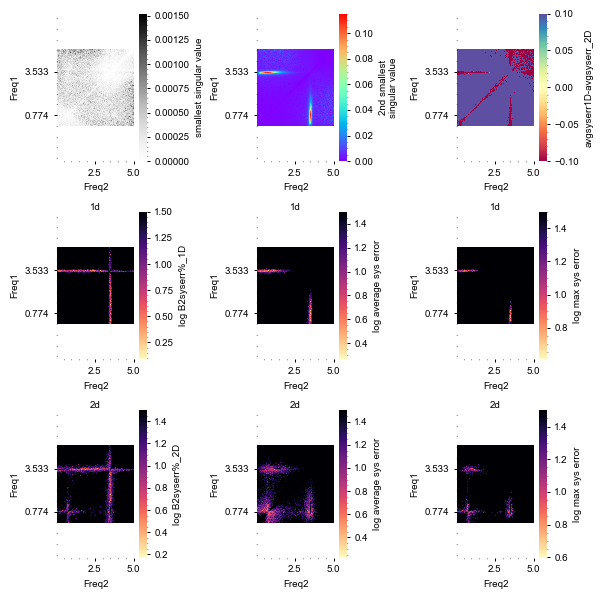

C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


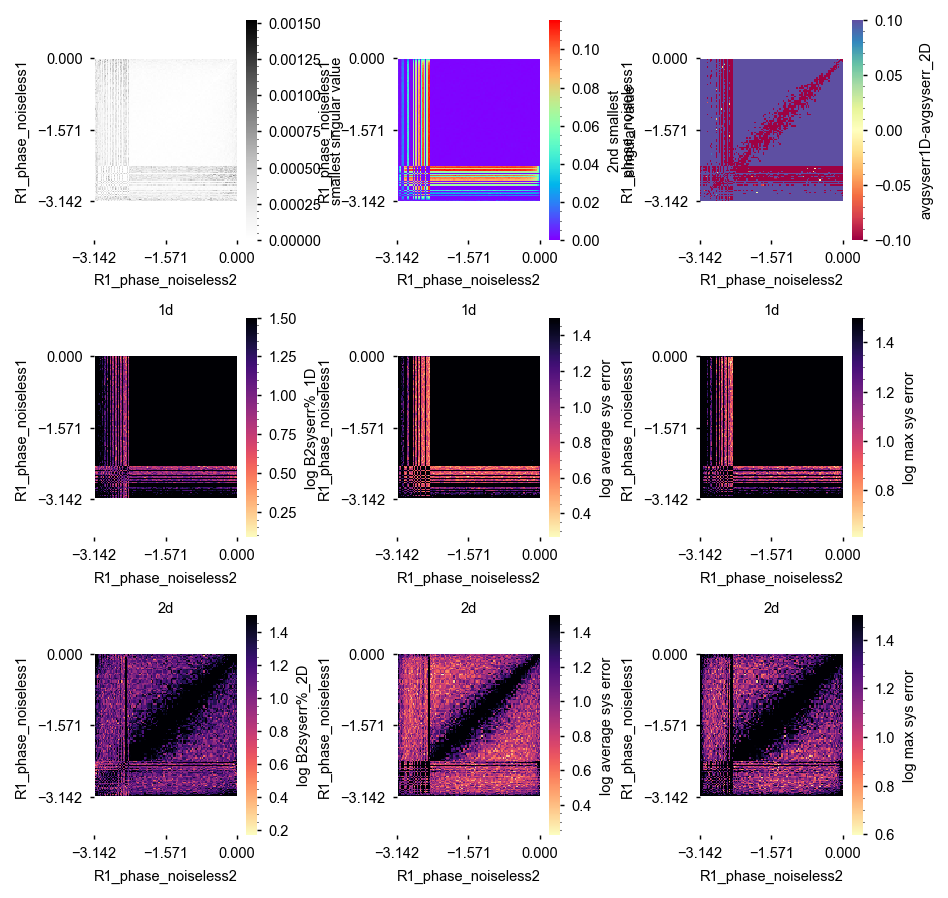

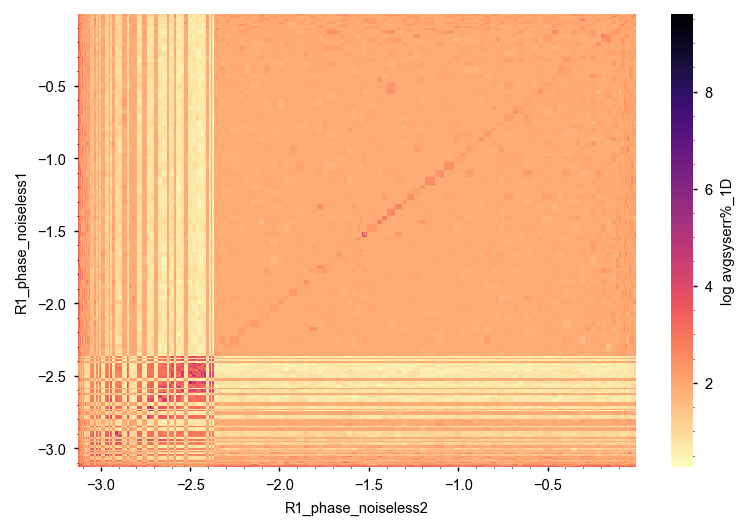

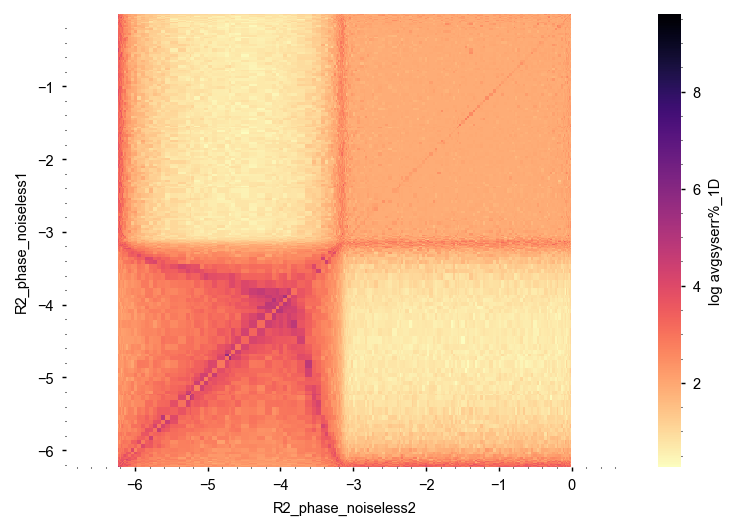

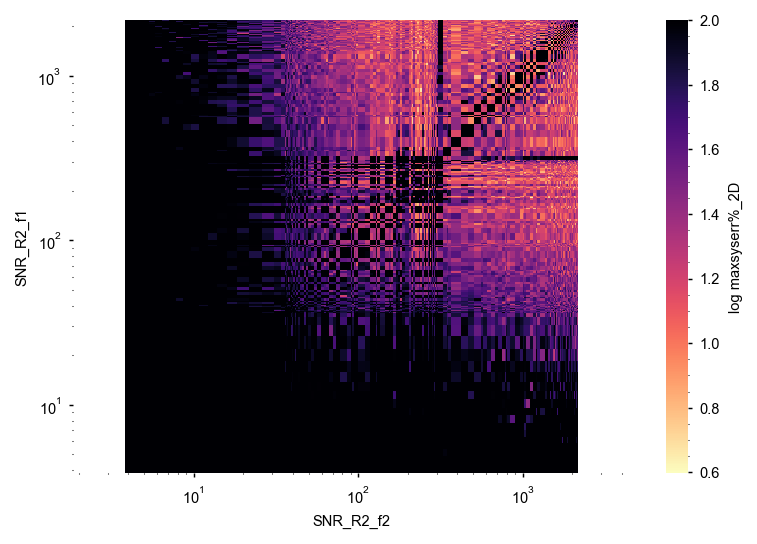

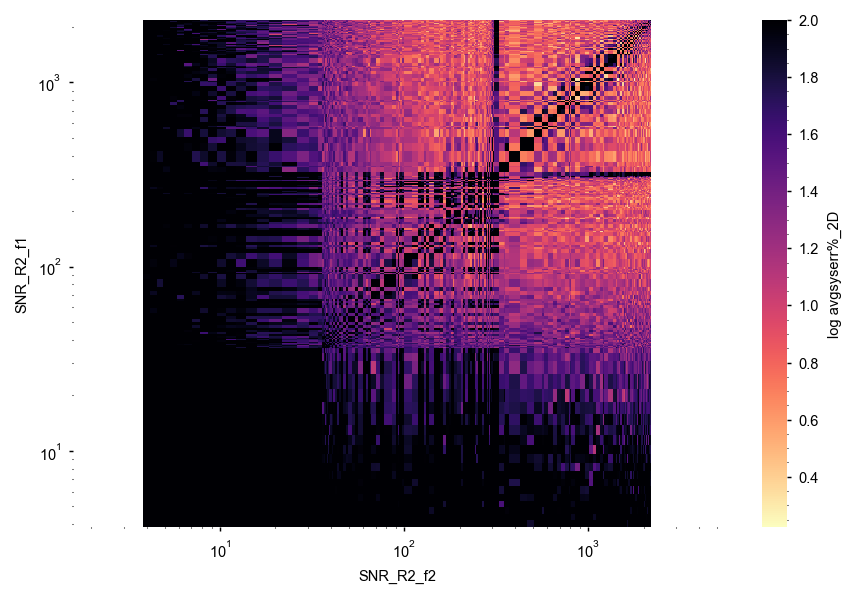

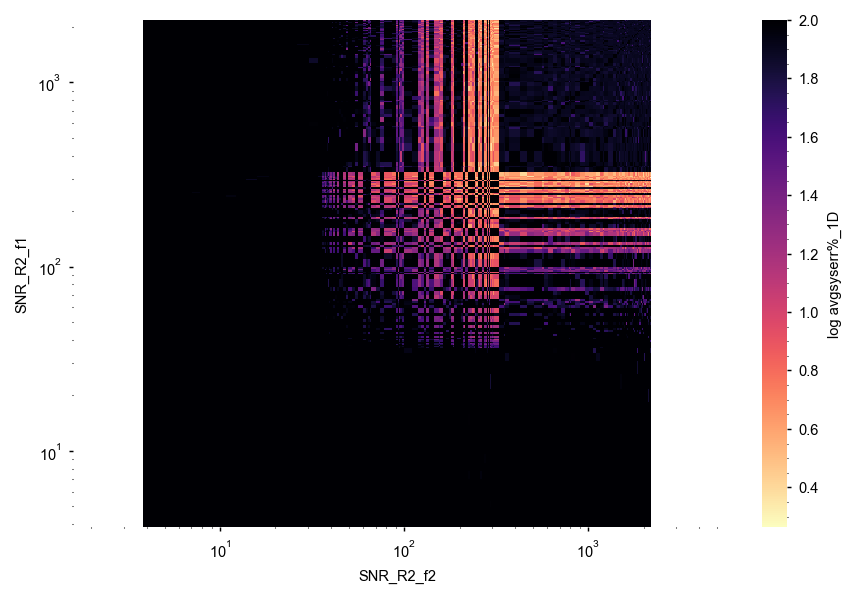

I cut out f1 = f2.


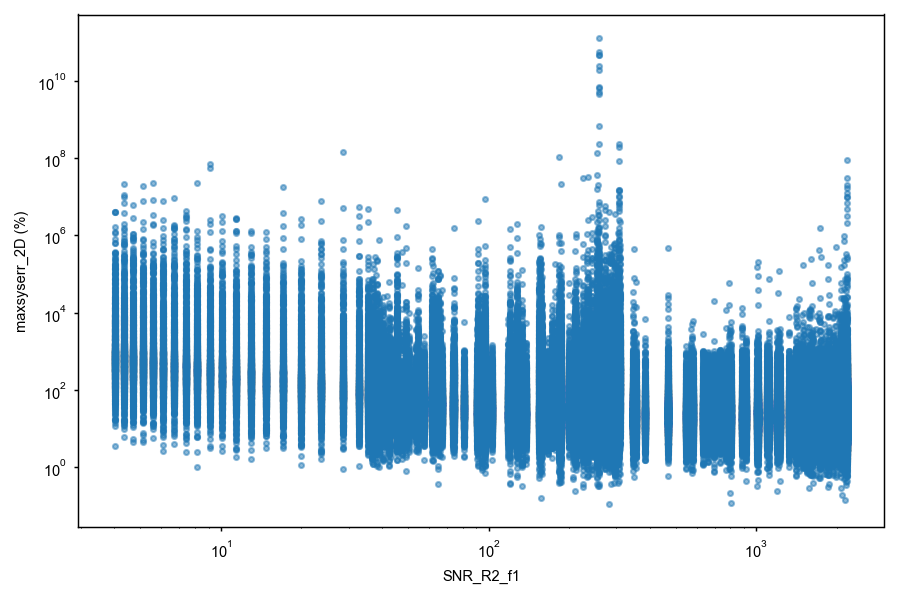

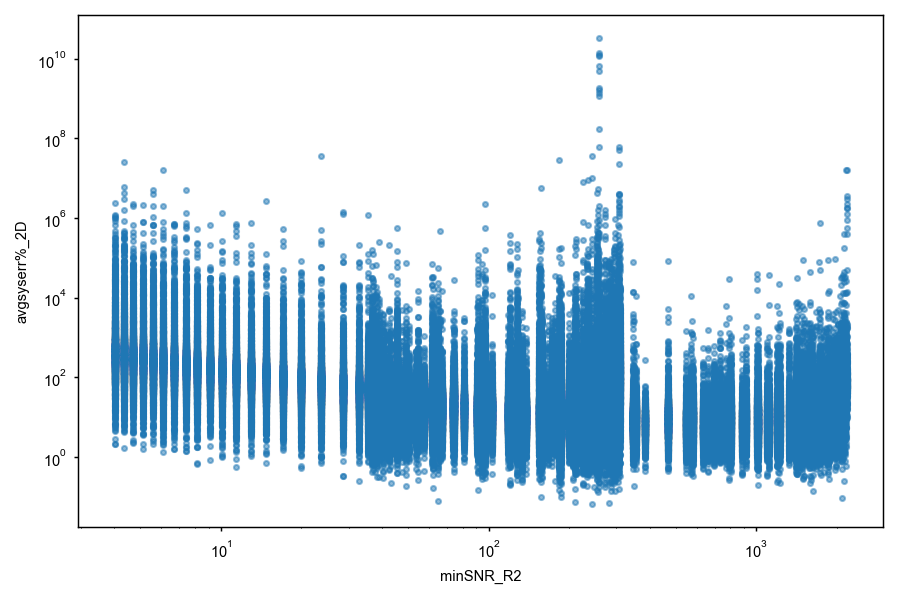

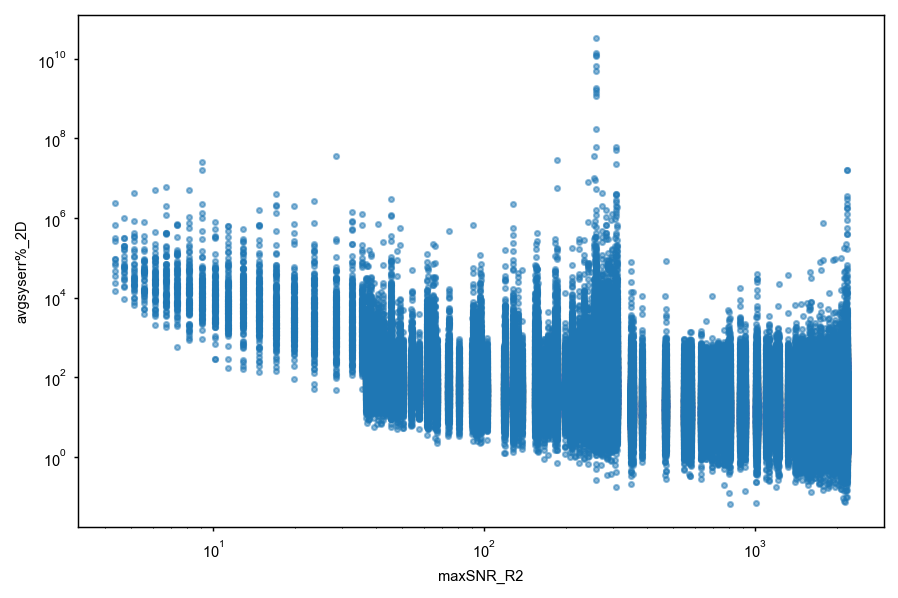

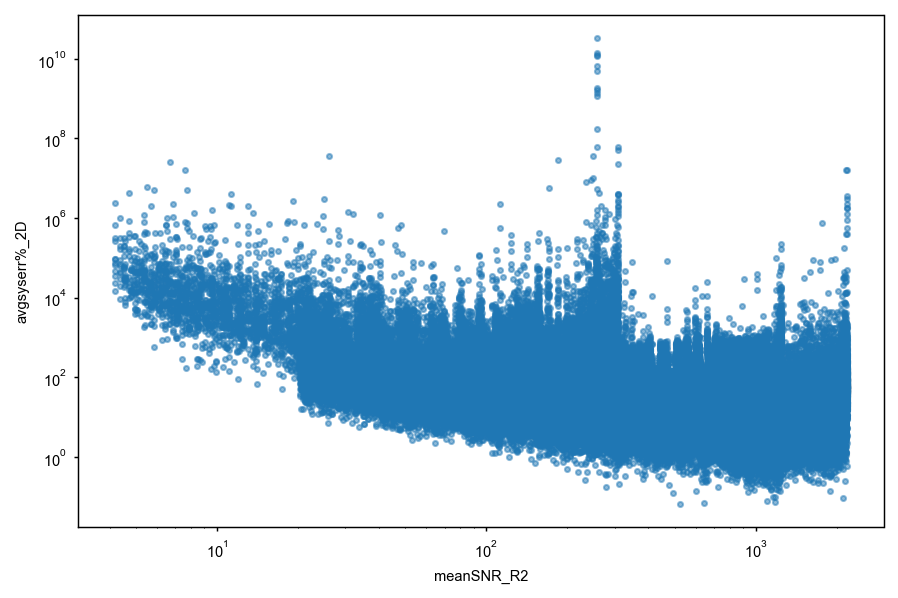

Text(0, 0.5, 'log maxsyserr_2D (%)')

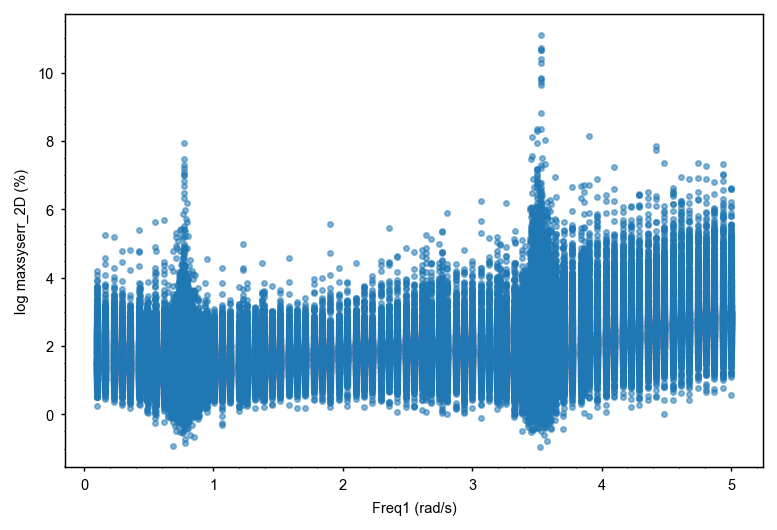

In [20]:
describeresonator(vals_set = vals_set, MONOMER=MONOMER, noiselevel = noiselevel, forceboth = forceboth)
#figsize = (8*3/2,7.7)
#sns.set_context('notebook')
figsize = (6,6)

fig, ((ax1, ax2, ax7), (ax3, ax4, ax4b), (ax5, ax6, ax6b)) = plt.subplots(3, 3, figsize=figsize, dpi=100)

vmax = 1.5

plt.sca(ax1)
lambdagrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambdagrid, "smallest singular value", cmap = 'Greys'); 

plt.sca(ax2)
lambda2grid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'second smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambda2grid, "2nd smallest\nsingular value", cmap = 'rainbow'); 

plt.sca(ax3)
if MONOMER:
    choice = 'B1syserr%'
else:
    choice = 'B2syserr%'
errgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = choice + '_1D').sort_index(axis = 0, ascending = False)
ax,cbar = myheatmap(np.log10(errgrid), choice + '_1D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_1D')
plt.title('1d')

plt.sca(ax4)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax4b)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log maxsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax5)
errgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = choice + '_2D').sort_index(axis = 0, ascending = False)
ax,cbar=myheatmap(np.log10(errgrid), choice + '_2D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_2D')
plt.title('2d')

plt.sca(ax6)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

plt.sca(ax6b)
grid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

    
#plt.figure()
#plt.plot(resultsdf.Freq1,resultsdf.SNR_R2_f1 )

fig.tight_layout()


plt.sca(ax7)
syserrdiffgrid=resultsdfsweep2freqorigmean.pivot_table(index = 'Freq1', 
                                       columns = 'Freq2', 
                                       values = 'avgsyserr%_1D-avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(syserrdiffgrid, "avgsyserr1D-avgsyserr_2D",  cmap='Spectral', vmin = -.1, vmax = .1); 

for ax in [ax1,ax2,ax3,ax4, ax4b, ax5, ax6, ax6b, ax7]:
    plt.sca(ax)
    ax.axis('equal');
    #plt.xticks([res1, res2])
    if res1 == res2:
        plt.yticks([round(resultsdfmean.Freq1.min(),1), round(res1,2), round(resultsdfmean.Freq1.max(),1)])
    else:
        try:
            plt.yticks([res1, res2])
        except:
            pass
plt.tight_layout()
plt.show()

fig, ((ax1, ax2, ax7), (ax3, ax4, ax4b), (ax5, ax6, ax6b)) = plt.subplots(3, 3, figsize=figsize)

#vmax = 3

plt.sca(ax1)
lambdagrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambdagrid, "smallest singular value", cmap = 'Greys'); 

plt.sca(ax2)
lambda2grid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'second smallest singular value').sort_index(axis = 0, ascending = False)
myheatmap(lambda2grid, "2nd smallest\nsingular value", cmap = 'rainbow'); 

plt.sca(ax3)
if MONOMER:
    choice = 'B1syserr%'
else:
    choice = 'B2syserr%'
errgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = choice + '_1D').sort_index(axis = 0, ascending = False)
ax,cbar = myheatmap(np.log10(errgrid), choice + '_1D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_1D')
plt.title('1d')

plt.sca(ax4)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax4b)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log maxsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('1d')

plt.sca(ax5)
errgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = choice + '_2D').sort_index(axis = 0, ascending = False)
ax,cbar=myheatmap(np.log10(errgrid), choice + '_2D', vmax=vmax, cmap='magma_r', return_cbar=True); 
cbar.set_label('log ' + choice + '_2D')
plt.title('2d')

plt.sca(ax6)
SSgrid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(SSgrid, "log average sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

plt.sca(ax6b)
grid=resultsdfsweep2freqorigmean.pivot_table(
    index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log max sys error",  vmax=vmax, cmap='magma_r'); 
plt.title('2d')

    
#plt.figure()
#plt.plot(resultsdf.R1_phase_noiseless1,resultsdf.SNR_R2_f1 )

fig.tight_layout()


plt.sca(ax7)
syserrdiffgrid=resultsdfsweep2freqorigmean.pivot_table(index = 'R1_phase_noiseless1', 
                                       columns = 'R1_phase_noiseless2', 
                                       values = 'avgsyserr%_1D-avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(syserrdiffgrid, "avgsyserr1D-avgsyserr_2D",  cmap='Spectral', vmin = -.1, vmax = .1); 

for ax in [ax1,ax2,ax3,ax4, ax4b, ax5, ax6, ax6b, ax7]:
    plt.sca(ax)
    ax.axis('equal');
    plt.xticks([0, -np.pi/2, -np.pi])
    plt.yticks([0, -np.pi/2, -np.pi])
    
#sns.set_context('talk')


"""plt.figure()
grid=resultsdfmean.pivot_table(index = 'SNR_R2_f1', 
                                       columns = 'SNR_R2_f2', 
                                       values = 'maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "maxsyserr_2D", cmap = 'magma', vmax = .1 );
plt.gca().axis('equal');"""

plt.figure()
grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'R1_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log avgsyserr%_1D", cmap = 'magma_r')#, vmax = 2); 

if not MONOMER:
    plt.figure()
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'R2_phase_noiseless1', columns = 'R2_phase_noiseless2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
    myheatmap(grid, "log avgsyserr%_1D", cmap = 'magma_r')#, vmax = 2); 
    plt.axis('equal')

maxsyserr_to_plot = 1

plt.figure()
if MONOMER:
    #sc = plt.scatter(np.log10(resultsdf.SNR_R1_f2), np.log10(resultsdf.SNR_R1_f1), s=5, 
    #                 c = np.log(resultsdf['maxsyserr%_2D']), cmap = 'magma_r' , alpha = alpha) 
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'SNR_R1_f1', columns = 'SNR_R1_f2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
    #plt.xlabel('log SNR_R1_f2')
    #plt.ylabel('log SNR_R1_f1')
else:
    #sc = plt.scatter(np.log10(resultsdf.SNR_R2_f2), np.log10(resultsdf.SNR_R2_f1), s=5, 
    #                 c = np.log10(resultsdf['maxsyserr%_2D']), cmap = 'magma_r' , alpha = alpha) 
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'SNR_R2_f1', columns = 'SNR_R2_f2', values = 'log maxsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log maxsyserr%_2D", cmap = 'magma_r', vmax = 2); 
#plt.xlabel('SNR_R2_f2')
#plt.ylabel('SNR_R2_f1')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axis('equal');

plt.figure()
if MONOMER:
    grid=resultsdfsweep2freqorigmean.pivot_table(index = 'SNR_R1_f1', columns = 'SNR_R1_f2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
    #plt.xlabel('log SNR_R1_f2')
    #plt.ylabel('log SNR_R1_f1')
else:
    grid=resultsdfsweep2freqorigmean.pivot_table(index = 'SNR_R2_f1', columns = 'SNR_R2_f2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log avgsyserr%_2D", cmap = 'magma_r', vmax = 2); 
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axis('equal');
plt.tight_layout()
plt.show()

plt.figure()
if MONOMER:
    grid=resultsdfsweep2freqorigmean.pivot_table(index = 'SNR_R1_f1', columns = 'SNR_R1_f2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
    #plt.xlabel('log SNR_R1_f2')
    #plt.ylabel('log SNR_R1_f1')
else:
    grid=resultsdfsweep2freqorigmean.pivot_table(index = 'SNR_R2_f1', columns = 'SNR_R2_f2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
myheatmap(grid, "log avgsyserr%_1D", cmap = 'magma_r', vmax = 2); 
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axis('equal');
plt.tight_layout()
plt.show()

## I cut out f1 = f2
plt.figure()
print('I cut out f1 = f2.')
if MONOMER:
    plt.loglog(resultsdf.SNR_R1_f1, resultsdf['maxsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('SNR_R1_f1')
else:
    plt.loglog(resultsdf.SNR_R2_f1, resultsdf['maxsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('SNR_R2_f1') 
plt.ylabel('maxsyserr_2D (%)')
#plt.ylim(ymin=0, ymax=maxsyserr_to_plot)
plt.tight_layout()
plt.show()

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.minSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('minSNR_R1')
else:
    plt.loglog(resultsdf.minSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('minSNR_R2') 
plt.ylabel('avgsyserr%_2D')
plt.tight_layout()
plt.show()

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.maxSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('maxSNR_R1')
else:
    plt.loglog(resultsdf.maxSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('maxSNR_R2') 
plt.ylabel('avgsyserr%_2D')
plt.tight_layout()
plt.show()

plt.figure()
if MONOMER:
    plt.loglog(resultsdf.meanSNR_R1, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('meanSNR_R1')
else:
    plt.loglog(resultsdf.meanSNR_R2, resultsdf['avgsyserr%_2D'], '.', alpha=.5)
    plt.xlabel('meanSNR_R2') 
plt.ylabel('avgsyserr%_2D')
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(resultsdf.Freq1, resultsdf['log maxsyserr%_2D'] , '.', alpha=.5,)
#plt.ylim(ymin=0, ymax=maxsyserr_to_plot)
plt.xlabel('Freq1 (rad/s)')
plt.ylabel('log maxsyserr_2D (%)')
#plt.xticks([res1, res2]);


In [29]:
reslist

[0.773987235127223, 3.501263784075566, 3.504434072345391, 3.5328457422902457, 
3.533838973162194]

In [28]:
resonatorsystem

110

vmin: -0.4709607173913786 , corresponding to  0.338095416077065 %


meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,1D2freqheatmap,2023-03-31 14;23;36.png


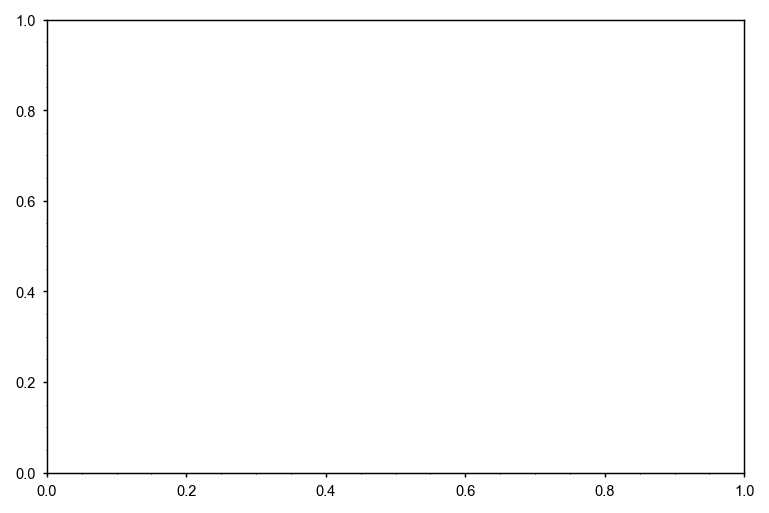

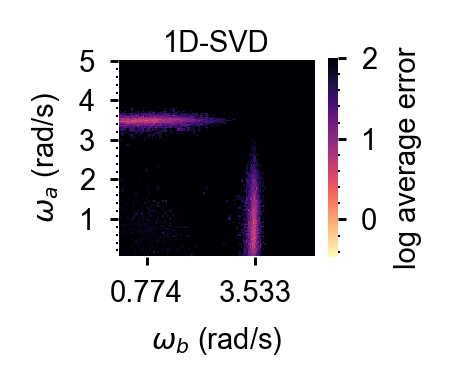

meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,2D2freqheatmap,2023-03-31 14;23;36.png


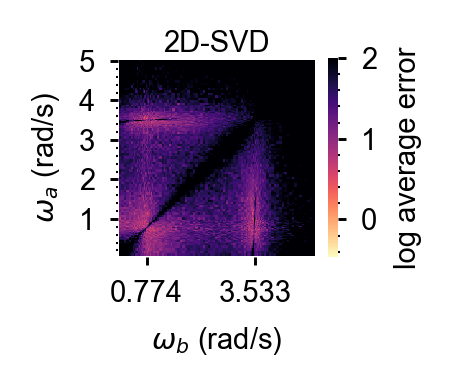

meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,3D2freqheatmap,2023-03-31 14;23;36.png


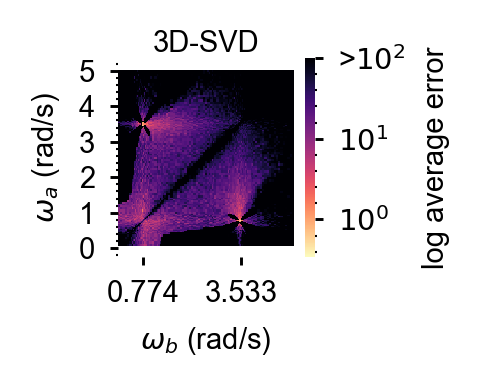

meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,3D-2D-2freqheatmap,2023-03-31 14;23;36.png


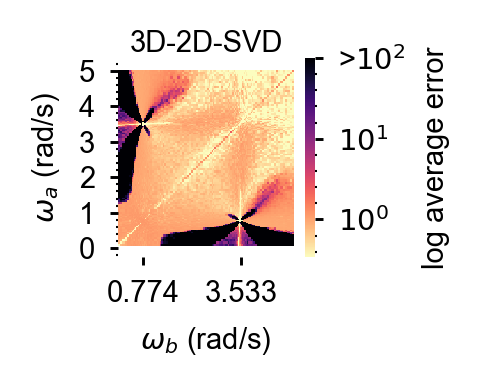

C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


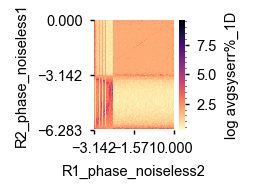

C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


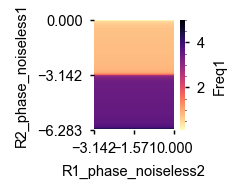

meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,2freq,err_vs_s,2023-03-31 14;23;36.png


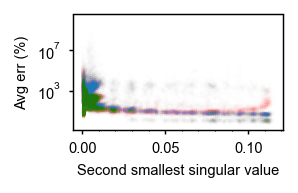

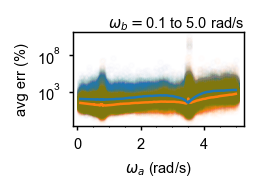

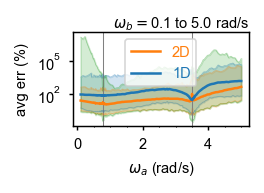

meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,2freqavgerr,2023-03-31 14;23;36.png


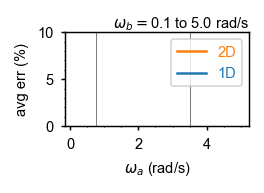

In [34]:
# *****
figsize = (figwidth/2, 1.3)
symb = '.'
lw = 1
datestr = datestring()
roundedres = [round(w,2) for w in reslist[:2]]
ticklist = [round(minfreq),round(maxfreq)] + roundedres
saving = False
do_3D = True
set_format()
saving = True

SSgrid1D=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
SSgrid2D=resultsdfsweep2freqorigmean.pivot_table(
    index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_2D').sort_index(axis = 0, ascending = False)
if do_3D:
    SSgrid3D=resultsdfsweep2freqorigmean.pivot_table(
        index = 'Freq1', columns = 'Freq2', values = 'log avgsyserr%_3D').sort_index(axis = 0, ascending = False)
    vmin = min(SSgrid1D.min().min(), SSgrid2D.min().min(),SSgrid3D.min().min()) # use same scale for all 3
else:
    vmin = min(SSgrid1D.min().min(), SSgrid2D.min().min()) # use same scale for both
vmax = 2
print('vmin:', vmin, ', corresponding to ', 10**vmin, '%')


plt.figure(figsize = (1.555,1.3), dpi= 300 )
myheatmap(SSgrid1D, "log average error", vmin=vmin,  vmax=vmax, cmap='magma_r'); 
plt.title('1D-SVD')
plt.ylabel('$\omega_a$ (rad/s)')
plt.xlabel('$\omega_b$ (rad/s)')
if True: #resonatorsystem == 11 or resonatorsystem == 110:
    #plt.xticks(ticklist)
    #plt.yticks(ticklist)
    #plt.xticks(range(round(maxfreq)+1))
    plt.xticks([res1, res2])
    plt.xticks([], minor = True)
    plt.yticks(range(round(maxfreq)+1))   
plt.axis('equal')
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "1D2freqheatmap," + datestr
    savefigure(savename)
plt.show()

plt.figure(figsize = (1.555,1.3), dpi= 300 )
myheatmap(SSgrid2D, "log average error", vmin=vmin, vmax=vmax, cmap='magma_r'); 
plt.title('2D-SVD')
plt.ylabel('$\omega_a$ (rad/s)')
plt.xlabel('$\omega_b$ (rad/s)')
if True: #resonatorsystem == 11 or resonatorsystem == 110:
    #plt.xticks(ticklist)
    #plt.yticks(ticklist)
    #plt.xticks(range(round(maxfreq)+1))
    plt.xticks([res1, res2])
    plt.xticks([], minor = True)
    plt.yticks(range(round(maxfreq)+1))
plt.axis('equal')
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "2D2freqheatmap," + datestr
    savefigure(savename)
plt.show()

if do_3D:
    plt.figure(figsize = (1.555,1.3), dpi= 300 )
    ax,cbar = myheatmap(SSgrid3D, "log average error",vmin=vmin, vmax=vmax, cmap='magma_r',return_cbar=True); 
    if resonatorsystem == 110:
        cbarticks = [0,1,2]
        cbarticklabels = ['$10^'+str(tick)+'$' for tick in cbarticks]
        cbarticklabels[-1] = '>' + cbarticklabels[-1]
        cbar.set_ticks(cbarticks, labels=cbarticklabels)
    plt.title('3D-SVD')
    plt.ylabel('$\omega_a$ (rad/s)')
    plt.xlabel('$\omega_b$ (rad/s)')
    if True: #resonatorsystem == 11 or resonatorsystem == 110:
        #plt.xticks(ticklist)
        #plt.yticks(ticklist)
        #plt.xticks(range(round(maxfreq)+1))
        plt.xticks([res1, res2])
        plt.xticks([], minor = True)
        plt.yticks(range(round(maxfreq)+1))
    plt.axis('equal')
    plt.tight_layout()
    if saving:
        savename =  "sys" + str(resonatorsystem) + ','+ "3D2freqheatmap," + datestr
        savefigure(savename)
    plt.show()
    
    ## 3D minus 2D
    plt.figure(figsize = (1.555,1.3), dpi= 300 )
    ax,cbar = myheatmap(SSgrid3D-SSgrid2D, "log average error",vmin=vmin, vmax=vmax, cmap='magma_r',return_cbar=True); 
    if resonatorsystem == 110:
        cbarticks = [0,1,2]
        cbarticklabels = ['$10^'+str(tick)+'$' for tick in cbarticks]
        cbarticklabels[-1] = '>' + cbarticklabels[-1]
        cbar.set_ticks(cbarticks, labels=cbarticklabels)
    plt.title('3D-2D-SVD')
    plt.ylabel('$\omega_a$ (rad/s)')
    plt.xlabel('$\omega_b$ (rad/s)')
    if True: #resonatorsystem == 11 or resonatorsystem == 110:
        #plt.xticks(ticklist)
        #plt.yticks(ticklist)
        #plt.xticks(range(round(maxfreq)+1))
        plt.xticks([res1, res2])
        plt.xticks([], minor = True)
        plt.yticks(range(round(maxfreq)+1))
    plt.axis('equal')
    plt.tight_layout()
    if saving:
        savename =  "sys" + str(resonatorsystem) + ','+ "3D-2D-2freqheatmap," + datestr
        savefigure(savename)
    plt.show()

if not MONOMER:
   
    
    plt.figure(figsize = (1.555,1.3) )
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'R2_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
    myheatmap(grid, "log avgsyserr%_1D", cmap = 'magma_r')#, vmax = 2); 
    if resonatorsystem == 11 or resonatorsystem == 110:
        plt.xticks([0, -np.pi/2, -np.pi])
        plt.yticks([0, -np.pi, -2*np.pi])
        
    #plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize = (1.555,1.3) )
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'R2_phase_noiseless1', columns = 'R1_phase_noiseless2', values = 'Freq1').sort_index(axis = 0, ascending = False)
    myheatmap(grid, "Freq1", cmap = 'magma_r')#, vmax = 2); 
    if resonatorsystem == 11 or resonatorsystem == 110:
        plt.xticks([0, -np.pi/2, -np.pi])
        plt.yticks([0, -np.pi, -2*np.pi])
        
    #plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize = (2,1.3))
alpha = .01
ms = .3
resultsdfsweep2freqorigmean_resort_s = resultsdfsweep2freqorigmean.sort_values(by='second smallest singular value')
Xs = resultsdfsweep2freqorigmean_resort_s['second smallest singular value']
plt.plot(Xs, resultsdfsweep2freqorigmean_resort_s['avgsyserr%_3D'], symb, ms = ms, lw=lw, color = co3, alpha = alpha, label = '3D')
plt.plot(Xs, resultsdfsweep2freqorigmean_resort_s['avgsyserr%_2D'], symb, ms = ms, lw=lw, color = co2, alpha = alpha, label = '2D')
plt.plot(Xs, resultsdfsweep2freqorigmean_resort_s['avgsyserr%_1D'], symb, ms = ms, lw=lw, color = co1,  alpha = alpha, label = '1D')
"""plt.plot(X, resultsdfsweep2freqorigmean_resort_s['log avgsyserr%_1D'] -resultsdfsweep2freqorigmean_resort_s['log avgsyserr%_2D']
         , lw=lw, alpha = .5, color = 'k')
"""
plt.xlabel('Second smallest singular value')
plt.yscale('log')
if resonatorsystem == -3:
    plt.yticks([1e4,1e2, 1e0, 1e-2])
#text_color_legend(ncol=3)
plt.ylabel('Avg err (%)');
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "2freq,err_vs_s," + datestr
    savefigure(savename)
    resultsdfsweep2freqorigmean_resort_s[['second smallest singular value',
                                          'log avgsyserr%_1D',
                                          'log avgsyserr%_2D', 
                                          'log avgsyserr%_3D']].to_csv(savename + '.csv')
plt.show()

resultsdfmeanbyfreq1 = resultsdf.groupby(by=['Freq1'], as_index=False).mean(numeric_only =True)
X = resultsdfmeanbyfreq1['Freq1'] 

plt.figure(figsize=figsize)
#plt.plot(resultsdf.Freq1, resultsdf['avgsyserr%_3D'] , '.', alpha=.008, color = co3)
plt.plot(resultsdf.Freq1, resultsdf['avgsyserr%_1D'] , '.', alpha=.008, color = co1)
plt.plot(resultsdf.Freq1, resultsdf['avgsyserr%_2D'] , '.', alpha=.008,  color = co2)
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_2D'], color = co2, label='2D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_1D'], color = co1,label='1D')
#plt.ylim(ymin=0, ymax=maxsyserr_to_plot)
plt.title('$\omega_b = $' + str(round(resultsdfmean.Freq2.min(),1)) + ' to ' 
              + str(round(resultsdfmean.Freq2.max(),1)) + ' rad/s',
          loc='right')
plt.xlabel('$\omega_a$ (rad/s)')
plt.ylabel('avg err (%)')
plt.yscale('log')
#plt.xticks([res1, res2]);
plt.tight_layout()
plt.show()


plt.figure(figsize=figsize)

plt.axvline(reslist[0], color='gray', lw=0.5)
if not MONOMER:
    plt.axvline(reslist[1], color='gray', lw=0.5)

axa=plt.gca()
colors = [co1, co2, co3]
dimensions =  ['1D', '2D', '3D']
if resonatorsystem == -3:
    dim = ['1D', '2D']
else:
    dim = dimensions

# initialize 95% confidence interval columns
for column in ['E_lower_1D', 'E_upper_1D','E_95range_1D','E_log95range_1D'\
               'E_lower_2D', 'E_upper_2D', 'E_95range_2D', 'E_log95range_2D'\
               'E_lower_3D', 'E_upper_3D', 'E_95range_3D','E_log95range_3D']:
    resultsdfmeanbyfreq1[column] = np.nan
    
for f1 in resultsdfmeanbyfreq1['Freq1']:
    for D in dimensions: # ASE stands for average systematic err
        #plt.hist(resultsvaryFreq2[resultsvaryFreq2['Freq2']== f1]['avgsyserr%_1D'])
        ASE = resultsdf[resultsdf['Freq1']== f1]['avgsyserr%_' + D]
        ASE = np.sort(ASE)
        halfalpha = (1 - .95)/2
        ## literally select the 95% confidence interval by tossing out the top 2.5% and the bottom 2.5% 
        ## I could do a weighted average to work better with selecting the top 2.5% and bottom 2.5%
        ## But perhaps this is good enough for an estimate. It's ideal if I do 80 measurements.
        lowerbound = np.mean([ASE[int(np.floor(halfalpha*len(ASE)))], ASE[int(np.ceil(halfalpha*len(ASE)))]])
        #print(lowerbound)
        upperbound = np.mean([ASE[-int(np.floor(halfalpha*len(ASE))+1)],ASE[-int(np.ceil(halfalpha*len(ASE))+1)]])
        resultsdfmeanbyfreq1.loc[resultsdfmeanbyfreq1['Freq1']== f1,'E_95range_'+ D] = upperbound - lowerbound
        resultsdfmeanbyfreq1.loc[resultsdfmeanbyfreq1['Freq1']== f1,'E_log95range_'+ D] = np.log10(upperbound) - np.log10(lowerbound)
        resultsdfmeanbyfreq1.loc[resultsdfmeanbyfreq1['Freq1']== f1,'E_lower_'+ D] = lowerbound
        resultsdfmeanbyfreq1.loc[resultsdfmeanbyfreq1['Freq1']== f1,'E_upper_' + D] = upperbound


for i in range(len(dim)): 
        Yhigh = resultsdfmeanbyfreq1['E_upper_' + dim[i]]
        Ylow = resultsdfmeanbyfreq1['E_lower_' + dim[i]]                            
        plt.plot(X, Yhigh, color = colors[i], alpha = .3, linewidth=.3)
        plt.plot(X, Ylow, color = colors[i], alpha = .3, linewidth=.3)
        axa.fill_between(X, Ylow, Yhigh, color = colors[i], alpha=.2)
#plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_3D'], color = co3, label='3D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_2D'], color = co2, label='2D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_1D'], color = co1,label='1D')
plt.yscale('log')
text_color_legend()
plt.title('$\omega_b = $' + str(round(resultsdfmean.Freq2.min(),1)) + ' to ' 
              + str(round(resultsdfmean.Freq2.max(),1)) + ' rad/s',
          loc='right')
plt.xlabel('$\omega_a$ (rad/s)')
plt.ylabel('avg err (%)')
plt.tight_layout()
plt.show()

plt.figure(figsize = figsize)
plt.axvline(reslist[0], color='gray', lw=0.5)
if not MONOMER:
    plt.axvline(reslist[1], color='gray', lw=0.5)
#plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_3D'], color = co3, label='3D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_2D'], color = co2, label='2D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_1D'], color = co1,label='1D')
text_color_legend()
#plt.yscale('log')
#plt.ylim(ymin=0)
plt.ylim(ymin=0, ymax=10)
plt.title('$\omega_b = $' + str(round(resultsdfmean.Freq2.min(),1)) + ' to ' 
              + str(round(resultsdfmean.Freq2.max(),1)) + ' rad/s',
          loc='right')
plt.xlabel('$\omega_a$ (rad/s)')
plt.ylabel('avg err (%)');
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "2freqavgerr," + datestr
    savefigure(savename)
    resultsdfmeanbyfreq1[['Freq1','log avgsyserr%_1D','log avgsyserr%_2D', 'log avgsyserr%_3D']].to_csv(savename + '.csv')
plt.show()

<>:12: DeprecationWarning: invalid escape sequence \p
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\vhorowit\Anaconda3\lib\site-packages\matplotlib\ticker.py:2954: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
meta NOT subset; don't know how to subset; dropped


Saved:
 sys110,1D_heatmap_by_phase,2023-03-31 14;15;18.png


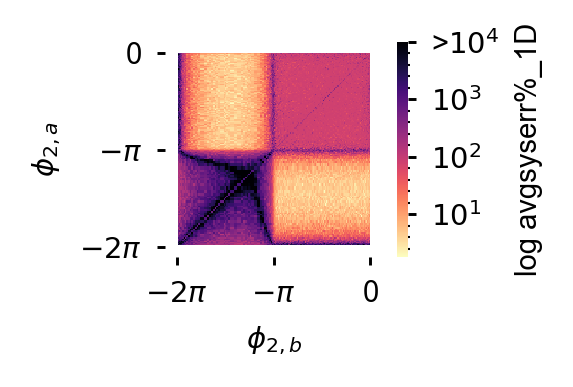

In [32]:
if not MONOMER:
    plt.figure(figsize = (1.8,1.3), dpi= 300 ) # *** new subfigure
    grid=resultsdfsweep2freqorigmean.pivot_table(
        index = 'R2_phase_noiseless1', columns = 'R2_phase_noiseless2', values = 'log avgsyserr%_1D').sort_index(axis = 0, ascending = False)
    ax,cbar = myheatmap(grid, "log avgsyserr%_1D", vmax = 4, cmap = 'magma_r', return_cbar=True)#, vmax = 2); 
    cbarticks = [1,2,3,4]
    cbarticklabels = ['$10^'+str(tick)+'$' for tick in cbarticks]
    cbarticklabels[-1] = '>' + cbarticklabels[-1]
    cbar.set_ticks(cbarticks, labels=cbarticklabels)
    if resonatorsystem == 11 or resonatorsystem == 110:
        plt.xlim(0, 2*np.pi)
        plt.xticks([0, -np.pi, -2*np.pi], labels = ['0','$-\pi$', '$-2\pi$'])
        plt.yticks([0, -np.pi, -2*np.pi], labels = ['0','$-\pi$', '$-2\pi$'])
    plt.xlabel('$\phi_{2,b}$')
    plt.ylabel('$\phi_{2,a}$')
        
    plt.axis('equal')
    plt.tight_layout()
    if True:
        savename =  "sys" + str(resonatorsystem) + ','+ "1D_heatmap_by_phase," + datestr
        savefigure(savename)
    plt.show()
    
    
    # *** Do I need to add '1D-SVD' title?

In [ ]:
plt.figure(figsize = figsize)
plt.axvline(reslist[0], color='gray', lw=0.5)
if not MONOMER:
    plt.axvline(reslist[1], color='gray', lw=0.5)
#plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_3D'], color = co3, label='3D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_2D'], color = co2, label='2D')
plt.plot(X, 10**resultsdfmeanbyfreq1['log avgsyserr%_1D'], color = co1,label='1D')
text_color_legend()
#plt.yscale('log')
plt.ylim(ymin=0, ymax=100)
plt.title('$\omega_b = $' + str(round(resultsdfmean.Freq2.min(),1)) + ' to ' 
              + str(round(resultsdfmean.Freq2.max(),1)) + ' rad/s',
          loc='right')
plt.xlabel('$\omega_a$ (rad/s)')
plt.ylabel('avg err (%)');
plt.tight_layout()
if saving:
    savename =  "sys" + str(resonatorsystem) + ','+ "2freqavgerr," + datestr
    savefigure(savename)
    resultsdfmeanbyfreq1[['Freq1','log avgsyserr%_1D','log avgsyserr%_2D', 'log avgsyserr%_3D']].to_csv(savename + '.csv')
plt.show()

In [ ]:
print('The average error varies over two orders of magnitude.')
plt.plot(resultsdfmeanbyfreq1.Freq1,resultsdfmeanbyfreq1.E_log95range_1D)
plt.plot(resultsdfmeanbyfreq1.Freq1,resultsdfmeanbyfreq1.E_log95range_2D)

plt.xlabel('Freq1 (rad/s)')
plt.ylabel('Number of orders of magnitude');

In [ ]:
with pd.option_context('display.max_rows', None,):
    display(resultsdf[245:249].transpose())

In [ ]:
"""print('The most likely frequency pair to be 1d nullspace:')"""

#labellists
if MONOMER:
    elemslist = ['M1', 'B1', 'K1', 'FD']
    bardisplaylabels =  ['K1', 'B1','FD','M1','avg', 'rms']
else:
    elemslist = ['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD']
    bardisplaylabels =  ['K1', 'K2', 'K12','B1','B2','FD','M1','M2','avg', 'rms']
elemslist_2D = [el + '_2D' for el in elemslist]
elemslist = [el+ '_1D' for el in elemslist]
llist1 = ['Freq1', 'Freq2', 'R1_phase_noiseless1', 'R1_phase_noiseless2', 'avgsyserr%_1D-avgsyserr%_2D', 'rmssyserr%_1D', 'rmssyserr%_2D'] +  elemslist + elemslist_2D
syserrlist = [w + 'syserr%' for w in bardisplaylabels]
syserrlist_2D = [w + '_2D' for w in syserrlist]
syserrlist = [w + '_1D' for w in syserrlist]

min_df = resultsdfsweep2freqorigmean.iloc[resultsdfsweep2freqorigmean['avgsyserr%_1D-avgsyserr%_2D'].argmin()] # most likely to be 1d nullspace
display(min_df[llist1])
#min_df[['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D',]]

def grapherror_1D_2D(syserrdf, bardisplaylabels, syserrlist, syserrlist_2D ):
    X = np.arange(len(bardisplaylabels))
    fig, ax = plt.subplots()
    ax.bar(X + 0.2,syserrdf[syserrlist], color = 'b', width = 0.3)
    ax.set_xticks(X+ 0.25, bardisplaylabels)
    ax.bar(X + 0.50, syserrdf[syserrlist_2D], color = 'r', width = 0.3)
    plt.title('syserrs: 1d blue, 2d red');
    

grapherror_1D_2D(min_df, bardisplaylabels, syserrlist, syserrlist_2D )
plt.show()

"""print('1D nullspace')
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,convert_to_measurementdf(min_df),  
                 min_df.K1_1D, min_df.K2_1D, min_df.K12_1D, min_df.B1_1D, min_df.B2_1D, min_df.FD_1D, min_df.M1_1D, min_df.M2_1D,
                 MONOMER=MONOMER, forceboth=forceboth,saving=savefig)
plt.show()"""
print('The above is likely to be quite a poor choice of frequencies, since it was selected for having poor 2d nullspace results')

In [ ]:
"""with pd.option_context('display.max_rows', None,):
    display(min_df)""";

In [ ]:
best_df = resultsdfsweep2freqorigmean.iloc[resultsdfsweep2freqorigmean['avgsyserr%_1D'].argmin()] # most likely to be good
display(best_df[llist1])
print('Best 1d results (lowest average err):')
grapherror_1D_2D(best_df, bardisplaylabels, syserrlist, syserrlist_2D )
plt.ylabel('Err (%)')
plt.show()

'''print('1D nullspace, best choice of two frequencies')
plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase,convert_to_measurementdf2(best_df),  
                 best_df.K1_2D, best_df.K2_2D, best_df.K12_2D, best_df.B1_2D, best_df.B2_2D, 
                 best_df.FD_2D, best_df.M1_2D, best_df.M2_2D,
                 MONOMER=MONOMER, forceboth=forceboth,saving=savefig)
plt.show()'''
print('1D nullspace, best choice of two frequencies')

# -0.4 pi 
# and
# -.12 pi

# or

# -0.74 pi
# and
# -0.454 pi  (-5/11 pi)


In [ ]:
stophere# next sweep one frequency (called freq2) (vary one freq) / sweep freq2

In [ ]:
try:
    del results_sweep_1freq
except NameError:
    pass

try:
    del results_sweep_2freq
except NameError:
    pass

for i in range(10): # really nail down that fixed frequency
    res1 = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth, numtoreturn = 1, includefreqs = res1,
                           verboseplot = False, verbose=False, iterations = 5, mode = 'amp')
res1 = res1[0]
reslist = [res1,res2]
reslist

In [ ]:
resonatorsystem

In [ ]:
#Code that loops through frequency 2 points (of different spacing)

verbose = True
repeats = 80
n = 200

def sweep_freq2(freq1,drive=drive, vals_set = vals_set, 
                noiselevel = noiselevel, MONOMER=MONOMER, freq3=None, repeats=repeats):

    print('Running sweep_freq2 with', repeats, 'repeats: Sweeping freq2 with', len(drive), 'frequencies from', min(drive), 'to', max(drive), 
          'while holding freq1 fixed at', freq1)
    if freq3 is not None:
        print('Holding freq3 fixed at', freq3)
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp, privilegedrsqrd = \
        calculate_spectra(drive, vals_set, noiselevel = noiselevel, MONOMER = MONOMER, forceboth=forceboth)

    # initate array for results
    results = []

    SNR_R1_f1,SNR_R2_f1 = SNRknown(freq1,vals_set = vals_set,  noiselevel = noiselevel, MONOMER=MONOMER, forceboth=forceboth)
    
    if freq3 is None:
        SNR_R1_f3,SNR_R2_f3 = np.nan, np.nan
    else:
        SNR_R1_f3,SNR_R2_f3 = SNRknown(freq3,vals_set = vals_set, noiselevel = noiselevel)

    for i2 in range(len(drive)):
        freq2 = drive[i2]
        if freq2 == freq1:
            continue     # Don't run if the two frequencies are the same number; they have to be distinct.

        if freq3 is None:
            freqs = [freq1, freq2]
        else:
            freqs = [freq1, freq2, freq3]
        
        thisres = simulated_experiment(freqs, drive=drive,vals_set = vals_set, 
                                       noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth,
                                       repeats=repeats , verbose = False)
        try: # repeated experiments results
            resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
        except:
            resultsdf = thisres
        
    return resultsdf

# true curves
if MONOMER:
    fig, ax5 = plt.subplots()
    twirlax = [ax5]
else:
    fig, (ax5, ax6) = plt.subplots(1,2)
    twirlax = [ax5,ax6]
#morefrequencies = np.linspace(0.01, 5, num = n*100)
ax5.plot(realamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth), 
         imamp1(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth), 
         color='gray', alpha = .5)
plt.title('R1 complex amplitude')
if not MONOMER:
    ax6.plot(realamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth), 
             imamp2(morefrequencies, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth), 
             color='gray', alpha = .5)
    plt.title('R2 complex amplitude')
for ax in twirlax:
    ax.axis('equal');
    
if resonatorsystem == 11:
    minfreq = 2.5
    maxfreq = 4.5
else:
    minfreq = None
    maxfreq = None
    

## Choose driving frequencies
chosendrive, morefrequencies = create_drive_arrays(vals_set = vals_set, forceboth=forceboth, includefreqs = reslist,
                                                   minfreq = minfreq, maxfreq = maxfreq,
                                                     MONOMER = MONOMER, n=n, morefrequencies = morefrequencies)

plt.figure()
plt.plot(chosendrive, theta1(chosendrive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                             e=0, MONOMER=MONOMER, forceboth=forceboth), '.')
plt.xlabel('Freq2')
plt.ylabel('R1 phase')

reset_ideal_freq3 = False
if reset_ideal_freq3:
    ### Run first to figure out ideal 2-frequency
    print('Running first to figure out ideal 2-frequency pair')
    before = time()
    repeats = 50
    for i in range(1):
        thisres = sweep_freq2(freq1 = res1,drive=chosendrive, vals_set = vals_set,  noiselevel = noiselevel, MONOMER=MONOMER, 
                              freq3=None, repeats = repeats)
        try:
            results_sweep_2freq = pd.concat([results_sweep_2freq,thisres], ignore_index=True)
        except:
            results_sweep_2freq = thisres
    after = time()
    printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
    #display(results_sweep_2freq.transpose())

    results_sweep_2freq= results_sweep_2freq.sort_values(by='Freq2')
    results_sweep_2freqmean = results_sweep_2freq.groupby(by=['Freq2']).mean()
    results_sweep_2freqmean['Freq2'] = results_sweep_2freqmean.index
    min1dsyserrFreq2_2freq = results_sweep_2freqmean[['avgsyserr%_1D']].idxmin()[0]
    min2dsyserrFreq2_2freq = results_sweep_2freqmean[['avgsyserr%_2D']].idxmin()[0]
    
    ase1 = results_sweep_2freq[results_sweep_2freq.Freq2 == min1dsyserrFreq2_2freq].avgsyserr_1D
    ase2 = results_sweep_2freq[results_sweep_2freq.Freq2 == min2dsyserrFreq2_2freq]['avgsyserr%_2D']
    print('Min syserr for 1D-SVD at freq2: ' + str(min1dsyserrFreq2_2freq) + 
          ' and syserr is (' + str(ase1.mean()) + ' ± ' + str(np.std(ase1, ddof=1)) + ')%.')
    print('Min syserr for 2D-SVD at freq2: ' + str(min2dsyserrFreq2_2freq) + 
          ' and syserr is (' + str(ase2.mean()) + ' ± ' + str(np.std(ase2, ddof=1)) + ')%, where unc is stdev.')
    display(results_sweep_2freqmean.loc[[min1dsyserrFreq2_2freq,min2dsyserrFreq2_2freq]])
    
    """
    Min syserr for 1D-SVD at freq2: 1.6404682274247495 and syserr is (0.0734650018103787 ± 0.045038046711051355)%
    Min syserr for 2D-SVD at freq2: 1.4274247491638798 and syserr is (0.10339372883608478 ± 0.07059220476370268)%
    """
    
    try:
        del results_sweep_1freq
        print('Cleared results_sweep_1freq so we can run it with a new pair of frequencies.')
    except NameError:
        pass

"""try:
    freq3 = min1dsyserrFreq2_2freq
except NameError:
    freq3 = 1.6404682274247495"""
freq3 = None ## Just run with two frequencies!

### Run second to figure out ideal 3-frequency or Run once to figure out ideal 2-frequency
# Ran 50 times in 21.149 sec
before = time()
print('Running with fixed freqs: ' + str(res1) + ', ' + str(freq3))
for i in range(1):
    thisres = sweep_freq2(freq1 = res1,drive=chosendrive, vals_set = vals_set,  noiselevel = noiselevel, MONOMER=MONOMER, 
                          freq3=freq3, repeats = repeats)
    try:
        results_sweep_1freq = pd.concat([results_sweep_1freq,thisres], ignore_index=True)
    except:
        results_sweep_1freq = thisres
after = time()
printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
display(results_sweep_1freq.transpose())

results_sweep_1freq = results_sweep_1freq.sort_values(by='Freq2')
results_sweep_1freqmean = results_sweep_1freq.groupby(by=['Freq2']).mean()
results_sweep_1freqmean['Freq2'] = results_sweep_1freqmean.index
min1dsyserrFreq2 = results_sweep_1freqmean[['avgsyserr%_1D']].idxmin()[0]
min2dsyserrFreq2 = results_sweep_1freqmean[['avgsyserr%_2D']].idxmin()[0]

ase1B = (results_sweep_1freq[results_sweep_1freq.Freq2 == min1dsyserrFreq2])['avgsyserr%_1D']
ase2B = (results_sweep_1freq[results_sweep_1freq.Freq2 == min2dsyserrFreq2])['avgsyserr%_2D']
print('Min syserr for 1D-SVD at freq2: ' + str(min1dsyserrFreq2) + 
      ' and syserr is (' + str(ase1B.mean()) + ' ± ' + str(np.std(ase1B, ddof=1)) + ')%')
print('Min syserr for 2D-SVD at freq2: ' + str(min2dsyserrFreq2) + 
      ' and syserr is (' + str(ase2B.mean()) + ' ± ' + str(np.std(ase2B, ddof=1)) + ')%, where unc is std.')
display(results_sweep_1freqmean.loc[[min1dsyserrFreq2,min2dsyserrFreq2]])

"""
Triplet is not an improvement.
Min syserr for 1D-SVD at freq2: 1.4274247491638798 and syserr is (0.07608640402852421 ± 0.04183324629642049)%
Min syserr for 2D-SVD at freq2: 1.6896321070234117 and syserr is (0.11534287254582937 ± 0.08651068682603497)%, where unc is std.
"""

freq_label = find_freq_from_angle(results_sweep_1freq.Freq2,
                                  phase = theta1(results_sweep_1freq.Freq2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 
                                                 0, MONOMER=MONOMER, forceboth=forceboth),
                                  angleswanted = [-np.pi/4, -np.pi/2,  -3*np.pi/4])
freq_label.append(res1)
if not MONOMER:
    freq_label.append(res2)
freq_label.append(min1dsyserrFreq2)
freq_label.append(min2dsyserrFreq2)
if freq3 is not None:
    freq_label.append(freq3)
#freq_label = np.unique(np.array(freq_label))
"""
plotcomplex(complexZ = results_sweep_1freq.R1_amp_meas2, parameter = results_sweep_1freq.Freq2, ax = ax5, 
            label_markers = freq_label)
if not MONOMER:
    plotcomplex(complexZ = results_sweep_1freq.R2_amp_meas2, parameter = results_sweep_1freq.Freq2, ax = ax6)
    #ax6.plot(np.real(results_sweep_1freq.R2AmpCom2), np.imag(results_sweep_1freq.R2AmpCom2), '.')
    """

In [ ]:
_, d1, _, d2, _, _, _, _, _ = calculate_spectra(np.array(res1), vals_set, noiselevel, MONOMER, forceboth)

In [ ]:
# some thoughts about alpha transparency
"""1000 -> .1
5400 -> .03""";
repeats = len(results_sweep_1freq)
repeats

In [ ]:
repeats % 80 # want this to be 0

In [ ]:
results_sweep_1freq, results_sweep_1freqmean = \
    calc_error_interval(results_sweep_1freq, results_sweep_1freqmean, groupby='Freq2', fractionofdata = .95)


In [ ]:
#list(results_sweep_1freq.columns)

In [ ]:
from matplotlib.ticker import AutoLocator
widths=.03 # widths of boxplots
if True:
    lw=1
    figsize=(15, 5)
    if repeats > 100:
        alpha=.03
    elif repeats > 50:
        alpha=.1
    elif repeats > 25:
        alpha=.3
    else:
        alpha=.5
    ms = 10
else:
    lw = 1
    ms = 2
    figsize = (3.2, 1.3)
    if repeats > 20000:
        alpha = .003
    elif repeats > 100:
        alpha=.03
    elif repeats > 50:
        alpha=.1
    elif repeats > 25:
        alpha=.3
    else:
        alpha=.5
symb='.'

if MONOMER:
    Rnote = ''
else:
    Rnote = ' at R1'


results_sweep_1freq.boxplot(column='log avgsyserr%_2D', by='Freq2', grid=False, #fontsize=7, rot=90, 
                             positions=results_sweep_1freq.Freq2.unique(), widths=widths, 
                             #color='k', 
                             showmeans=True, 
                            figsize=figsize);
plt.ylabel('log avgsyserr 2D');
plt.title('');
#plt.xticks([minfreq, maxfreq] + [round(w,3) for w in reslist])
#plt.xticks(range(maxfreq+1))
plt.gca().xaxis.set_major_locator(AutoLocator()) 
plt.show()

results_sweep_1freq.boxplot(column='log avgsyserr%_1D', 
                            by='Freq2',
                            #by = 'R1Phase2_wrap',
                            grid=False, #fontsize=7, rot=90, 
                             positions=results_sweep_1freq.Freq2.unique(), widths=widths, 
                             #color='k', 
                             showmeans=True, 
                            figsize=figsize);
plt.ylabel('log avgsyserr 1D');
#plt.xticks([minfreq, maxfreq] + [round(w,3) for w in reslist])
plt.gca().xaxis.set_major_locator(AutoLocator()) 
plt.title('');

plt.figure(figsize=figsize) # remove this to overplot the boxplots
plt.axvline(res1, color='grey')
plt.plot(results_sweep_1freq.Freq2, results_sweep_1freq['avgsyserr%_2D'], '.', 
         ms = ms, color=co2, alpha=alpha )
plt.plot(results_sweep_1freq.Freq2, results_sweep_1freq['avgsyserr%_1D'], '.', 
         ms = ms, color=co1, alpha=alpha)
plt.plot(results_sweep_1freqmean.Freq2, 10**results_sweep_1freqmean['log avgsyserr%_2D'], color=co2, lw=lw, label='2D' )
plt.plot(results_sweep_1freqmean.Freq2, 10**results_sweep_1freqmean['log avgsyserr%_1D'], color=co1, lw=lw, label='1D')
plt.xlabel('Freq2')
text_color_legend()
plt.ylabel('Avg err (%)');
plt.yscale('log')
plt.show()

beep()

In [ ]:
figsize = (8,4)

if MONOMER:
    Rnote = ''
    x_axis_phase = 'R1Phase2_wrap'
else:
    x_axis_phase = 'R2Phase2_wrap'
    Rnote = ' at R2'


plt.figure(figsize=figsize) 
# calculations
results_sweep_1freq[x_axis_phase]=results_sweep_1freq.R1_phase_noiseless2%(2*np.pi) - 2*np.pi
results_sweep_1freq_resort1=results_sweep_1freq.sort_values(by=x_axis_phase)
results_sweep_1freq_resort1mean=results_sweep_1freq_resort1.groupby(by=['Freq2'], as_index=False).mean()

results_sweep_1freq, results_sweep_1freq_resort1mean = \
    calc_error_interval(results_sweep_1freq, results_sweep_1freq_resort1mean, groupby='Freq2', fractionofdata = .95)

# plotting
plt.figure(figsize=figsize) 
try:
    plt.axvline(d1/np.pi, color='grey')
except NameError:
    print('Calculating phase is broken')
plt.plot(results_sweep_1freq_resort1[x_axis_phase]/np.pi, results_sweep_1freq_resort1['avgsyserr%_3D'], 
         '.', ms = ms,color=co3, alpha=alpha )
plt.plot(results_sweep_1freq_resort1[x_axis_phase]/np.pi, results_sweep_1freq_resort1['avgsyserr%_2D'], 
         '.', ms = ms,color=co2, alpha=alpha )
plt.plot(results_sweep_1freq_resort1[x_axis_phase]/np.pi, results_sweep_1freq_resort1['avgsyserr%_1D'], 
         '.', ms = ms,color=co1, alpha=alpha)

plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_3D'], 
         lw=lw,color=co3, label='3D' )
plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_2D'], 
         lw=lw,color=co2, label='2D' )
plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_1D'], 
         lw=lw,color=co1, label='1D')

#plt.xlim(xmin=-np.pi, xmax=np.pi)
plt.xlabel('Phase of Freq2'+ Rnote+' ($\pi$)')
plt.xticks([-1,-3/4, -1/2, -1/4, 0])
text_color_legend()
plt.ylabel('avgsyserr (%)');
plt.yscale('log')
plt.show()

# Export figure
plt.figure(figsize=figsize) 
axa = plt.gca()
plt.figure(figsize=figsize) 
try:
    plt.axvline(d1/np.pi, color='grey')
except NameError:
    print('Calculating phase is broken')

dimensions = ['3D', '2D', '1D']
colors = [co3, co2, co1]
X = results_sweep_1freq_resort1mean[x_axis_phase]/np.pi 
for i in range(3):
        Yhigh = results_sweep_1freq_resort1mean['E_upper_' + dimensions[i]]
        Ylow = results_sweep_1freq_resort1mean['E_lower_' + dimensions[i]]                            
        plt.plot(X, Yhigh, color = colors[i], alpha = .3, linewidth=.3)
        plt.plot(X, Ylow, color = colors[i], alpha = .3, linewidth=.3)
        axa.fill_between(X, Ylow, Yhigh, color = colors[i], alpha=.2)

plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_3D'], 
         lw=lw,color=co3, label='3D' )
plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_2D'], 
         lw=lw,color=co2, label='2D' )
plt.plot(results_sweep_1freq_resort1mean[x_axis_phase]/np.pi, 10**results_sweep_1freq_resort1mean['log avgsyserr%_1D'], 
         lw=lw,color=co1, label='1D')

#plt.xlim(xmin=-np.pi, xmax=np.pi)
plt.xlabel('Phase of Freq2'+ Rnote+' ($\pi$)')
plt.xticks([-1,-3/4, -1/2, -1/4, 0])
text_color_legend()
plt.ylabel('avgsyserr (%)');
plt.yscale('log')
plt.tight_layout()
if saving:
    datestr = datestring()
    savename =  "sys" + str(resonatorsystem) + ','+ "sweepfreq2," + datestr
    savefigure(savename)
    results_sweep_1freq_resort1mean[[x_axis_phase,'log avgsyserr%_1D','log avgsyserr%_2D','log avgsyserr%_3D']].to_csv(
        savename + '.csv')
plt.show()


"""results_sweep_1freq_resort=results_sweep_1freq.sort_values(by='R1_phase_noiseless2')
results_sweep_1freq_resort.boxplot(column='log avgsyserr%_1D', by='R1_phase_noiseless2', grid=False, fontsize=7, rot=90, 
                             positions=results_sweep_1freq_resort.R1_phase_noiseless2.unique(), 
                             #color='k', 
                             widths=.03, 
                             showmeans=True, 
                            figsize=figsize);
plt.ylabel('log avgsyserr 1D');
plt.title('');"""

fig, ax=plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(results_sweep_1freq_resort1[x_axis_phase], results_sweep_1freq_resort1['log avgsyserr%_1D'], '.', color=co1, alpha=alpha)
ax.plot(results_sweep_1freq_resort1mean[x_axis_phase], results_sweep_1freq_resort1mean['log avgsyserr%_1D'], color=co1 )
plt.title('Log Avg Err 1D (%)')
plt.show()


plt.figure(figsize=figsize)
plt.plot(results_sweep_1freq.arclength_R1, results_sweep_1freq['log avgsyserr%_1D'], '.', ms = ms,color=co1, alpha=alpha)
plt.plot(results_sweep_1freq.arclength_R1, results_sweep_1freq['log avgsyserr%_2D'], '.', ms = ms,color=co2, alpha=alpha )
plt.plot(results_sweep_1freqmean.arclength_R1, results_sweep_1freqmean['log avgsyserr%_1D'], lw=lw,color=co1, label='1D')
plt.plot(results_sweep_1freqmean.arclength_R1, results_sweep_1freqmean['log avgsyserr%_2D'], lw=lw, color=co2, label='2D' )
plt.xlabel('arclength_R1')
text_color_legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

plt.figure(figsize=figsize)
plt.plot(np.degrees(results_sweep_1freq.modifiedangle_R1), results_sweep_1freq['log avgsyserr%_1D'], '.', ms = ms,color=co1, alpha=alpha)
plt.plot(np.degrees(results_sweep_1freq.modifiedangle_R1), results_sweep_1freq['log avgsyserr%_2D'], '.', ms = ms,color=co2, alpha=alpha )
plt.plot(np.degrees(results_sweep_1freqmean.modifiedangle_R1), results_sweep_1freqmean['log avgsyserr%_1D'], lw=lw,color=co1, label='1D')
plt.plot(np.degrees(results_sweep_1freqmean.modifiedangle_R1), results_sweep_1freqmean['log avgsyserr%_2D'], lw=lw,color=co2, label='2D')
#plt.xlim(xmin=-np.pi, xmax=np.pi)
plt.xlabel('Twirly angle (deg) of Freq2'+ Rnote)
text_color_legend()
plt.ylabel('log avgsyserr%_1D');
plt.show()

## Benjamin likes this one
fig, ax=plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot((results_sweep_1freq.modifiedangle_R1), results_sweep_1freq['log avgsyserr%_3D'], '.', ms = ms,color=co3, alpha=alpha/5)
ax.plot((results_sweep_1freq.modifiedangle_R1), results_sweep_1freq['log avgsyserr%_2D'], '.', ms = ms,color=co2, alpha=alpha/5)
ax.plot((results_sweep_1freq.modifiedangle_R1), results_sweep_1freq['log avgsyserr%_1D'], '.', ms = ms,color=co1, alpha=alpha/5)
ax.plot(results_sweep_1freqmean.modifiedangle_R1, results_sweep_1freqmean['log avgsyserr%_3D'],lw=lw,color=co3,)
ax.plot(results_sweep_1freqmean.modifiedangle_R1, results_sweep_1freqmean['log avgsyserr%_2D'],lw=lw,color=co2,)
ax.plot(results_sweep_1freqmean.modifiedangle_R1, results_sweep_1freqmean['log avgsyserr%_1D'],lw=lw,color=co1,)
ax.set_theta_zero_location("S") #south
plt.show()

"""
plt.figure(figsize=figsize)
sns.violinplot(x=results_sweep_1freq.Freq2, y=results_sweep_1freq['log avgsyserr%_1D'], 
               positions=results_sweep_1freq.Freq2.unique(), 
               label='1D', fontsize=7, rot=90)
plt.xticks([minfreq, maxfreq] + [round(w,3) for w in reslist])
plt.figure(figsize=figsize)
sns.violinplot(x=results_sweep_1freq.Freq2, y=results_sweep_1freq['log avgsyserr%_2D'], 
               positions=results_sweep_1freq.Freq2.unique(), 
               label='2D', fontsize=7, rot=90 )
plt.xticks([minfreq, maxfreq] + [round(w,3) for w in reslist])
plt.xlabel('Freq2');
#text_color_legend()
#plt.ylabel('log avgsyserr%_1D');
""";

beep()

In [ ]:
res1

In [ ]:
# saved:
#  G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files\simulation_export\2023-02-06 23;30;37results_sweep_1freq.csv
# smaller file saved:
# sys11,2023-02-06 23;30;37results_sweep_1freq_limitedcolumns.csv

## for publication figure

results_sweep_1freq, results_sweep_1freqmean = \
    calc_error_interval(results_sweep_1freq, results_sweep_1freqmean, groupby='Freq2', fractionofdata = .95)

figsize = (4, 1.3)

plt.figure(figsize=figsize, dpi = 600) # *** for dimer figure, in progress
ax = plt.gca()
lw = 1 # heavier line for the mean
plt.axvline(res1, color='grey', lw = 0.5)
#plt.plot(results_sweep_1freq.Freq2, results_sweep_1freq['avgsyserr%_2D'], '.', 
#         ms = ms, color=co2, alpha=alpha )
#plt.plot(results_sweep_1freq.Freq2, results_sweep_1freq['avgsyserr%_1D'], '.', 
#         ms = ms, color=co1, alpha=alpha)

dimensions = [ '2D', '1D']
colors = [ co2, co1]
X = results_sweep_1freqmean.Freq2 
for i in range(len(dimensions)):
        Yhigh = results_sweep_1freq_resort1mean['E_upper_' + dimensions[i]]
        Ylow = results_sweep_1freq_resort1mean['E_lower_' + dimensions[i]]                            
        plt.plot(X, Yhigh, color = colors[i], alpha = .8, linewidth=.5) # thinner line for the extremes
        plt.plot(X, Ylow, color = colors[i], alpha = .8, linewidth=.5)
        ax.fill_between(X, Ylow, Yhigh, color = colors[i], alpha=.2)
        
plt.plot(results_sweep_1freqmean.Freq2, 10**results_sweep_1freqmean['log avgsyserr%_2D'], color=co2, lw=lw, label='2D' )
plt.plot(results_sweep_1freqmean.Freq2, 10**results_sweep_1freqmean['log avgsyserr%_1D'], color=co1, lw=lw, label='1D')
plt.xlabel('Freq2')
#W = approx_width(k2_set, m2_set, b2_set)
#plt.xlim(xmin = res2-1, xmax = res2+1) #****
plt.xlim(2.5,4.5)
plt.ylim(6e-2, 3e3)
#text_color_legend()
plt.ylabel('Avg err (%)');
plt.yscale('log')
plt.yticks([10**-1,10**0, 10**1, 10**2, 10**3])
plt.xlabel('$\omega_b$ (rad/s)')
plt.show()

results_sweep_1freqmean[['Freq1','Freq2','log avgsyserr%_1D', 'log avgsyserr%_2D', 'log avgsyserr%_3D', 
                     'E_lower_1D', 'E_upper_1D' ,
                     'E_lower_2D', 'E_upper_2D',
                     'E_lower_3D', 'E_upper_3D']].to_csv(os.path.join(savefolder,
                    'sys' + str(resonatorsystem) + ',' + datestr + "results_sweep_1freq_limitedcolumns.csv"));

beep()

In [ ]:
results_sweep_1freq.to_csv(os.path.join(savefolder,
                    datestr + "results_sweep_1freq.csv"));
results_sweep_1freq.to_pickle(os.path.join(savefolder,
                       datestr + 'results_sweep_1freq.pkl'))
print('Saved: ' + os.path.join(savefolder,
                       datestr + 'results_sweep_1freq.csv'))

In [ ]:
stophere # Next: vary 2 parameters

In [ ]:
try:
    del resultsvary2
except NameError:
    pass

In [ ]:
# varying 2 param  / vary2param / vary 2param vary / vary two params

def vary2param(paramname1 = 'm2', param_list1 = np.linspace(0.1, 60, num = 100),
               paramname2 = 'F',param_list2 = np.linspace(0.1, 60, num = 100),
               move_peaks = True, 
               verboseall = False, repeats = 1, vals_set = vals_set,
               verboselist = [], freqnoise = False, n=n):
    if verboseall:
        print('Running vary2param() and varying ' + paramname1)

    minfreq = .1
    maxfreq = 10
    drive1 = np.linspace(minfreq, maxfreq, num = n)
    
    if not move_peaks:
        drive = drive1
        p = range(len(drive)) # use all the frequencies that are available
        print(p)

    num_variations = len(param_list1) * len(param_list2)
    first = True
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)

    for param_set1 in param_list1:

        if param_set1 in verboselist:
            verbose = True
            print('Verbose for '+ paramname1 + '=', param_set1)
        else:
            verbose = verboseall
            
        if paramname1 == 'm1':
            m1_set = param_set1
        elif paramname1 == 'm2':
            m2_set = param_set1
            if MONOMER:
                print('Warning: changing '+ paramname1 + ' is not meaningful for MONOMER')
        elif paramname1 == 'b1':
            b1_set = param_set1
        elif paramname1 == 'b2':
            b2_set = param_set1
            if MONOMER:
                print('Warning: changing '+ paramname1 + ' is not meaningful for MONOMER')
        elif paramname1 == 'k1':
            k1_set = param_set1
        elif paramname1 == 'k2':
            k2_set = param_set1
            if MONOMER:
                print('Warning: changing '+ paramname1 + ' is not meaningful for MONOMER')
        elif paramname1 == 'k12':
            k12_set = param_set1
            if MONOMER:
                print('Warning: changing '+ paramname1 + ' is not meaningful for MONOMER')
        elif paramname1 == 'F':
            F_set = param_set1
            if MONOMER:
                print('Warning: changing '+ paramname1 + ' is not meaningful for MONOMER')
        else:
            print('Warning: no parameters are varying when you set paramname1', paramname1)

        for param_set2 in param_list2:

            if param_set2 in verboselist:
                verbose = True
                print('Verbose for '+ paramname1 + '=', param_set1)
            else:
                verbose = verboseall

            if paramname2 == 'm1':
                m1_set = param_set2
            elif paramname2 == 'm2':
                m2_set = param_set2
                if MONOMER:
                    print('Warning: changing '+ paramname2 + ' is not meaningful for MONOMER')
            elif paramname2 == 'b1':
                b1_set = param_set2
            elif paramname2 == 'b2':
                b2_set = param_set2
                if MONOMER:
                    print('Warning: changing '+ paramname2 + ' is not meaningful for MONOMER')
            elif paramname2 == 'k1':
                k1_set = param_set2
            elif paramname2 == 'k2':
                k2_set = param_set2
                if MONOMER:
                    print('Warning: changing '+ paramname2 + ' is not meaningful for MONOMER')
            elif paramname2 == 'k12':
                k12_set = param_set2
                if MONOMER:
                    print('Warning: changing '+ paramname2 + ' is not meaningful for MONOMER')
            elif paramname2 == 'F':
                F_set = param_set2
                if MONOMER:
                    print('Warning: changing '+ paramname2 + ' is not meaningful for MONOMER')
            else:
                print('Warning: no parameters are varying when you set paramname2', paramname2)
        
            vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

            ## find peaks and choose frequency locations that match
            if move_peaks: 
                reslist, freqcategory = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'all',
                                           minfreq=minfreq, maxfreq=maxfreq, iterations = 3,
                                           unique = True, veryunique = True, numtoreturn = 2, 
                                           plottitle = paramname1 + ' = ' + str(param_set1),
                                           verboseplot = False, verbose=False, #verboseall,
                                          forceboth=forceboth, returnoptions = True)
                if verbose:
                    print('reslist:', reslist, '; freqcategory:', freqcategory)
                ## measure the top two resonant frequencies
                res1 = reslist[0]
                res2 = reslist[1]
                drive = np.sort(np.unique(np.append(np.array(drive1), np.array(reslist))))
                #p = freqpoints(measurementfreqs, drive)

            thisres = simulated_experiment(reslist, drive=drive, 
                             vals_set = vals_set, noiselevel=noiselevel, MONOMER=MONOMER, 
                             verbose = verbose, repeats=repeats, forceboth=forceboth, 
                                           freqnoise = freqnoise )
            try:
                resultsvary2=pd.concat([resultsvary2,thisres], ignore_index=True)
            except:   
                resultsvary2=thisres

    
    normalizationpair = 'F and m1'
    
    return resultsvary2, normalizationpair


# Ran 25*25*10 times in 209.053 sec (=3.5 min)

num_variations = 25
repeats = 10
paramname1 = 'm2'
paramname2 = 'F'

param_list1 = np.linspace(0.1, 15, num = num_variations)
param_list2 = np.linspace(0.1, 15, num = num_variations)
numberverbose = 0

verboseindex = [int(x) for x in np.linspace(0, num_variations-1, numberverbose)]
verboselist = param_list1[verboseindex]

before = time()
for i in range(1):
    thisres, normalizationpair = vary2param(param_list1 = param_list1, paramname1 = paramname1, 
                                            param_list2 = param_list2, paramname2 = paramname2,
                                            move_peaks = True, 
                                         verboseall = False, repeats = repeats, verboselist=verboselist)
    try:
        resultsvary2=pd.concat([resultsvary2,thisres], ignore_index=True)
    except:   
        resultsvary2=thisres
after = time()
print(str(num_variations) + '*' + str(num_variations)+ '*' + str(repeats))
printtime(num_variations**2*repeats, before, after)

variedkey1 = paramname1 + '_set'
variedkey2 = paramname2 + '_set'

resultsvary2mean = resultsvary2.groupby(by=[variedkey1, variedkey2],as_index=False).mean()

In [ ]:
list(resultsvary2.columns)

In [ ]:
symb = '.'

describeresonator(vals_set, MONOMER, forceboth, noiselevel)

#sns.set_context('paper')

# figure of merit key:
#fomkey = 'log avgsyserr%_1D'
fomkeybase = 'log avgsyserr%_'
dimensions = [1,2,3]

figsize = (7.08661,2)

fig1, axes1 = plt.subplots(1,3, figsize=figsize,  sharex = 'all', sharey='all')
fig2, axes2 = plt.subplots(1,3, figsize=figsize,)
fig3, axes3 = plt.subplots(1,3, figsize=figsize,)


for D in dimensions:
    
    fomkey = fomkeybase + str(D) + 'D'

    plt.sca(axes1[D-1])
    grid=resultsvary2mean.pivot_table(index = variedkey1, columns = variedkey2, values = fomkey).sort_index(axis = 0, ascending = False)
    myheatmap(grid,  fomkey, cmap = 'magma_r');

    SNRkey = 'log meanSNR_R1'

    plt.sca(axes2[D-1])
    plt.plot(resultsvary2[SNRkey],resultsvary2[fomkey], symb, alpha = .1 )
    #plt.plot(resultsvary2mean[SNRkey],resultsvary2mean[fomkey], symb, )#alpha = .1 )

    plt.xlabel(SNRkey)
    plt.ylabel(fomkey)

    plt.sca(axes3[D-1])
    plt.hist(resultsvary2[SNRkey]);
    plt.xlabel(SNRkey);

    """plt.figure()
    plt.hist(resultsvary2mean[SNRkey]); # it's the same
    plt.xlabel(SNRkey);
    """;
    
for fig in [fig1,fig2,fig3]:
    plt.figure(fig)
    plt.tight_layout()

#sns.set_context('talk')


In [ ]:
list(resultsvary2mean.columns)

In [ ]:
stophere # Next 2^8 dimer factorial

In [ ]:
try:
    del resultsdoedf
except NameError:
    pass

In [ ]:
## Factorial design, dimer
# vals_set = [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set]
# 1 or 10

minfreq = .1
maxfreq = 10
doe8 = pyDOE2.fullfact([2,2,2,2,2,2,2,2]) * 9 + 1

""" if move_peaks is true then drive input will be ignored. """
def eightparamsfactorial(drive=drive, doe=doe8, verbose = False, move_peaks = True, noiselevel = noiselevel,
                        repeats = 1):
    if verbose:
        print('Running eightparamsfactorial()')

    """# desiredfreqs = [2.1, 2.4]
    #desiredfreqs = [res1,res2]
    desiredfreqs = [res1,res2, 2.1, 2.4]

    p = freqpoints(desiredfreqs, drive)
    """
    
    if not move_peaks:
        p = range(len(drive)) 
        print(p)

    #initialize
    measurementdflist = []
    results = []
    SNRtable = []
    first = True
    MONOMER = False 

    for vals_set in doe:
        [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = vals_set
        b1_set = b1_set/10; # need underdamping for resonance
        b2_set = b2_set/10;
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)

        ## find peaks and choose frequency locations that match
        if move_peaks:
            reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth,
                                       mode = 'amp', iterations = 3,
                                       minfreq = minfreq, maxfreq = maxfreq,
                                       unique = True, veryunique = True, numtoreturn = 2, 
                                       verboseplot = False, verbose=False)
            res1 = reslist[0]
            try:
                res2 = reslist[1]
            except IndexError:
                print('only one resonance frequency found!')
                res2 = np.nan
            morefrequencies = makemorefrequencies(minfreq = .1, maxfreq = 10, res1=res1,res2=res2, includefreqs = [.1,5,6,7,10], 
                                                  vals_set = vals_set, MONOMER=MONOMER, n=n,
                                                 forceboth=forceboth)
            drive, morefrequencies = create_drive_arrays(vals_set = vals_set, forceboth=forceboth,
                                                           MONOMER = MONOMER, n=30, morefrequencies = morefrequencies,
                                                          verbose = False)
            drive = np.sort(np.append(drive, reslist))
            
            p = freqpoints(reslist, drive) # measure the top two resonant frequencies

            if verbose:
                print(p)
        else:
            res1 = res_freq_weak_coupling(k1_set, m1_set, b1_set)
            res2 = res_freq_weak_coupling(k2_set, m2_set, b2_set)
            
        thisres = simulated_experiment([res1,res2], drive=drive,vals_set = vals_set, 
                                       noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth,
                                      repeats=repeats , verbose = verbose, noiseless_spectra=None)
            
        try: # repeated experiments results
                resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
        except:
                resultsdf = thisres
    
    return resultsdf
            

longdoe = False
saveresults = True
verbose = False

"""## shorten it:
doe = doe8[(range(0,len(doe8),13))] 
print('Only conducting', len(doe), 'of the', len(doe8), 'experiments.' )"""
doe=doe8
    
if longdoe:
    if MONOMER:
        print('Warning: running the eight parameters factorial only works with the dimer. Assuming a dimer now.')
    
    before = time()
    repeats = 10 # Ran 1 times in 4745.373 sec
    for i in range(1):
        thisres = eightparamsfactorial(move_peaks = True, doe=doe, repeats = repeats, verbose = verbose)
        try:
            resultsdoedf = pd.concat([resultsdoedf,thisres], ignore_index=True)
        except:
            resultsdoedf = thisres
    after = time()
    printtime(repeats, before, after)
    display(resultsdoedf.transpose())
    
    if saveresults:
        name = 'resultsdoe, movepeaks'
        # save results to harddrive
        datestr = datestring()
        resultsdoedf.to_csv(os.path.join(savefolder,
                            datestr + name +".csv"));
        resultsdoedf.to_pickle(os.path.join(savefolder,
                               datestr + name + '.pkl'))
        print('Saved: ' + os.path.join(savefolder,
                               datestr + name + '.csv'))
else:
    resultsdoedf=pd.read_pickle(r'G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files\2022-07-23 01;43;31resultsdoe, movepeaks.pkl')

In [ ]:
resultsdoedf.describe()

In [ ]:
list(resultsdoedf.columns)

In [ ]:
print('R1 SNR:', round(np.mean(resultsdoedf.meanSNR_R1)))
print('R2 SNR:', round(np.mean(resultsdoedf.meanSNR_R2)))

In [ ]:
'''plt.figure()
plt.loglog(resultsdoedf.k12_set,resultsdoedf.syserr_resfreq_1D, '.', alpha = .1)
plt.xlabel('k12')
plt.ylabel('syserr_resfreq_1D (%)');
# Surprisingly, weak and strong coupling does not seem to relate to 
# whether the SVD-determined weak coupling resonance frequency is near the peak frequency.'''


plt.figure()
plt.plot(resultsdoedf.k12_set, resultsdoedf['log avgsyserr%_3D'], '.', alpha=.1)
plt.xlabel('k12')
plt.ylabel('log avgsyserr 3D (%)')

In [ ]:
plt.figure()
plt.plot(np.log10(resultsdoedf['smallest singular value']), resultsdoedf['log avgsyserr%_1D'], '.', alpha=.1)
plt.xlabel('log smallest singular value')
plt.ylabel('log avgsyserr 1D (%)');

plt.figure()
#plt.plot(np.log10(resultsdoedf['second smallest singular value']), resultsdoedf['log avgsyserr%_3D'], '.', alpha=.2, label='3D')
#plt.plot(np.log10(resultsdoedf['second smallest singular value']), resultsdoedf['log avgsyserr%_2D'], '.', alpha=.2, label='2D')
plt.plot(np.log10(resultsdoedf['second smallest singular value']), resultsdoedf['log avgsyserr%_1D'], '.', alpha=.2, label='1D')
plt.legend()
plt.xlabel('log second smallest singular value')
plt.ylabel('log avgsyserr 1D (%)');
plt.title("larger s[-2] predicts better 1D solution, as you'd expect")

plt.figure()
plt.plot(np.log10(resultsdoedf['log avgsyserr%_1D']), resultsdoedf['log avgsyserr%_2D'], '.', alpha=.4)
plt.xlabel('log avgsyserr%_1D')
plt.ylabel('log avgsyserr%_2D')
plt.title('2D is better when 1D is better')

plt.figure()
plt.plot(resultsdoedf['log avgsyserr%_1D - log avgsyserr%_2D'],np.log10(resultsdoedf['log avgsyserr%_1D']), '.', alpha=.4)
plt.ylabel('log avgsyserr%_1D')
plt.xlabel('log avgsyserr%_1D - log avgsyserr%_2D')
plt.title("syserr ratio doesn't predict syserr1D")

In [ ]:
"""sns.pairplot(resultsdoedf, vars=['WAGE', 'AGE', 'EDUCATION'],
...                  kind='reg') """

"""The problem with pairplot: I can't tell it that the vertical axis is syserr. """

"""
sns.pairplot(resultsdoedf, vars=['avgsyserr%_1D', 'avgsyserr%_2D', 'm1_set', 'k2_set'],
                  kind='reg')
""";

In [ ]:
"""from statsmodels.graphics.factorplots import interaction_plot

## The possible problem with interaction_plot(): I can't make the horizontal axis numeric.

interaction_plot(x=resultsdoedf.m1_set, )"""

In [ ]:
with pd.option_context('display.max_rows', None,):
    display((resultsdoedf.describe()).transpose())

In [ ]:
plt.hist(np.log10(resultsdoedf.meanSNR_R1), alpha = .5, label='R1');
plt.hist(np.log10(resultsdoedf.meanSNR_R2), alpha = .5, label='R2');
plt.xlabel('log10 mean SNR')
plt.ylabel('Counts')
plt.legend()

"""plt.figure()
plt.hist(np.log10(resultsdoedf.meanSNR_R1) -np.log10(resultsdoedf.meanSNR_R2) );"""
plt.figure()
plt.loglog(resultsdoedf.meanSNR_R1,resultsdoedf.meanSNR_R2, '.' , alpha = .4)
plt.xlabel('mean SNR R1')
plt.ylabel('mean SNR R2')
plt.axis('equal');

In [ ]:
list(resultsdoedf.columns)

In [ ]:
plt.figure()
plt.loglog(resultsdoedf.meanSNR_R1,resultsdoedf['avgsyserr%_1D'], '.' , alpha = .4)
plt.xlabel('mean SNR R1')
plt.ylabel('avgsyserr%_1D')
plt.axis('equal');

plt.figure()
plt.loglog(resultsdoedf.meanSNR_R2,resultsdoedf['avgsyserr%_1D'], '.' , alpha = .4)
plt.xlabel('mean SNR R2')
plt.ylabel('avgsyserr%_1D')
plt.axis('equal');

plt.figure()
plt.loglog(resultsdoedf['1-avg_expt_cartes_rsqrd_1D'],resultsdoedf['avgsyserr%_1D'], '.' , alpha = .4)
plt.xlabel('1-avg_expt_cartes_rsqrd_1D')
plt.ylabel('avgsyserr%_1D')
plt.axis('equal');
plt.title('$1-R^2$ predicts syserr')


In [ ]:
if longdoe:
    print('Standard deviation is: ' + str(noiselevel* complexamplitudenoisefactor))

In [ ]:
print(len(resultsdoedf[resultsdoedf['any neg 1D']]), '1D solutions with negative params out of', len(resultsdoedf))

In [ ]:
print(len(resultsdoedf[resultsdoedf['any neg 2D']]), '2D solutions with negative params out of', len(resultsdoedf))

In [ ]:
# Both 1d and 2d are impossible answers.
resultsdoedf[resultsdoedf['any neg 1D'] & resultsdoedf['any neg 2D']]

In [ ]:
resultsdoedfclean1 = resultsdoedf[-resultsdoedf['any neg 1D']]
resultsdoedfclean = resultsdoedfclean1[-resultsdoedfclean1['any neg 2D']]

print('How could I guess that the nullspace is 1D or 2D?')

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

## Distribution of s[-2] (second smallest singular value) when 1D is better

oneDbetter = resultsdoedfclean[resultsdoedfclean['avgsyserr%_2D'] > resultsdoedfclean['avgsyserr%_1D']]
plt.sca(ax1)
oneDbetter['second smallest singular value'].hist()
#ax1.set_xscale('log')
#ax1.set_yscale('log')
plt.ylabel('1D')

## Distribution of s[-2] when 2D is better
plt.sca(ax2)
twoDbetter = resultsdoedfclean[resultsdoedfclean['avgsyserr%_2D'] < resultsdoedfclean['avgsyserr%_1D']]
twoDbetter['second smallest singular value'].hist()
#ax2.set_xscale('log')
#ax2.set_yscale('log')
plt.ylabel('nullspace 2D')
plt.xlabel('second smallest singular value');

print('Of ' + str(len(resultsdoedfclean)) + ' simulated experiments, ' + \
    str(len(oneDbetter)) + ' give a better answer with a 1d nullspace and ' + \
    str(len(twoDbetter)) + ' give a better answer with a 2d nullspace, using privileged simulator information.')

# ==============

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

plt.sca(ax1)
plt.scatter(twoDbetter['second smallest singular value'], twoDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 2D (%)')

plt.sca(ax2)
plt.scatter(oneDbetter['second smallest singular value'], oneDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 1D (%)\n')
plt.ylim(ymax=50, ymin=0)
ax2.set_xscale('log')

plt.xlabel('second smallest singular value')

#================

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

## Distribution of s[-1] (smallest singular value) when 1D is better

plt.sca(ax1)
oneDbetter['smallest singular value'].hist()
plt.ylabel('1D')

## Distribution of s[-1] when 2D is better
plt.sca(ax2)
twoDbetter['smallest singular value'].hist()
plt.ylabel('nullspace 2D')

plt.xlabel('smallest singular value');

# ==============

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'hspace': 0}, sharex = 'all')

plt.sca(ax1)
plt.scatter(twoDbetter['smallest singular value'], twoDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 2D (%)')
ax1.set_xscale('log')

plt.sca(ax2)
plt.scatter(oneDbetter['smallest singular value'], oneDbetter['rmssyserr%_2D'], alpha=.3)
plt.ylabel('rms syserr 1D (%)\n')
plt.ylim(ymax=50, ymin=0)
ax2.set_xscale('log')

plt.xlabel('smallest singular value');

plt.show()

print('I do not see any way to distinguish.')

In [ ]:
oneDbetter.describe()

In [ ]:
twoDbetter.describe()

In [ ]:
plt.scatter(oneDbetter['k2_set'], oneDbetter['rmssyserr%_2D'], alpha=.3)
#plt.ylim(0,50)
plt.gca().set_yscale('log')
plt.title('1D better than 2D')
plt.xlabel('k2')
plt.ylabel('rms syserr 2D');

In [ ]:
with pd.option_context('display.max_rows', None,):
    display(twoDbetter[twoDbetter['second smallest singular value'] > 4].transpose())
    display(oneDbetter[oneDbetter['second smallest singular value'] > 6].transpose())

In [ ]:
stophere # Next: 2^6 monomers

In [ ]:
## MONOMER doe
# 2 levels for the following: k1_set, m1_set, b1_set, F_set, noiselevel, nump, 

try:
    del resultsdfmonomerdoe
except NameError:
    print('First time running this with a fresh kernel')

In [ ]:
def monomerfactorial(verbose = False, repeats = 1):
    MONOMER= True
    n = 100 # number of points for calculating r^2
    doemonomer = pyDOE2.fullfact([2,2,2,2,2,2]) 
    for expt in doemonomer:

        if expt[1] == 0:
            noiselevel = 0.1
        else:
            noiselevel = 1
        if expt[2] == 0:
            F_set = 1
        else:
            F_set = 10
        if expt[3] == 0:
            b1_set = .1
        else:
            b1_set = 1
        if expt[4] == 0:
            k1_set = 1
        else:
            k1_set = 10
        if expt[5] == 0:
            m1_set = 1
        else:
            m1_set = 10
                     
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)
        W = approx_width(k1_set, m1_set, b1_set)
        res = res_freq_weak_coupling(k1_set, m1_set, b1_set)
        minfreq = max(res - 2.5*W,1e-2)
        maxfreq = res + 2.5*W
        
        drive,morefrequencies = create_drive_arrays(vals_set=vals_set, MONOMER=MONOMER, forceboth=False, n=n,
                                                  minfreq=minfreq, maxfreq=maxfreq,
                                                  staywithinlims=True, callmakemore = True,
                                                  verbose = verbose)
        assert max(morefrequencies) <= maxfreq
        assert min(morefrequencies) >= minfreq
        assert max(drive) <=maxfreq
        assert min(drive) >= minfreq

        if expt[0] == 0:
            # use two measurement frequencies
            measfreq = res_freq_numeric(vals_set, MONOMER, forceboth=False,
                     mode = 'all',
                     minfreq=minfreq, maxfreq=maxfreq, morefrequencies=morefrequencies,
                     unique = True, veryunique = True, numtoreturn = 2, 
                     verboseplot = False, plottitle = None, verbose=verbose, iterations = 3,
                     returnoptions = False)
            
        # vary number of measurement frequencies between two levels: 2 and 10.
        else:
            assert min(morefrequencies) == minfreq
            assert max(morefrequencies) == maxfreq
            
            numbermeasfreq = 10
            phaseR1 = theta1(morefrequencies, k1_set, k2_set, k12_set, 
                     b1_set, b2_set, F_set, m1_set, m2_set, 
                     0, MONOMER, forceboth=forceboth)
       
            # choose measurement frequencies that are approximately evenly spaced in phase space.
            anglelist = np.linspace(min(phaseR1), max(phaseR1), numbermeasfreq)
            
            measfreq = find_freq_from_angle(drive=morefrequencies, 
                              phase = phaseR1,
                              angleswanted = anglelist, verbose = verbose)
            
        ## Now all the parameters of the factorial are set. Conduct the simulated experiments.

        thisres = simulated_experiment(measfreq, vals_set, noiselevel, MONOMER, forceboth=False,
                         drive=drive, 
                         verbose = verbose, repeats=repeats,  labelcounts = False,
                         noiseless_spectra = None, noisy_spectra = None)

        try: # repeated experiments results
                resultsdf = pd.concat([resultsdf,thisres], ignore_index=True)
        except:
                resultsdf = thisres
    
    return resultsdf
   
run_doemonomer = True
if run_doemonomer:
    #Ran 100 times in 61.399 sec on desktop; verbose = False
    # Ran 10 times in 11.333 sec on laptop; verbose = False
    repeats = 10
    before = time()

    thisres = monomerfactorial(repeats = repeats, verbose = False)
    try:
        resultsdfmonomerdoe = pd.concat([resultsdfmonomerdoe,thisres], ignore_index=True)
    except:
        resultsdfmonomerdoe = thisres
    after = time()
    printtime(repeats, before, after)  # Ran 5 times in 0.429 sec

    datestr = datetime.now().strftime('%Y-%m-%d %H;%M;%S')
    filename = os.path.join(savefolder,  datestr + ' doemonomer,varyk,m,b,F,noise,numfreq.csv')
    resultsdfmonomerdoe.to_csv(filename)
    print('Saved: ' + filename)
else:
    resultsdfmonomerdoe=pd.read_csv(r'G:\Shared drives\Horowitz Lab Notes\Horowitz, Viva - notes and files\2022-07-29 17;16;57 doemonomer,varyk,m,b,F,noise,numfreq.csv')

In [ ]:
if len(resultsdfmonomerdoe)>5000:
    alpha = .01
else:
    alpha = .1

In [ ]:
list(resultsdfmonomerdoe.columns)

In [ ]:
plt.hist(resultsdfmonomerdoe['num_freq_used_for_rsqrd']);

In [ ]:
symb ='.'

resultsdfmonomerdoemeannump = resultsdfmonomerdoe.groupby(by=['num frequency points'],as_index=False).mean()
plt.plot(resultsdfmonomerdoe['num frequency points'],resultsdfmonomerdoe['log avgsyserr%_3D'], symb, color = co3, alpha = alpha)
plt.plot(resultsdfmonomerdoe['num frequency points'],resultsdfmonomerdoe['log avgsyserr%_2D'], symb, color = co2, alpha = alpha)
plt.plot(resultsdfmonomerdoe['num frequency points'],resultsdfmonomerdoe['log avgsyserr%_1D'], symb, color = co1, alpha = alpha)
plt.plot(resultsdfmonomerdoemeannump['num frequency points'], resultsdfmonomerdoemeannump['log avgsyserr%_3D'], color = co3, label = '3D')
plt.plot(resultsdfmonomerdoemeannump['num frequency points'], resultsdfmonomerdoemeannump['log avgsyserr%_2D'], color = co2, label = '2D')
plt.plot(resultsdfmonomerdoemeannump['num frequency points'], resultsdfmonomerdoemeannump['log avgsyserr%_1D'], color = co1, label = '1D')
plt.xlabel('num frequency points')
plt.ylabel('log Avg err (%)');
plt.legend()
plt.title('Monomer variations');

In [ ]:
symb = '.'

plt.figure()
#plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['1-avg_expt_cartes_rsqrd_3D'], symb,color=co3, alpha = alpha )
plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['1-avg_expt_cartes_rsqrd_2D'], symb,color=co2, alpha = alpha, label="2D" )
plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['1-avg_expt_cartes_rsqrd_1D'], symb, color=co1,alpha = alpha, label = "1D" )
plt.xlabel('SNR')
plt.ylabel('cartes $1-R^2$');
plt.legend()

In [ ]:
dim = '1D'

df2 = resultsdfmonomerdoe[resultsdfmonomerdoe['num frequency points']==2]
df10 = resultsdfmonomerdoe[resultsdfmonomerdoe['num frequency points']==10]
plt.loglog(df2.meanSNR_R1,df2['avgsyserr%_'+ dim], symb, alpha = alpha, label = '2 points')
plt.loglog(df10.meanSNR_R1,df10['avgsyserr%_' + dim], symb, alpha = alpha, label = '10 points')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
#resultsdfmonomerdoe

In [ ]:
dim = '1D'

dfa = resultsdfmonomerdoe[resultsdfmonomerdoe['F_set']==1]
dfb = resultsdfmonomerdoe[resultsdfmonomerdoe['F_set']==10]
plt.loglog(dfa.meanSNR_R1,dfa['avgsyserr%_'+ dim], symb, alpha = alpha, label = '$F=1$')
plt.loglog(dfb.meanSNR_R1,dfb['avgsyserr%_' + dim], symb, alpha = alpha, label = '$F=10$')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
dim = '1D'

dfa = resultsdfmonomerdoe[resultsdfmonomerdoe['b1_set']==.1]
dfb = resultsdfmonomerdoe[resultsdfmonomerdoe['b1_set']==1]
plt.loglog(dfa.meanSNR_R1,dfa['avgsyserr%_'+ dim], symb, alpha = alpha, label = '$b = .1$')
plt.loglog(dfb.meanSNR_R1,dfb['avgsyserr%_' + dim], symb, alpha = alpha, label = '$b = 1$')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
dim = '1D'

dfa = resultsdfmonomerdoe[resultsdfmonomerdoe['k1_set']==1]
dfb = resultsdfmonomerdoe[resultsdfmonomerdoe['k1_set']==10]
plt.loglog(dfa.meanSNR_R1,dfa['avgsyserr%_'+ dim], symb, alpha = alpha, label = '$k = 1$')
plt.loglog(dfb.meanSNR_R1,dfb['avgsyserr%_' + dim], symb, alpha = alpha, label = '$k = 10$')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
dim = '1D'

dfa = resultsdfmonomerdoe[resultsdfmonomerdoe['m1_set']==1]
dfb = resultsdfmonomerdoe[resultsdfmonomerdoe['m1_set']==10]
plt.loglog(dfa.meanSNR_R1,dfa['avgsyserr%_'+ dim], symb, alpha = alpha, label = '$m = 1$')
plt.loglog(dfb.meanSNR_R1,dfb['avgsyserr%_' + dim], symb, alpha = alpha, label = '$m = 10$')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
dim = '1D'

dfa = resultsdfmonomerdoe[resultsdfmonomerdoe['noiselevel']==.1]
dfb = resultsdfmonomerdoe[resultsdfmonomerdoe['noiselevel']==1]
plt.loglog(dfa.meanSNR_R1,dfa['avgsyserr%_'+ dim], symb, alpha = alpha, label = 'low noise')
plt.loglog(dfb.meanSNR_R1,dfb['avgsyserr%_' + dim], symb, alpha = alpha, label = 'high noise')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend();
plt.title(dim);

In [ ]:
#plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['avgsyserr%_3D'], symb,color=co3, alpha = alpha, label = '3D')
plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['avgsyserr%_2D'], symb,color=co2, alpha = alpha, label='2D')
plt.loglog(resultsdfmonomerdoe.meanSNR_R1,resultsdfmonomerdoe['avgsyserr%_1D'], symb,color=co1, alpha = alpha, label = '1D')
plt.xlabel('SNR')
plt.ylabel('Avg err (%)');
plt.legend()

In [ ]:
sc = plt.scatter(c=resultsdfmonomerdoe['log meanSNR_R1'], x =resultsdfmonomerdoe['log 1-avg_expt_cartes_rsqrd_1D'], 
            alpha = .5, y = resultsdfmonomerdoe['log avgsyserr%_1D'] )
plt.xlabel('cartes log $1-R^2$')
plt.ylabel('log avgsyserr%_1D')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label('log meanSNR_R1')
except AttributeError:
    print('Error')
    pass

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5), sharex = 'all', sharey = 'all')
plt.sca(ax1)
dim = '1D'
cc = 'log meanSNR_R1'
xx = 'log 1-avg_expt_cartes_rsqrd_' +dim
yy = 'log avgsyserr%_' + dim
sc = plt.scatter(x=resultsdfmonomerdoe[xx], y =resultsdfmonomerdoe[yy], 
            alpha = .5, c = resultsdfmonomerdoe[cc] )
plt.ylabel(yy)
plt.xlabel(xx)
plt.xlabel('cartes log $1-R^2$')
plt.title('simulated data')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(cc)#'log meanSNR_R1')
except AttributeError:
    print('Error')
    pass

# general linear fit

def generalfitdoemonomer(log_one_minus_avg_expt_cartes_rsqrd_1D, log_meanSNR_R1):
    logsyserr = 1.1829855379+ \
        0.8679213535 * log_one_minus_avg_expt_cartes_rsqrd_1D + \
        0.7296349575 * log_meanSNR_R1
    return logsyserr 

resultsdfmonomerdoe['predicted_log_avg_syserr_1D'] = generalfitdoemonomer(
    resultsdfmonomerdoe['log 1-avg_expt_cartes_rsqrd_1D'],
    resultsdfmonomerdoe['log meanSNR_R1'])

plt.sca(ax2)
sc = plt.scatter(x=resultsdfmonomerdoe['log 1-avg_expt_cartes_rsqrd_1D'], 
                 c =resultsdfmonomerdoe['log meanSNR_R1'], 
                 alpha = .5, 
                 y =resultsdfmonomerdoe['predicted_log_avg_syserr_1D'] )

plt.ylabel(yy)
plt.xlabel(xx)
plt.title('linear fit')
try:
    cbar = plt.colorbar(sc)
    cbar.outline.set_visible(False)
    cbar.set_label(cc)
except AttributeError:
    print('Error')
    pass

plt.suptitle('Monomer Factorial, 1D-SVD')

plt.tight_layout() 

In [ ]:
stophere # Next: 2^3: noise, force, number of frequencies.

In [ ]:
## NOT DONE YET: vary... k12, m1, k2, SNR (using force to vary SNR), noiselevel, number of frequency points. Choose frequency points by phase.

In [ ]:
"""Input noise, force, number of p
Fix the p.
Vary the number of p."""

#del resultsdoethreedf

doe3 = pyDOE2.fullfact([2,2,2]) 
doe3

## assuming dimer

In [ ]:
""" DOE experiment: vary the noiselevel, driving force, and number of frequencies.
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiseforcenump(vals_set = vals_set, verbose = False, freqdiff = .1):
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    
    
    reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, forceboth=forceboth,
                               mode = 'amp', iterations = 3,
                               unique = True, veryunique = True, numtoreturn = 2, 
                               verboseplot = False, verbose=verbose)
    ## measure the top two resonant frequencies
    res1 = reslist[0]
    res2 = reslist[1]

    #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
    sixfrequencies = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
    drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), sixfrequencies ))

    results = []

    for expt in doe3:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 0.001
        else:
            noiselevel = 1
        if expt[1] == 0:
            F_set = 1
        else:
            F_set = 10
        theseresults.append(F_set)
        theseresults_cols.append('Driving force')
        if expt[2] == 0:
            p = freqpoints(desiredfreqs = [res1, res2], drive = drive)
            theseresults.append([drive[p], len(p)])
        else:
            p = freqpoints(desiredfreqs = sixfrequencies, drive = drive)
            theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])

        theseresults.append(noiselevel)
        theseresults_cols.append('noiselevel')
        
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        """detailed SNRs returns:
        max(SNR_R1_list),max(SNR_R2_list),min(SNR_R1_list),min(SNR_R2_list), \
            np.mean(SNR_R1_list),np.mean(SNR_R2_list), SNR_R1_list, SNR_R2_list, \
            np.mean(A1list), np.mean(STD1list), np.mean(A2list), np.mean(STD2list)"""
        
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list, \
            A1, STD1, A2, STD2 = SNRs( \
                drive[p],vals_set, noiselevel=noiselevel, MONOMER=MONOMER,forceboth=forceboth, 
                use_complexnoise=use_complexnoise, detailed = True)
        theseresults.append([maxSNR_R1,maxSNR_R2,minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2, A1, A2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2', 'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2', 'A1', 'A2'])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless
                     )
        Zmatrix = Zmat(df, 
                       frequencycolumn = 'drive', complexamplitude1 = 'R1AmpCom', 
                       complexamplitude2 = 'R2AmpCom',
                       MONOMER=MONOMER, forceboth=forceboth, dtype =complex)
        try:
            u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        except LinAlgError:
            print('Could not solve')
            continue
        vh = make_real_iff_real(vh)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        #allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth,saving=savefig)

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr), np.log10(Lavgsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D', 'log Lavgsyserr%_1D'])

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh,MONOMER, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])

        results.append(flatten(theseresults))

    resultsdoethreedf = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdoethreedf

before = time()
repeats = 5
for i in range(repeats):
    thisres = varynoiseforcenump(vals_set = vals_set, verbose = False)
    try:
        resultsdoethreedf = pd.concat([resultsdoethreedf,thisres], ignore_index=True)
    except:
        resultsdoethreedf = thisres
after = time()
printtime(repeats, before, after)  # Ran 5 times in 0.429 sec
display(resultsdoethreedf.transpose())

In [ ]:
#display(resultsdoethreedf.transpose())
#display(thisres.transpose())

plt.plot(resultsdoethreedf.meanSNR_R2, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.meanSNR_R2, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg err (%)');

plt.figure()
plt.plot(resultsdoethreedf.meanSNR_R1, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.meanSNR_R1, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg err (%)');

plt.figure()
plt.plot(resultsdoethreedf.maxSNR_R1, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.maxSNR_R1, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg err (%)');

plt.figure()
plt.plot(resultsdoethreedf.maxSNR_R2, resultsdoethreedf['avgsyserr%_1D'], 'o', alpha=.5, label='1D SVD')
plt.loglog(resultsdoethreedf.maxSNR_R2, resultsdoethreedf['avgsyserr%_2D'], 'o', alpha=.5, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg err (%)');

In [ ]:
datestr = datetime.now().strftime('%Y-%m-%d %H;%M;%S')
filename = os.path.join(savefolder,  datestr + ' replicated,varying frequencies.csv')
resultsdoethreedf.to_csv(filename)
print('Saved: ' + filename)
                        

In [ ]:
stophere # Next: 2^5: noise, force, k12, k2, m1

In [ ]:


try:
    del resultsdoe5df
except NameError:
    print('First time running this with a fresh kernel')

In [ ]:
doe5 = pyDOE2.fullfact([2,2,2,2,2]) 




""" DOE experiment: vary  the noiselevel, driving force, k12, k2, and m1.
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiseforcek12k2m1(vals_set = vals_set, verbose = False, freqdiff = .1):
    if verbose:
        print('Running varynoiseforcek12k2m1()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER)
    # k12_set and F_set will be overwritten from these, but at least this is a starting point for everything else.

    results = []

    for expt in doe5:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 0.001
        else:
            noiselevel = 1
        if expt[1] == 0:
            F_set = 1
        else:
            F_set = 10
        if expt[2] == 0:
            k12_set = 1
        else:
            k12_set = 10
        if expt[3] == 0:
            k2_set = 1
        else:
            k2_set = 10
        if expt[4] == 0:
            m1_set = 1
        else:
            m1_set = 10
            
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER=MONOMER)
        
        theseresults.append([noiselevel, F_set, k12_set, k2_set, m1_set])
        theseresults_cols.append(['noiselevel', 'Driving force','k12_set', 'k2_set', 'm1_set'])

        if verbose:
            print('noiselevel: ' + str(noiselevel) + ', F: ' + str(F_set) + ', k12: ' + str(k12_set) + 
                  ', k2: ' + str(k2_set) + ', m1: ' + str(m1_set))
         
        reslist = res_freq_numeric(vals_set=vals_set, MONOMER=MONOMER, mode = 'amp', 
                 unique = True, veryunique = True, numtoreturn = 2, verboseplot = False, verbose=verbose, forceboth=forceboth)
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), reslist))
        ## measure the top two resonant frequencies
        res1 = reslist[0]
        res2 = reslist[1]

        #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
        sixfrequencies = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), sixfrequencies ))
        p = freqpoints(desiredfreqs = sixfrequencies, drive = drive)
        theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])

        ## Update vals_set
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set=vals_set, noiselevel=noiselevel, use_complexnoise=use_complexnoise, 
            forceboth=forceboth, MONOMER=MONOMER)
        theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER,forceboth=forceboth)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER,forceboth=forceboth)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER,forceboth=forceboth)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,MONOMER=MONOMER,forceboth=forceboth)

        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                    R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                    R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless,
                    vals_set=vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth
                    )
        Zmatrix = Zmat(df, 
                       frequencycolumn = 'drive', 
                       complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',
                       MONOMER=MONOMER,forceboth=forceboth)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        vh = make_real_iff_real(vh)

        assert_results_length(results=theseresults,columns = theseresults_cols)

        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER) # the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        #allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            print(vals_set)
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth,saving=savefig)
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        assert_results_length(results=theseresults,columns = theseresults_cols)


        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh,MONOMER, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
       
        assert_results_length(results=theseresults, columns=theseresults_cols)
    
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D,2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])

        results.append(flatten(theseresults))
        assert_results_length(results=theseresults,columns = theseresults_cols)

        
        
    theseresults_cols=flatten(theseresults_cols)
    resultsdoe5df = pd.DataFrame(
            data=results, 
            columns = theseresults_cols)
    return resultsdoe5df

repeats = 1 
before = time()
for i in range(repeats):
    thisres = varynoiseforcek12k2m1(vals_set = vals_set, verbose = False)
    try:
        resultsdoe5df = pd.concat([resultsdoe5df,thisres], ignore_index=True)
    except:
        resultsdoe5df = thisres
after = time()
printtime(repeats, before, after)   # Ran 1 times in 0.442 sec
display(resultsdoe5df.transpose())

In [ ]:
#display(resultsdoe5df.transpose())
#display(thisres.transpose())

alpha = .1

plt.plot(resultsdoe5df.meanSNR_R2, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.meanSNR_R2, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.meanSNR_R1, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.meanSNR_R1, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.maxSNR_R1, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.maxSNR_R1, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoe5df.maxSNR_R2, resultsdoe5df['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoe5df.maxSNR_R2, resultsdoe5df['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

In [ ]:
datestr = datestring()
file = os.path.join(savefolder, datestr  +' five-level doe.csv')
resultsdoe5df.to_csv(file)
print('Saved:\n' + file)

In [ ]:
stophere # Next: 2^5 noiselevel, average SNR_R2 (by varying force), k12, k2, m1

In [ ]:
try:
    del resultsdoechooseSNR
except NameError:
    pass

In [ ]:
def FtoselectSNR(desiredavgSNR_R2, freqs, vals_set=vals_set,noiselevel=noiselevel):
    maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
        freqs,vals_set=vals_set,MONOMER=MONOMER, noiselevel=noiselevel, forceboth=forceboth, 
        use_complexnoise=use_complexnoise)
    c = desiredavgSNR_R2 / meanSNR_R2
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER=MONOMER)
    return F_set * c # This new F_set should achieve the desired average SNR for R2.

doe5 = pyDOE2.fullfact([2,2,2,2,2]) 


""" DOE experiment: vary  the noiselevel, avgSNR_R2, k12, k2, and m1. F_set must vary accordingly
freqdiff (in rad/s) sets the difference between frequencies on the same resonant peak """
def varynoiselevelSNRandmore(vals_set = vals_set, verbose = False, freqdiff = .1):
    if verbose:
        print('Running varynoiselevelSNRandmore()')
    
    [m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set] = read_params(vals_set, MONOMER=MONOMER)
    # k12_set and F_set will be overwritten from these, but at least this is a starting point for everything else.

    results = []

    for expt in doe5:
        theseresults = []
        theseresults_cols = []

        if expt[0] == 0:
            noiselevel = 1
        else:
            noiselevel = .1
        if expt[1] == 0:
            desiredavgSNR_R2 = 10**4
        else:
            desiredavgSNR_R2 = 10**3
        if expt[2] == 0:
            k12_set = 1
        else:
            k12_set = 10
        if expt[3] == 0:
            k2_set = 1
        else:
            k2_set = 10
        if expt[4] == 0:
            m1_set = 1
        else:
            m1_set = 10
        vals_set = store_params(m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set, F_set, MONOMER)
        
        theseresults.append([noiselevel, desiredavgSNR_R2, k12_set, k2_set, m1_set])
        theseresults_cols.append(['noiselevel', 'desiredavgSNR_R2','k12_set', 'k2_set', 'm1_set'])

        if verbose:
            print('noiselevel: ' + str(noiselevel) + ', desiredavgSNR_R2: ' + str(desiredavgSNR_R2) + 
                  ', k12: ' + str(k12_set) + 
                  ', k2: ' + str(k2_set) + ', m1: ' + str(m1_set))
         
        try:
            a=reslist
        except NameError:
            reslist = []
            
        for i in range(5): # really nail down frequencies
            reslist, category = res_freq_numeric(vals_set, MONOMER, forceboth,
                                     mode = 'amp', includefreqs = reslist,
                                     minfreq=minfreq, maxfreq=maxfreq, morefrequencies=None,
                                     unique = True, veryunique = True, numtoreturn = 2, 
                                     verboseplot = False, plottitle = None, verbose=verbose, iterations = 3,
                                     returnoptions = True)

        [res1,res2] = reslist
        #define driving frequency range (gives array of n evenly spaced numbers between 0.1 and 5) and also approx resonant freqs
        #measfreq = [res1 - freqdiff, res1, res1 + freqdiff, res2 - freqdiff, res2, res2+freqdiff]
        measfreq = [res1,res2]
        drive = np.sort(np.append(np.linspace(minfreq, maxfreq, num = n), measfreq ))
        p = freqpoints(desiredfreqs = measfreq, drive = drive)
        theseresults.append([drive[p], len(p)])
        theseresults_cols.append(['frequencies', 'num frequency points'])
        
        F_set = FtoselectSNR(desiredavgSNR_R2, freqs=drive[p], vals_set=vals_set,noiselevel=noiselevel)
        theseresults.append(F_set)
        theseresults_cols.append('F_set')

        assert_results_length(results=theseresults,columns = theseresults_cols)

        ## Update vals_set
        if MONOMER:
            k12_set = 0 # overwrite the coupling
            vals_set = [m1_set,  b1_set,  k1_set,  F_set]
            theseresults_cols.append([  'm1_set',  'b1_set',  'k1_set', 'F_set2'])
        else:
            vals_set = [ m1_set, m2_set, b1_set, b2_set, k1_set, k2_set, k12_set,F_set ]
            theseresults_cols.append(['m1_set', 'm2_set', 'b1_set', 'b2_set', 'k1_set', 'k2_set', 'k12_set', 'F_set2'])
        theseresults.append(vals_set)
        
        ## using simulator privilege, record the noiseless amplitudes at res1 and res2 (the two anticipated frequency peaks)
        R1_f1_noiseless = curve1(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth)
        R2_f1_noiseless = curve2(res1, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth)
        R1_f2_noiseless = curve1(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth)
        R2_f2_noiseless = curve2(res2, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER, forceboth)
        theseresults.append([res1, R1_f1_noiseless,R2_f1_noiseless,res2,R2_f2_noiseless, R1_f2_noiseless])
        theseresults_cols.append(['f1','R1_f1_noiseless','R2_f1_noiseless','f2','R2_f2_noiseless', 'R1_f2_noiseless'])

        R1_amp, R1_phase, R2_amp, R2_phase, R1_real_amp, R1_im_amp, R2_real_amp, R2_im_amp,_ = calculate_spectra(
            drive, vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth)
        
        #plt.plot(drive, R2_amp)
        maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2,meanSNR_R1,meanSNR_R2, SNR_R1_list, SNR_R2_list = SNRs(
            drive[p],vals_set=vals_set, noiselevel=noiselevel, use_complexnoise=use_complexnoise, 
            forceboth=forceboth, MONOMER=MONOMER)
        theseresults.append([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])
        theseresults_cols.append(['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2'])
        if verbose:
            print('meanSNR_R2 is: ' + str(meanSNR_R2))
            
        theseresults.append(list(np.log10([maxSNR_R1,maxSNR_R2, minSNR_R1,minSNR_R2, meanSNR_R1,meanSNR_R2])))
        theseresults_cols.append(
            ['log ' + s for s in ['maxSNR_R1','maxSNR_R2',  'minSNR_R1','minSNR_R2','meanSNR_R1','meanSNR_R2']])
        
        R1_amp_noiseless = curve1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER, forceboth=forceboth)
        R1_phase_noiseless = theta1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER, forceboth=forceboth)
        R2_amp_noiseless = curve2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth, MONOMER=MONOMER)
        R2_phase_noiseless = theta2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, forceboth=forceboth, MONOMER=MONOMER)
        R1_real_amp_noiseless = realamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER, forceboth=forceboth)
        R1_im_amp_noiseless = imamp1(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0, MONOMER=MONOMER,forceboth=forceboth)
        R2_real_amp_noiseless = realamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,forceboth=forceboth, MONOMER=MONOMER)
        R2_im_amp_noiseless = imamp2(drive, k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set, 0,forceboth=forceboth, MONOMER=MONOMER)
        
        df = measurementdfcalc(drive, p,R1_amp=R1_amp,R2_amp=R2_amp,R1_phase=R1_phase, R2_phase=R2_phase, 
                     R1_amp_noiseless=R1_amp_noiseless,R2_amp_noiseless=R2_amp_noiseless,
                      R1_phase_noiseless=R1_phase_noiseless, R2_phase_noiseless=R2_phase_noiseless,
                    vals_set=vals_set, noiselevel=noiselevel, MONOMER=MONOMER, forceboth=forceboth
                     )
        Zmatrix = Zmat(df, 
                       frequencycolumn = 'drive', 
                       complexamplitude1 = 'R1AmpCom', complexamplitude2 = 'R2AmpCom',
                       MONOMER=MONOMER,forceboth=forceboth)
        u, s, vh = np.linalg.svd(Zmatrix, full_matrices = True)
        assert_results_length(results=theseresults,columns = theseresults_cols)
        
        ## 1D NULLSPACE
        M1, M2, B1, B2, K1, K2, K12, FD = read_params(vh[-1], MONOMER)# the 7th singular value is the smallest one (closest to zero)

        # normalize parameters vector to the force, assuming 1D nullspace
        allparameters = normalize_parameters_1d_by_force([M1, M2, B1, B2, K1, K2, K12, FD], F_set)
        # recast as real, not complex # but real gets a warning
        allparameters = [thisparameter.real for thisparameter in allparameters if thisparameter.imag == 0 ]
        M1, M2, B1, B2, K1, K2, K12, FD = allparameters
        theseresults.append([M1, M2, B1, B2, K1, K2, K12, FD])
        theseresults_cols.append(['M1', 'M2', 'B1', 'B2', 'K1', 'K2', 'K12', 'FD'])
        if verbose:
            print(vals_set)
            plot_SVD_results(drive,R1_amp,R1_phase,R2_amp,R2_phase, df,  K1, K2, K12, B1, B2, FD, M1, M2, vals_set,
                            MONOMER=MONOMER, forceboth=forceboth,saving=savefig)
            plt.show()

        el = store_params(M1, M2, B1, B2, K1, K2, K12, FD, MONOMER)

        # calculate how close the SVD-determined parameters are compared to the originally set parameters
        syserrs = [syserr(el[i], vals_set[i]) for i in range(len(el))]
        assert_results_length(results=theseresults,columns = theseresults_cols)


        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD
        K1syserr = syserr(K1,k1_set)
        K2syserr = syserr(K2,k2_set)
        K12syserr = syserr(K12,k12_set)
        B1syserr = syserr(B1,b1_set)
        B2syserr = syserr(B2,b2_set)
        FDsyserr = syserr(FD,F_set)
        M1syserr = syserr(M1,m1_set)
        M2syserr = syserr(M2,m2_set)
        avgsyserr, rmssyserr, maxsyserr, Lavgsyserr = combinedsyserr(syserrs,1) # subtract 1 degrees of freedom for 1D nullspace
        theseresults.append([K1syserr,K2syserr, K12syserr, B1syserr, B2syserr, FDsyserr, M1syserr, M2syserr])
        theseresults_cols.append(['K1syserr%_1D','K2syserr%_1D', 'K12syserr%_1D', 'B1syserr%_1D', 'B2syserr%_1D', 'FDsyserr%_1D', 'M1syserr%_1D', 'M2syserr%_1D'])
        theseresults.append([avgsyserr, rmssyserr, maxsyserr, Lavgsyserr])
        theseresults_cols.append(['avgsyserr%_1D', 'rmssyserr%_1D', 'maxsyserr%_1D', 'Lavgsyserr%_1D'])
        theseresults.append([np.log10(avgsyserr), np.log10(rmssyserr), np.log10(maxsyserr)])
        theseresults_cols.append(['log avgsyserr%_1D', 'log rmssyserr%_1D', 'log maxsyserr%_1D'])

        assert_results_length(results=theseresults,columns = theseresults_cols)

        ### Normalize parameters in 2D nullspace 
        """ # Problem: res1 formula only for weak coupling.
        [M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D] = \
            normalize_parameters_to_res1_and_F_2d(vh, vals_set = vals_set)
        coefa = np.nan
        coefb = np.nan"""
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_set_k1_set_assuming_2d(vh,MONOMER=MONOMER)
        #el_2D, coefa, coefb = \
        #    normalize_parameters_to_m1_m2_assuming_2d(vh, MONOMER=MONOMER,verbose = False, m1_set = m1_set, m2_set = m2_set)
        el_2D, coefa, coefb = \
            normalize_parameters_to_m1_F_set_assuming_2d(vh, MONOMER, verbose = False, m1_set = m1_set, F_set = F_set)
        normalizationpair = 'm1 and F'
        M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D = read_params(el_2D, MONOMER)
        theseresults.append([M1_2D, M2_2D, B1_2D, B2_2D, K1_2D, K2_2D, K12_2D, FD_2D])
        theseresults_cols.append(['M1_2D', 'M2_2D', 'B1_2D', 'B2_2D', 'K1_2D', 'K2_2D', 'K12_2D', 'FD_2D'])
        syserrs_2D = [syserr(el_2D[i], vals_set[i]) for i in range(len(el_2D))]

        # Values to compare:
        # Set values: k1_set, k2_set, k12_set, b1_set, b2_set, F_set, m1_set, m2_set
        # SVD-determined values: M1, M2, B1, B2, K1, K2, K12, FD

        K1syserr_2D = syserr(K1_2D,k1_set)
        B1syserr_2D = syserr(B1_2D,b1_set)
        FDsyserr_2D = syserr(FD_2D,F_set)
        M1syserr_2D = syserr(M1_2D,m1_set)

        if MONOMER:
            K2syserr_2D = 0
            K12syserr_2D = 0
            B2syserr_2D = 0
            M2syserr_2D = 0
        else:
            K2syserr_2D = syserr(K2_2D,k2_set)
            K12syserr_2D = syserr(K12_2D,k12_set)
            B2syserr_2D = syserr(B2_2D,b2_set)
            M2syserr_2D = syserr(M2_2D,m2_set)
        theseresults.append([K1syserr_2D,B1syserr_2D,FDsyserr_2D,M1syserr_2D,K2syserr_2D,K12syserr_2D,B2syserr_2D,M2syserr_2D])
        theseresults_cols.append(['K1syserr%_2D','B1syserr%_2D','FDsyserr%_2D','M1syserr%_2D','K2syserr%_2D','K12syserr%_2D','B2syserr%_2D','M2syserr%_2D'])

        avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D = combinedsyserr(syserrs_2D, 2) # subtract 2 degrees of freedom for 2D nullspace
        theseresults.append([avgsyserr_2D, rmssyserr_2D, maxsyserr_2D, Lavgsyserr_2D])
        theseresults_cols.append(['avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D',  'Lavgsyserr%_2D'])
        theseresults.append([np.log10(avgsyserr_2D), np.log10(rmssyserr_2D), np.log10(maxsyserr_2D), np.log10(Lavgsyserr_2D)])
        theseresults_cols.append(['log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D'])
        
        theseresults.append(avgsyserr-avgsyserr_2D)
        theseresults_cols.append('avgsyserr%_1D-avgsyserr%_2D')

        results.append(flatten(theseresults))
        assert_results_length(results=theseresults,columns = theseresults_cols)


    resultsdoe5df = pd.DataFrame(
            data=results, 
            columns = flatten(theseresults_cols))
    return resultsdoe5df

# Ran 10 times in 4.379 sec
repeats = 10
before = time()
for i in range(repeats):
    thisres = varynoiselevelSNRandmore(vals_set = vals_set, verbose = False)
    try:
        resultsdoechooseSNR = pd.concat([resultsdoechooseSNR,thisres], ignore_index=True)
    except:
        resultsdoechooseSNR = thisres
after = time()
printtime(repeats, before, after)   # Ran 10 times in 3.633 sec
display(resultsdoechooseSNR.transpose())

In [ ]:
# clearchoice is so named because it's the df of those experiments for which you better know 1D or 2D.
clearchoice = (resultsdoechooseSNR[abs(resultsdoechooseSNR['avgsyserr%_1D-avgsyserr%_2D']) > .02]) 
print('2D needed (prob strong coupling, lower SNR, and heavier m1):')
#display(clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] > 0])
display((clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] > 0]).describe())
print('1D needed (prob weak coupling with stiff k2):')
#display(clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] < 0])
display((clearchoice[clearchoice['avgsyserr%_1D-avgsyserr%_2D'] < 0]).describe());

In [ ]:
#display(resultsdoechooseSNR.transpose())
#display(thisres.transpose())

alpha = .1

plt.plot(resultsdoechooseSNR.meanSNR_R2, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.meanSNR_R2, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.meanSNR_R1, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.meanSNR_R1, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Mean SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.maxSNR_R1, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.maxSNR_R1, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R1')
plt.legend()
plt.ylabel('Avg syserr');

plt.figure()
plt.plot(resultsdoechooseSNR.maxSNR_R2, resultsdoechooseSNR['avgsyserr%_1D'], 'o', alpha=alpha, label='1D SVD')
plt.loglog(resultsdoechooseSNR.maxSNR_R2, resultsdoechooseSNR['avgsyserr%_2D'], 'o', alpha=alpha, label='2D SVD')
plt.xlabel('Max SNR for R2')
plt.legend()
plt.ylabel('Avg syserr');

In [ ]:
resultsdoechooseSNR.columns

In [ ]:
llist3 = ['noiselevel', 
        'k12_set',
        'k2_set',
        'm1_set',
        'meanSNR_R2', 'maxSNR_R2','minSNR_R2',
        'maxSNR_R1', 'minSNR_R1', 
        'meanSNR_R1', 
        'F_set', 
        'K1syserr%_1D','B1syserr%_1D', 'M1syserr%_1D', 'K2syserr%_1D', 'K12syserr%_1D', 
        'B2syserr%_1D',# 'FDsyserr%_1D',
        'M2syserr%_1D', 'avgsyserr%_1D',
        'rmssyserr%_1D', 'maxsyserr%_1D','log avgsyserr%_1D', 'log rmssyserr%_1D',
        'log maxsyserr%_1D',
        'K1syserr%_2D', 'B1syserr%_2D', #'FDsyserr%_2D',
        'K2syserr%_2D', 'K12syserr%_2D', 'B2syserr%_2D',
        'M2syserr%_2D', 'avgsyserr%_2D', 'rmssyserr%_2D', 'maxsyserr%_2D', 'Lavgsyserr%_2D', 
        'log avgsyserr%_2D', 'log rmssyserr%_2D', 'log maxsyserr%_2D', 'log Lavgsyserr%_2D',
        'avgsyserr%_1D-avgsyserr%_2D']

In [ ]:
corr = resultsdoechooseSNR[llist3].corr()
#corr.reset_index(drop=True).style.pipe(make_pretty)
#corr
plt.figure(figsize=(20,16))
sns.heatmap(corr, vmax = 1, vmin=-1, cmap ='PiYG'); # correlation can run from -1 to 1.

In [ ]:
llist2 = ['noiselevel', 
          'meanSNR_R2',
          'k12_set',
          'k2_set',
          'm1_set',
          'avgsyserr%_1D',
          'avgsyserr%_2D']
resultsdoechooseSNRshort = resultsdoechooseSNR[llist2]
resultsdoechooseSNRshort

In [ ]:
datestr = datestring()
file = os.path.join(savefolder, datestr + 'resultsdoesetSNR')
resultsdoechooseSNR.to_csv(file + '.csv')
resultsdoechooseSNR.to_pickle(file + '.pkl')
print('Saved: ' + file + '.csv')

In [ ]:
"""# uncomment to see what versions you are running
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass"""
            
""" # I am running these versions in July 2022. ~Viva
re 2.2.1
ipykernel._version 6.9.1
json 2.0.9
jupyter_client._version 6.1.12
zlib 1.0
platform 1.0.8
zmq.backend.cython.constants 40304
zmq.backend.cython 40304
zmq.sugar.constants 40304
zmq.sugar.version 22.3.0
zmq.sugar 22.3.0
zmq 22.3.0
traitlets._version 5.1.1
traitlets 5.1.1
logging 0.5.1.2
argparse 1.1
jupyter_core.version 4.9.2
jupyter_core 4.9.2
jupyter_client 6.1.12
ipykernel 6.9.1
_ctypes 1.1.0
ctypes 1.1.0
colorama 0.4.4
IPython.core.release 8.2.0
executing.version 0.8.3
executing 0.8.3
six 1.16.0
_decimal 1.70
decimal 1.70
pure_eval.version 0.2.2
pure_eval 0.2.2
stack_data.version 0.2.0
stack_data 0.2.0
pygments 2.11.2
pickleshare 0.7.5
backcall 0.2.0
decorator 4.4.2
wcwidth 0.2.5
prompt_toolkit 3.0.20
parso 0.8.3
jedi 0.18.1
urllib.request 3.9
IPython 8.2.0
dateutil 2.8.2
psutil 5.8.0
setuptools._distutils 3.9.12
pkg_resources._vendor.more_itertools 8.12.0
pkg_resources.extern.more_itertools 8.12.0
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_resources._vendor.packaging.__about__ 21.3
pkg_resources._vendor.packaging 21.3
pkg_resources.extern.packaging 21.3
pkg_resources._vendor.pyparsing 2.2.1
pkg_resources.extern.pyparsing 2.2.1
setuptools.version 61.2.0
setuptools._vendor.packaging.__about__ 21.3
setuptools._vendor.packaging 21.3
setuptools.extern.packaging 21.3
setuptools._vendor.ordered_set 3.1
setuptools.extern.ordered_set 3.1
setuptools._vendor.more_itertools 8.8.0
setuptools.extern.more_itertools 8.8.0
setuptools._vendor.pyparsing 2.2.1
setuptools.extern.pyparsing 2.2.1
_csv 1.0
csv 1.0
distutils.msvc9compiler 14.1
setuptools 61.2.0
distutils 3.9.12
debugpy 1.5.1
xmlrpc.client 3.9
socketserver 0.4
http.server 0.6
_pydevd_frame_eval.vendored.bytecode 0.13.0.dev
_pydev_bundle.fsnotify 0.1.5
pydevd 2.6.0
mkl 2.4.0
numpy.core._multiarray_umath 3.1
numpy.core 1.21.5
numpy.linalg._umath_linalg 0.1.5
numpy.lib 1.21.5
numpy 1.21.5
packaging.__about__ 21.3
packaging 21.3
PIL._version 9.0.1
PIL 9.0.1
defusedxml 0.7.1
xml.etree.ElementTree 1.3.0
cffi 1.15.0
PIL.Image 9.0.1
pyparsing 3.0.4
cycler 0.10.0
kiwisolver 1.3.2
matplotlib 3.5.2
mpmath 1.2.1
sympy.release 1.10.1
sympy.multipledispatch 0.4.9
sympy 1.10.1
scipy 1.8.1
scipy._lib.decorator 4.0.5
scipy.linalg._fblas b'$Revision: $'
scipy.linalg._flapack b'$Revision: $'
scipy.linalg._flinalg b'$Revision: $'
scipy.special._specfun b'$Revision: $'
scipy.sparse.linalg._isolve._iterative b'$Revision: $'
scipy.sparse.linalg._eigen.arpack._arpack b'$Revision: $'
scipy.optimize._minpack2 b'$Revision: $'
scipy.optimize._lbfgsb b'$Revision: $'
scipy.optimize._cobyla b'$Revision: $'
scipy.optimize._slsqp b'$Revision: $'
scipy.optimize._minpack  1.10 
scipy.optimize.__nnls b'$Revision: $'
scipy.linalg._interpolative b'$Revision: $'
scipy.integrate._odepack  1.9 
scipy.integrate._quadpack  1.13 
scipy.integrate._vode b'$Revision: $'
scipy.integrate._dop b'$Revision: $'
scipy.integrate._lsoda b'$Revision: $'
scipy.integrate._ode $Id$
scipy.interpolate._fitpack  1.7 
scipy.interpolate.dfitpack b'$Revision: $'
scipy.stats._statlib b'$Revision: $'
scipy.stats._mvn b'$Revision: $'
pytz 2021.3
numexpr 2.8.1
bottleneck 1.3.4
pandas 1.4.3
asteval 0.9.27
uncertainties 3.1.7
lmfit.version 1.0.3
lmfit 1.0.3
seaborn.external.husl 2.1.0
statsmodels 0.13.2
ipywidgets._version 7.6.5
ipython_genutils._version 0.2.0
ipython_genutils 0.2.0
ipywidgets 7.6.5
seaborn 0.11.2
scipy._lib._uarray 0.8.2+14.gaf53966.scipy
scipy.signal._spline 0.2
""";